# Fonction tester

This file main goal is to test function and classes for later use in training.
Is ignore entirely during the training

### Import Lib

In [1]:
# General Libs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import keras
import datetime
from contextlib import redirect_stdout

# Current files
from generator import  Full_Diff_Generator, Basic_Generator, FLX_Generator, FLX_Cumulative_Generator
from preprocess import ProdKernel, FKernel, VarSuppression, Zero_One,  Level_Normalizer, Normalizer, DictPrepross

from utils import Load_FLX_dict, Plot_Batch, F_and_plots, Plot_triple_diff_separated
from CST import CST

data_folder=  'Data3'#sCST.Data_folder(CST)
model_folder = CST.Model_folder(CST)
log_folder = CST.Log_folder(CST)
######
seed=0
batch_size=32
np.random.seed(seed)

Using TensorFlow backend.
/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


### Prepross

In [2]:
from utils import Load_FLX_dict, read_Level_Norm

D=[Load_FLX_dict('DictPrepross2.hdf5')]
del(D[0].dict['ts'])
D2 = [DictPrepross(['o3','pl','q'],
     [Level_Normalizer(False), Level_Normalizer(False), Level_Normalizer(False)] )]
d = read_Level_Norm('dict0.txt')

for k in D2[0].dict.keys():
    D2[0][k].L = d[k]
    D2[0][k].fitted=True

In [3]:
# V
V = [VarSuppression(['ts', 'frocean', 'frlake','frland','frlandice', 'frseaice'])]
V = [VarSuppression(['ts'])]
Klist=[]
##### Full Preprocessing :
FP = D + Klist + D2 + V

##### b_size
train_generator =  FLX_Generator(folder=data_folder, batch_size=batch_size, train=True, 
                                         preprocess_x=V, chosen_var=['flxd', 'flxu'], shuffle=0)
random_generator =  FLX_Generator(folder=data_folder, batch_size=batch_size, train=True,
                                         preprocess_x=V, chosen_var=['flxd', 'flxu'], shuffle=1)
x,y = train_generator[0]
header_x = train_generator.used_variables
header_y = train_generator.new_variables_pred

in_channel=len(header_x)
o_channel = len(header_y)
lev=72

Restart - to file 0
Restart - to file 0


In [4]:
import keras
import tensorflow as tf

def MakeDictMatrix(D, header, lev=72):
    """
    from a preproc dictionnary return two matrix, one for substraction one for multiplication
    Doing (X-M1)*M2 is equivalent to applying the preproc normalisation
    """ 
    Ms = np.zeros((1, lev, len(header)))
    Mp = np.ones((1, lev, len(header)))
    for var in D.dict.keys():
        i = header.index(var)
        Ms[0, :, i] = D[var].sub_vec(lev)
        Mp[0, :, i] = D[var].prod_vec(lev)
    return(Ms,Mp)

def MakeDictNet(Ms,Mp):
    Ts1 = tf.cast(Ms, dtype=tf.float32)
    Tp1 = tf.cast(Mp, dtype=tf.float32)
    D1s = lambda x : keras.layers.Subtract()([x, Ts1])
    D1m = lambda x : keras.layers.Multiply()([x, Tp1])
    lbd_D1s = keras.layers.Lambda(D1s)
    lbd_D1m = keras.layers.Lambda(D1m)   
    M = keras.Sequential()
    M.add(lbd_D1s)
    M.add(lbd_D1m)
    return(M)

M,P = MakeDictMatrix(D[0], header_x)
M_norm_1 = MakeDictNet(M,P)
M,P = MakeDictMatrix(D2[0], header_x)
M_norm_2 =  MakeDictNet(M,P)

### Model construction : Unet

In [6]:
import keras

from architectures import AE, Unet_Act_Double
from architectures_simples import Upsampler, Divide_Recombine, Divide_Substract
from architectures_utils import total_loss, flxd_loss, flxu_loss, dfdts_loss, LossHistory,  Generate_Log, Name
from keras.layers import Dense, Flatten, Reshape, Lambda, Input

import keras.backend as K
from keras import optimizers
from keras.layers import Dropout
import datetime

lev=72
reg=10e-5
list_of_filters_ae =  [[32, 64, 64, 128], 
                       [30, 30, 50, 50, 128, 128], 
                       [40, 10], 
                       [64, 64, 128, 128, 128, 128], 
                       [256, 32, 2]]

list_of_kernel_ae =  [[10, 10, 5, 5], 
                      [2, 5, 2, 5, 2, 4], 
                      [], 
                      [3, 4, 3, 5, 3, 6], 
                      [10, 5, 3]]

list_of_activations_ae =  [['elu', 'elu', 'elu', 'elu'], 
                            ['elu', 'elu', 'elu', 'elu', 'elu', 'elu'], 
                            ['tanh', 'tanh', 'tanh'], 
                            ['elu', 'elu', 'elu', 'elu', 'elu', 'elu'], 
                            ['elu', 'elu', 'linear']]

params_ae = [0.01]
M_Up = Upsampler(avg=5, pooling=22, input_shape=(lev, in_channel))
M_unet =  Unet_Act_Double(list_of_kernel_ae, list_of_filters_ae, list_of_activations_ae,
                         params_ae, Div=3, lev=CST.lev(CST), in_channel=in_channel, reg=1e-7)
#M_f =Divide_Substract(o_channel, list_of_filters_ae[-1][-1], lev=lev,reg=1e-7)
#M_f.trainable = False

Sub_f = lambda x: x[:,:,0] - x[:,:,1]
Sub = keras.layers.Lambda(Sub_f)
#model = keras.Model(Input0, Sub)

M0 = keras.models.Sequential()
M0.add(M_Up); M0.layers[-1].name = 'Upsampler'
M0.add(M_unet); M0.layers[-1].name = 'Unet'
#M.add(M_f); M.layers[-1].name = 'Div_Rec'
M0.add(Sub); M0.layers[-1].name = 'Substract'
#M.add(Flatten())
M0.summary()
M0.load_weights('BestModels/Best_Unet(serveur)')
M0.load_weights('BestModels/Bsmall_Unet')
#M0.load_weights('BestModels/UnetCumulative')

M = keras.models.Sequential()
M.add(M_norm_1)
M.add(M_norm_2)
M.add(M0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Upsampler (Model)            (None, 72, 10)            0         
_________________________________________________________________
Unet (Model)                 (None, 72, 2)             1336146   
_________________________________________________________________
Substract (Lambda)           (None, 72)                0         
Total params: 1,336,146
Trainable params: 1,336,146
Non-trainable params: 0
_________________________________________________________________


#  Model Construction : FullyConv

In [8]:
import keras

from architectures import AE, Unet_Act_Double, Bidir_Casual_Conv
from architectures_simples import Upsampler, Divide_Recombine, Divide_Substract
from architectures_utils import total_loss, flxd_loss, flxu_loss, dfdts_loss, LossHistory,  Generate_Log, Name
from keras.layers import Dense, Flatten, Reshape, Lambda, Input

import keras.backend as K
from keras import optimizers
from keras.layers import Dropout
import datetime

lev=72
reg=10e-7
list_of_filters =  [[32, 64, 64, 128, 128, 150], 
                       [32, 64, 128, 128], 
                       [256, 256, 64, 2]] 

list_of_kernels =  [[72, 72, 30, 10, 5, 3], 
                      [72, 30, 5, 3], 
                      [10, 10, 5, 3]]

list_of_activations =  [['elu','elu','elu','elu','elu','elu'], 
                            ['elu','elu','elu','elu',], 
                            ['elu', 'swish', 'swish', 'linear']]
#[['swish', 'swish', 'swish', 'swish','swish'], 
#                            ['swish', 'swish', 'swish', 'swish'], 
#                            ['swish', 'swish', 'swish', 'linear']]

#params_ae = [0.01]
params_ae = [0.01]

M_Up = Upsampler(avg=5, pooling=22, input_shape=(lev, in_channel))
M_BD = Bidir_Casual_Conv(list_of_kernel_s=list_of_kernels, 
                         list_of_filters=list_of_filters, 
                         list_of_activations=list_of_activations, 
                         params=params_ae, 
                         in_channel=in_channel,
                         reg=reg )
Sub_f = lambda x: x[:,:,0] - x[:,:,1]
Sub = keras.layers.Lambda(Sub_f)

M1 = keras.models.Sequential()
#M.add(M_Up); M.layers[-1].name = 'Upsampler'
M1.add(M_norm_1); M1.layers[-1].name = 'Norm1'
M1.add(M_BD); M1.layers[-1].name = 'Conv_BD'
M1.add(Sub); M1.layers[-1].name = 'Substract'
M1.load_weights('BestModels/FullyConv1epoch')

# Model Construct : FullyConv2

In [9]:
import keras

from architectures import AE, Unet_Act_Double, Bidir_Casual_Conv
from architectures_simples import Upsampler, Divide_Recombine, Divide_Substract
from architectures_utils import total_loss, flxd_loss, flxu_loss, dfdts_loss, LossHistory,  Generate_Log, Name
from keras.layers import Dense, Flatten, Reshape, Lambda, Input

import keras.backend as K
from keras import optimizers
from keras.layers import Dropout
import datetime

lev=72
reg=10e-7
list_of_filters =  [[32, 64, 64, 128, 128, 150], 
                       [32, 64, 128], 
                       [256, 256, 64, 2]] 

list_of_kernels =  [[30, 30, 30, 10, 5, 3], 
                      [5, 3, 3], 
                      [5, 5, 3, 3]]

list_of_activations =  [['elu','elu','elu','elu','elu','elu'], 
                            ['elu','elu','elu','elu',], 
                            ['elu', 'elu', 'elu', 'linear']]
#[['swish', 'swish', 'swish', 'swish','swish'], 
#                            ['swish', 'swish', 'swish', 'swish'], 
#                            ['swish', 'swish', 'swish', 'linear']]

#params_ae = [0.01]
params_ae = [0.01]

M_Up = Upsampler(avg=5, pooling=22, input_shape=(lev, in_channel))
M_BD = Bidir_Casual_Conv(list_of_kernel_s=list_of_kernels, 
                         list_of_filters=list_of_filters, 
                         list_of_activations=list_of_activations, 
                         params=params_ae, 
                         in_channel=in_channel,
                         reg=reg)
Sub_f = lambda x: x[:,:,0] - x[:,:,1]
Sub = keras.layers.Lambda(Sub_f)

M2 = keras.models.Sequential()
#M.add(M_Up); M.layers[-1].name = 'Upsampler'
M2.add(M_norm_1); M.layers[-1].name = 'Norm1'
M2.add(M_BD); M.layers[-1].name = 'Conv_BD'
M2.add(Sub); M.layers[-1].name = 'Substract'
M2.load_weights('BestModels/FullyConvV2_1epoch')
M2.predict(x);

# Model COnstruct Third FullyConv

In [10]:
import keras

from architectures import AE, Unet_Act_Double, Bidir_Casual_Conv, Bidir_Casual_Conv_L1
from architectures_simples import Upsampler, Divide_Recombine, Divide_Substract
from architectures_utils import total_loss, flxd_loss, flxu_loss, dfdts_loss, LossHistory,  Generate_Log, Name
from keras.layers import Dense, Flatten, Reshape, Lambda, Input

import keras.backend as K
from keras import optimizers
from keras.layers import Dropout
import datetime

lev=72
reg=10e-7
list_of_filters =  [[32, 64, 64, 128, 128, 150], 
                       [32, 64, 128],
                       [256, 256, 64, 2]]

list_of_kernels =  [[12, 10, 10, 10, 5, 3], 
                      [5, 3, 3], 
                      [5, 5, 3, 3]]

list_of_activations =  [['elu','elu','elu','elu','elu','elu'], 
                            ['elu','elu','elu','elu',], 
                            ['elu', 'elu', 'elu', 'linear']]
#[['swish', 'swish', 'swish', 'swish','swish'], 
#                            ['swish', 'swish', 'swish', 'swish'], 
#                            ['swish', 'swish', 'swish', 'linear']]

#params_ae = [0.01]
params_ae = [0.01]

M_Up = Upsampler(avg=5, pooling=22, input_shape=(lev, in_channel))
M_BD = Bidir_Casual_Conv_L1(list_of_kernel_s=list_of_kernels, 
                         list_of_filters=list_of_filters, 
                         list_of_activations=list_of_activations, 
                         params=params_ae, 
                         in_channel=in_channel,
                         reg=reg )
Sub_f = lambda x: x[:,:,0] - x[:,:,1]
Sub = keras.layers.Lambda(Sub_f)

M3 = keras.models.Sequential()
#M.add(M_Up); M.layers[-1].name = 'Upsampler'
M3.add(M_norm_1); M.layers[-1].name = 'Norm1'
M3.add(M_BD); M.layers[-1].name = 'Conv_BD'
M3.add(Sub); M.layers[-1].name = 'Substract'
M3.load_weights('BestModels/FullyConvV3_1epoch')
M3.predict(x);

# Model Construct Cumultive Conv

In [11]:
import keras

from architectures import AE, Unet_Act_Double, Bidir_Casual_Conv, Bidir_Casual_Conv_L1
from architectures_simples import Upsampler, Divide_Recombine, Divide_Substract
from architectures_utils import total_loss, flxd_loss, flxu_loss, dfdts_loss, LossHistory,  Generate_Log, Name
from keras.layers import Dense, Flatten, Reshape, Lambda, Input

import keras.backend as K
from keras import optimizers
from keras.layers import Dropout
import datetime

lev=72
reg=10e-7
list_of_filters =  [[32, 64, 64, 128, 128, 150], 
                       [32, 64, 128],
                       [256, 256, 64, 2]]

list_of_kernels =  [[12, 10, 10, 10, 5, 3], 
                      [5, 3, 3], 
                      [5, 5, 3, 3]]

list_of_activations =  [['elu','elu','elu','elu','elu','elu'], 
                            ['elu','elu','elu','elu',], 
                            ['elu', 'elu', 'elu', 'linear']]
#[['swish', 'swish', 'swish', 'swish','swish'], 
#                            ['swish', 'swish', 'swish', 'swish'], 
#                            ['swish', 'swish', 'swish', 'linear']]

#params_ae = [0.01]
params_ae = [0.01]

M_Up = Upsampler(avg=5, pooling=22, input_shape=(lev, in_channel))
M_BD = Bidir_Casual_Conv_L1(list_of_kernel_s=list_of_kernels, 
                         list_of_filters=list_of_filters, 
                         list_of_activations=list_of_activations, 
                         params=params_ae, 
                         in_channel=in_channel,
                         reg=reg )
Sub_f = lambda x: x[:,:,0] - x[:,:,1]
Sub = keras.layers.Lambda(Sub_f)

M4 = keras.models.Sequential()
#M.add(M_Up); M.layers[-1].name = 'Upsampler'
M4.add(M_norm_1); M4.layers[-1].name = 'Norm1'
M4.add(M_BD); M4.layers[-1].name = 'Conv_BD'
M4.add(Sub); M4.layers[-1].name = 'Substract'
M4.load_weights('BestModels/FullyConvCumul')

In [12]:
from architectures import Unet_Act_Double_DP
lev=72
list_of_filters_ae =  [[64, 64, 64, 256], 
                       [60, 60, 100, 100, 256, 512], 
                       [200, 100], 
                       [128, 128, 256, 256, 256, 256], 
                       [256, 128, 2]]

list_of_kernel_ae =  [[10, 10, 5, 5], 
                      [2, 5, 2, 5, 2, 4], 
                      [], 
                      [3, 4, 3, 5, 3, 6], 
                      [10, 5, 3]]

list_of_activations_ae =  [['elu', 'elu', 'elu', 'elu'], 
                            ['elu', 'elu', 'elu', 'elu', 'elu', 'elu'], 
                            ['tanh', 'tanh', 'tanh'], 
                            ['elu', 'elu', 'elu', 'elu', 'elu', 'elu'], 
                            ['elu', 'elu', 'linear']]

list_of_dropout =  [[0.5, 0.5, 0.5, 0.5], 
                       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5], 
                       [0.5, 0.5], 
                       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5], 
                       [0, 0, 0]]
in_channel=10
reg=0*1e-7
params_ae = [0.01]
M_Up = Upsampler(avg=5, pooling=22, input_shape=(lev, in_channel))
M_unet =  Unet_Act_Double_DP(list_of_kernel_ae, list_of_filters_ae, list_of_activations_ae, list_of_dropout,
                         params_ae, Div=3, lev=CST.lev(CST), in_channel=in_channel, reg=0)
#M_f =Divide_Substract(o_channel, list_of_filters_ae[-1][-1], lev=lev,reg=1e-7)
#M_f.trainable = False
Sub_f = lambda x: x[:,:,0] - x[:,:,1]
Sub = keras.layers.Lambda(Sub_f)
#model = keras.Model(Input0, Sub)

M5 = keras.models.Sequential()
M5.add(M_norm_1); M5.layers[-1].name = 'Norm1'
M5.add(M_Up); M5.layers[-1].name = 'Upsampler'
M5.add(M_unet); M5.layers[-1].name = 'Unet'
#M.add(M_f); M.layers[-1].name = 'Div_Rec'
M5.add(Sub); M5.layers[-1].name = 'Substract'
M5.load_weights('TrainedModels/20190716165359Unet_dp')

/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:392: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(2, padding="same", name="AVG_100", strides=2)`
  Conv_l1.append(AveragePooling1D(2, padding='same', stride=2, name=Name('AVG', i+100))(Conv_l1[-1]))
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:392: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(2, padding="same", name="AVG_101", strides=2)`
  Conv_l1.append(AveragePooling1D(2, padding='same', stride=2, name=Name('AVG', i+100))(Conv_l1[-1]))
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:392: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(2, padding="same", name="AVG_102", strides=2)`
  Conv_l1.append(AveragePooling1D(2, padding='same', stride=2, name=Name('AVG', i+100))(Conv_l1[-1]))


### GRADIENT ANALYSIS

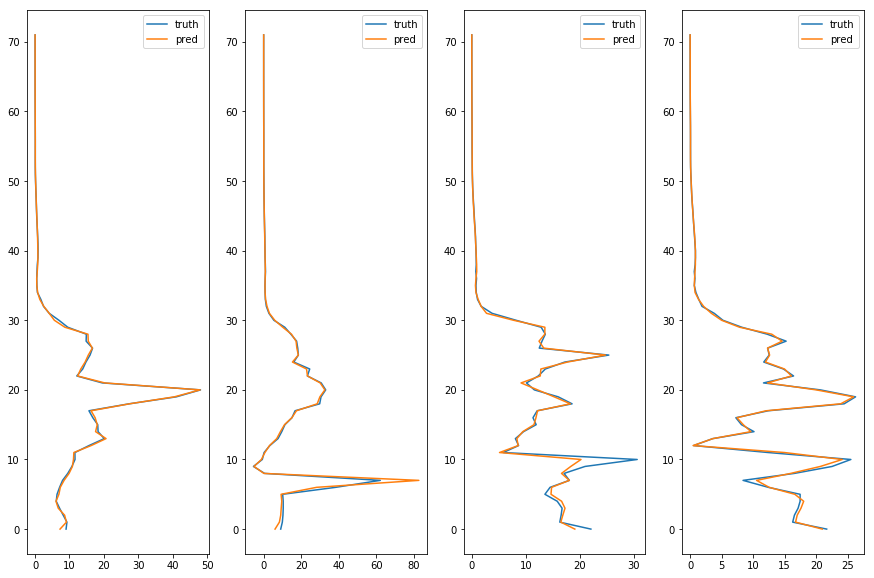

In [25]:
from utils import F_and_plots, Plot_diff

#validation_generator = FLX_Cumulative_Generator(data_folder, shuffle=1, preprocess_x=V)
#validation_generator = FLX_Generator(data_folder, shuffle=1, preprocess_x=V)

def medium_pred(Mlist,x):
    for i,m in enumerate(Mlist):
        if i>0:
            y=y+m.predict(x)
        else:
            y=m.predict(x)
    return(y/len(Mlist))
    
i=0#np.random.randint(len(validation_generator))
x,y=train_generator[i]

y0 = medium_pred([M],x)

y0 = np.expand_dims(y0,axis=-1)
y = np.expand_dims(y,axis=-1)

J=np.arange(4)
Plot_diff( F_and_plots(shape=(1,len(J))), y,y0, header_y=['flx'], J=J)
#Plot_diff( F_and_plots(shape=(1,len(J))), y[:,-upper_lev:,:],y0[:,-upper_lev:,:], header_y=['flx'], J=J)
#Plot_diff( F_and_plots(shape=(1,len(J))), y,y0, header_y=['flx'], J=J)
#Plot_diff( F_and_plots(shape=(1,1)), y, y0, header_y=['flx'], J=[4])

In [38]:
def mse(x,y):
    return( np.sum(np.square(x-y)) )
train_generator.on_epoch_end()
bpc=train_generator.batch_per_file
error=[]
for i,(x,y) in enumerate(train_generator):
    y0 = medium_pred([M],x)
    y0 = np.expand_dims(y0,axis=-1)
    y = np.expand_dims(y,axis=-1)
    error.append(mse(y,y0))
error=np.array(error)

In [12]:
train_generator.on_epoch_end()
train_generator.current_file

1

In [24]:
train_generator.current_file
train_generator.max_b=train_generator.batch_per_file

In [25]:
len(train_generator)

3888

In [39]:
print(np.mean(error[:bpc])/72/36, np.mean(error[bpc:])/72/36)

2.3476189507378473 2.825814894687982


In [37]:
print(np.mean(error[:bpc])/72/36, np.mean(error[bpc:])/72/36)

2.3476189507378473 2.825814894687982


In [24]:
#train_generator.idx_file
#train_generator.idx_folder
train_generator.List_of_dir

['Data3/20190216_1800z', 'Data3/20190401_0600z']

In [12]:
# Use input
# ---------
from netCDF4 import Dataset
from utils import Produce_netCDF4_jacobian, file_name_to_id, Produce_x_nc4
import numpy as np

path = 'Data_net4/Jacobians/'
# Open NetCDF file for reading
F = Dataset('Data_net4/401_600/f522_dh.trainingdata_in.lcv.20190401_0600z.nc4')

J_fortran = []
profiles = []

for j in os.listdir(path):
    ex = j.split('.')[-1]
    if(ex=='nc4'):
        profiles.append(j.split('.')[0])

ids_profiles = [ file_name_to_id(profile) for profile in profiles]
#profiles=['jacobian_i0720_j0500']
xnc4 = np.zeros((len(profiles),lev, len(header_x)))
for i,profile in enumerate(profiles):
    fh = Dataset(path+profile+'.nc4')
    J_fortran.append(Produce_netCDF4_jacobian(fh, header_x))
    xnc4[i] = Produce_x_nc4(F, ids_profiles[i][0], ids_profiles[i][1], header_x)

In [13]:
#Plot_diff(F_and_plots(shape=(1,1)), -ysum, -ysum, header_y=['flx'], J=[0]  )
#Plot_diff(F_and_plots(shape=(1,1)), -y, -y, header_y=['flx'], J=[0]  )

In [14]:
from utils import Jacobian_NonCM, Jacobian_Fortran, Jacobian_Single_Var_emis, CumSum

In [15]:
from utils import Sep_Var_show
from matplotlib import ticker, cm
#F=F_and_plots(figsize=(30,30), shape=(3,3))
#F.f.savefig(profile[p_use]+'_jacob_mean'+'.jpg')
#Sep_Var_show(F,J, header_x)

## Ploting the non Jacobian of the NN net, the cumulative Jacobian and the input

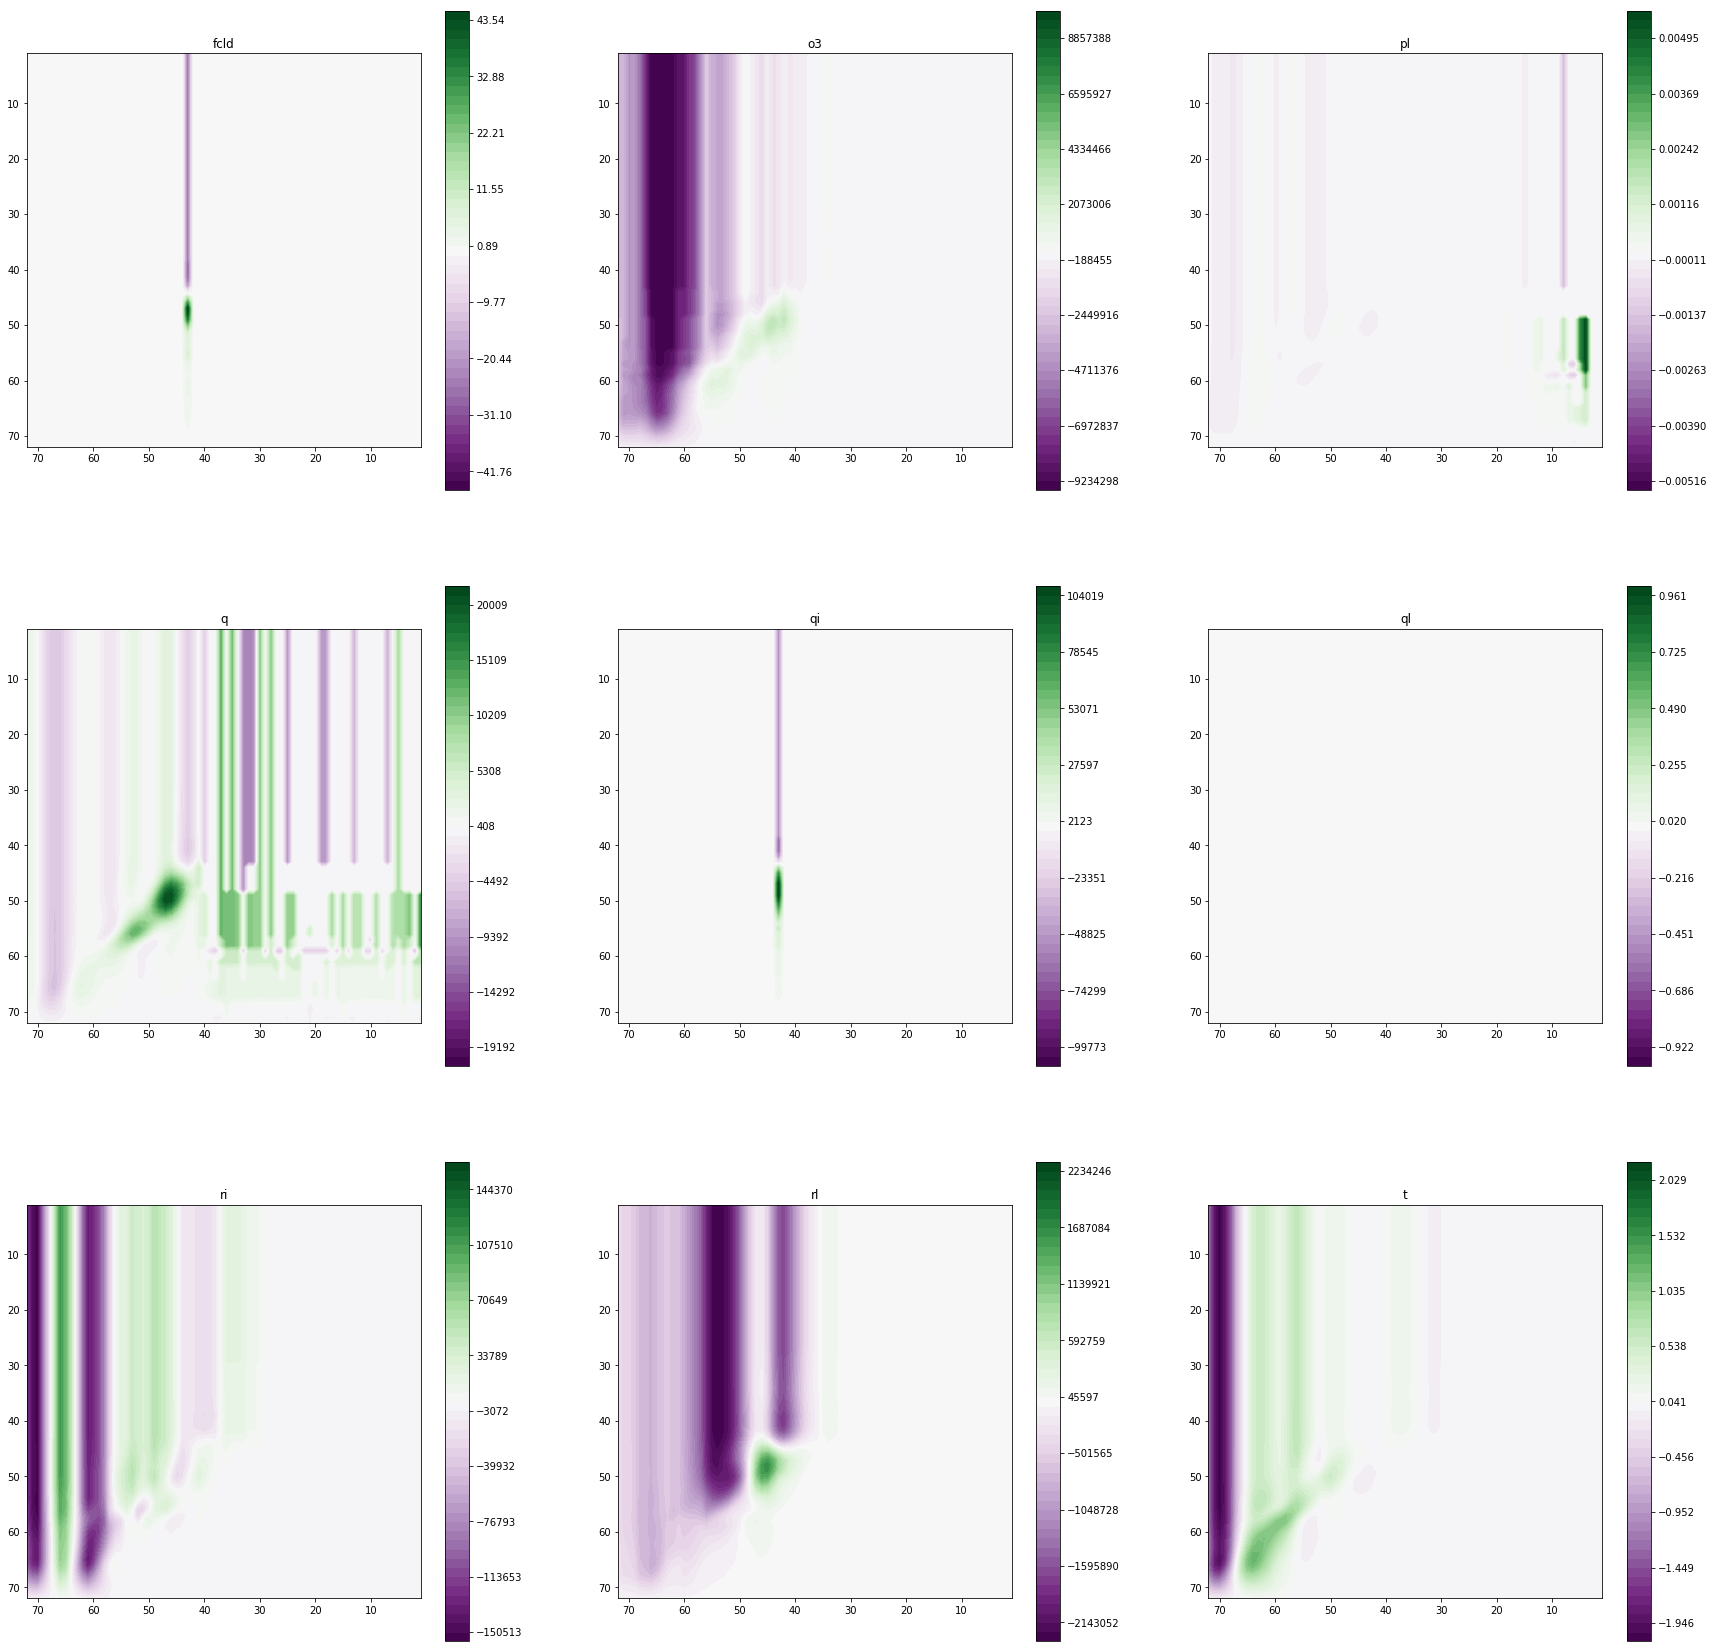

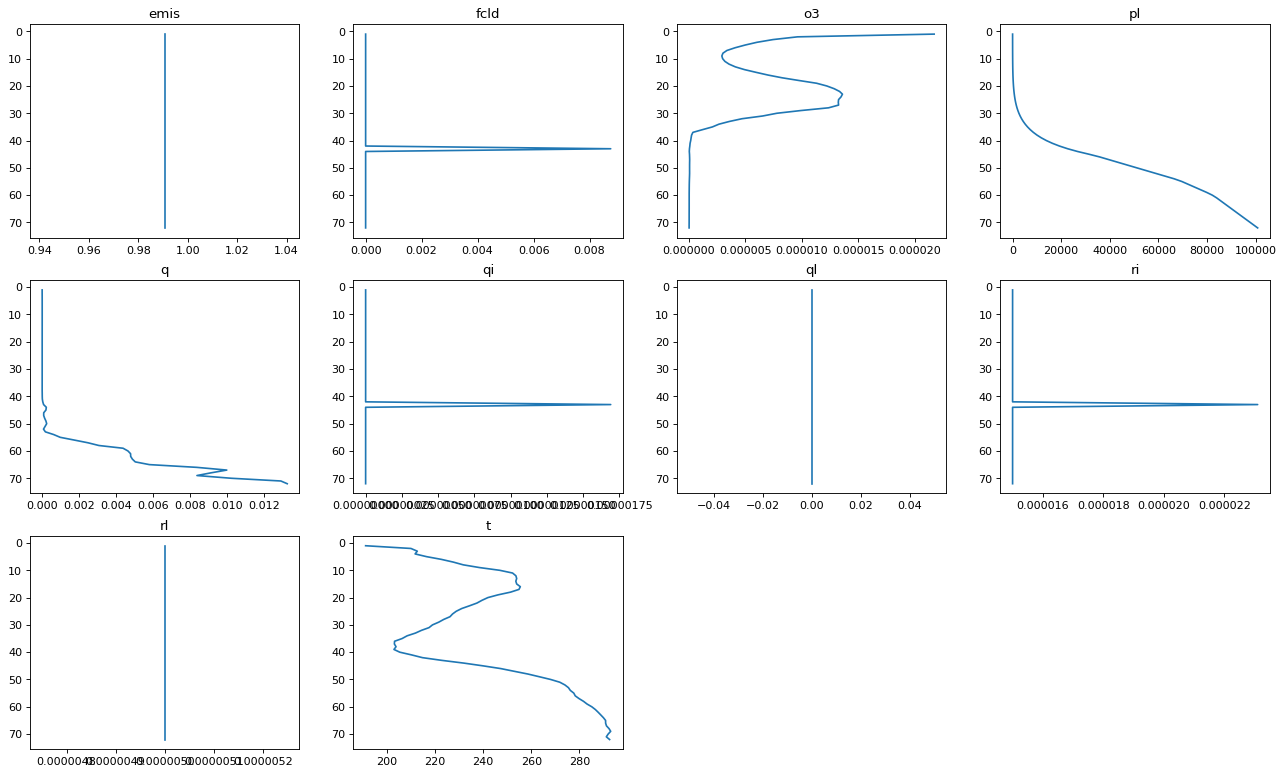

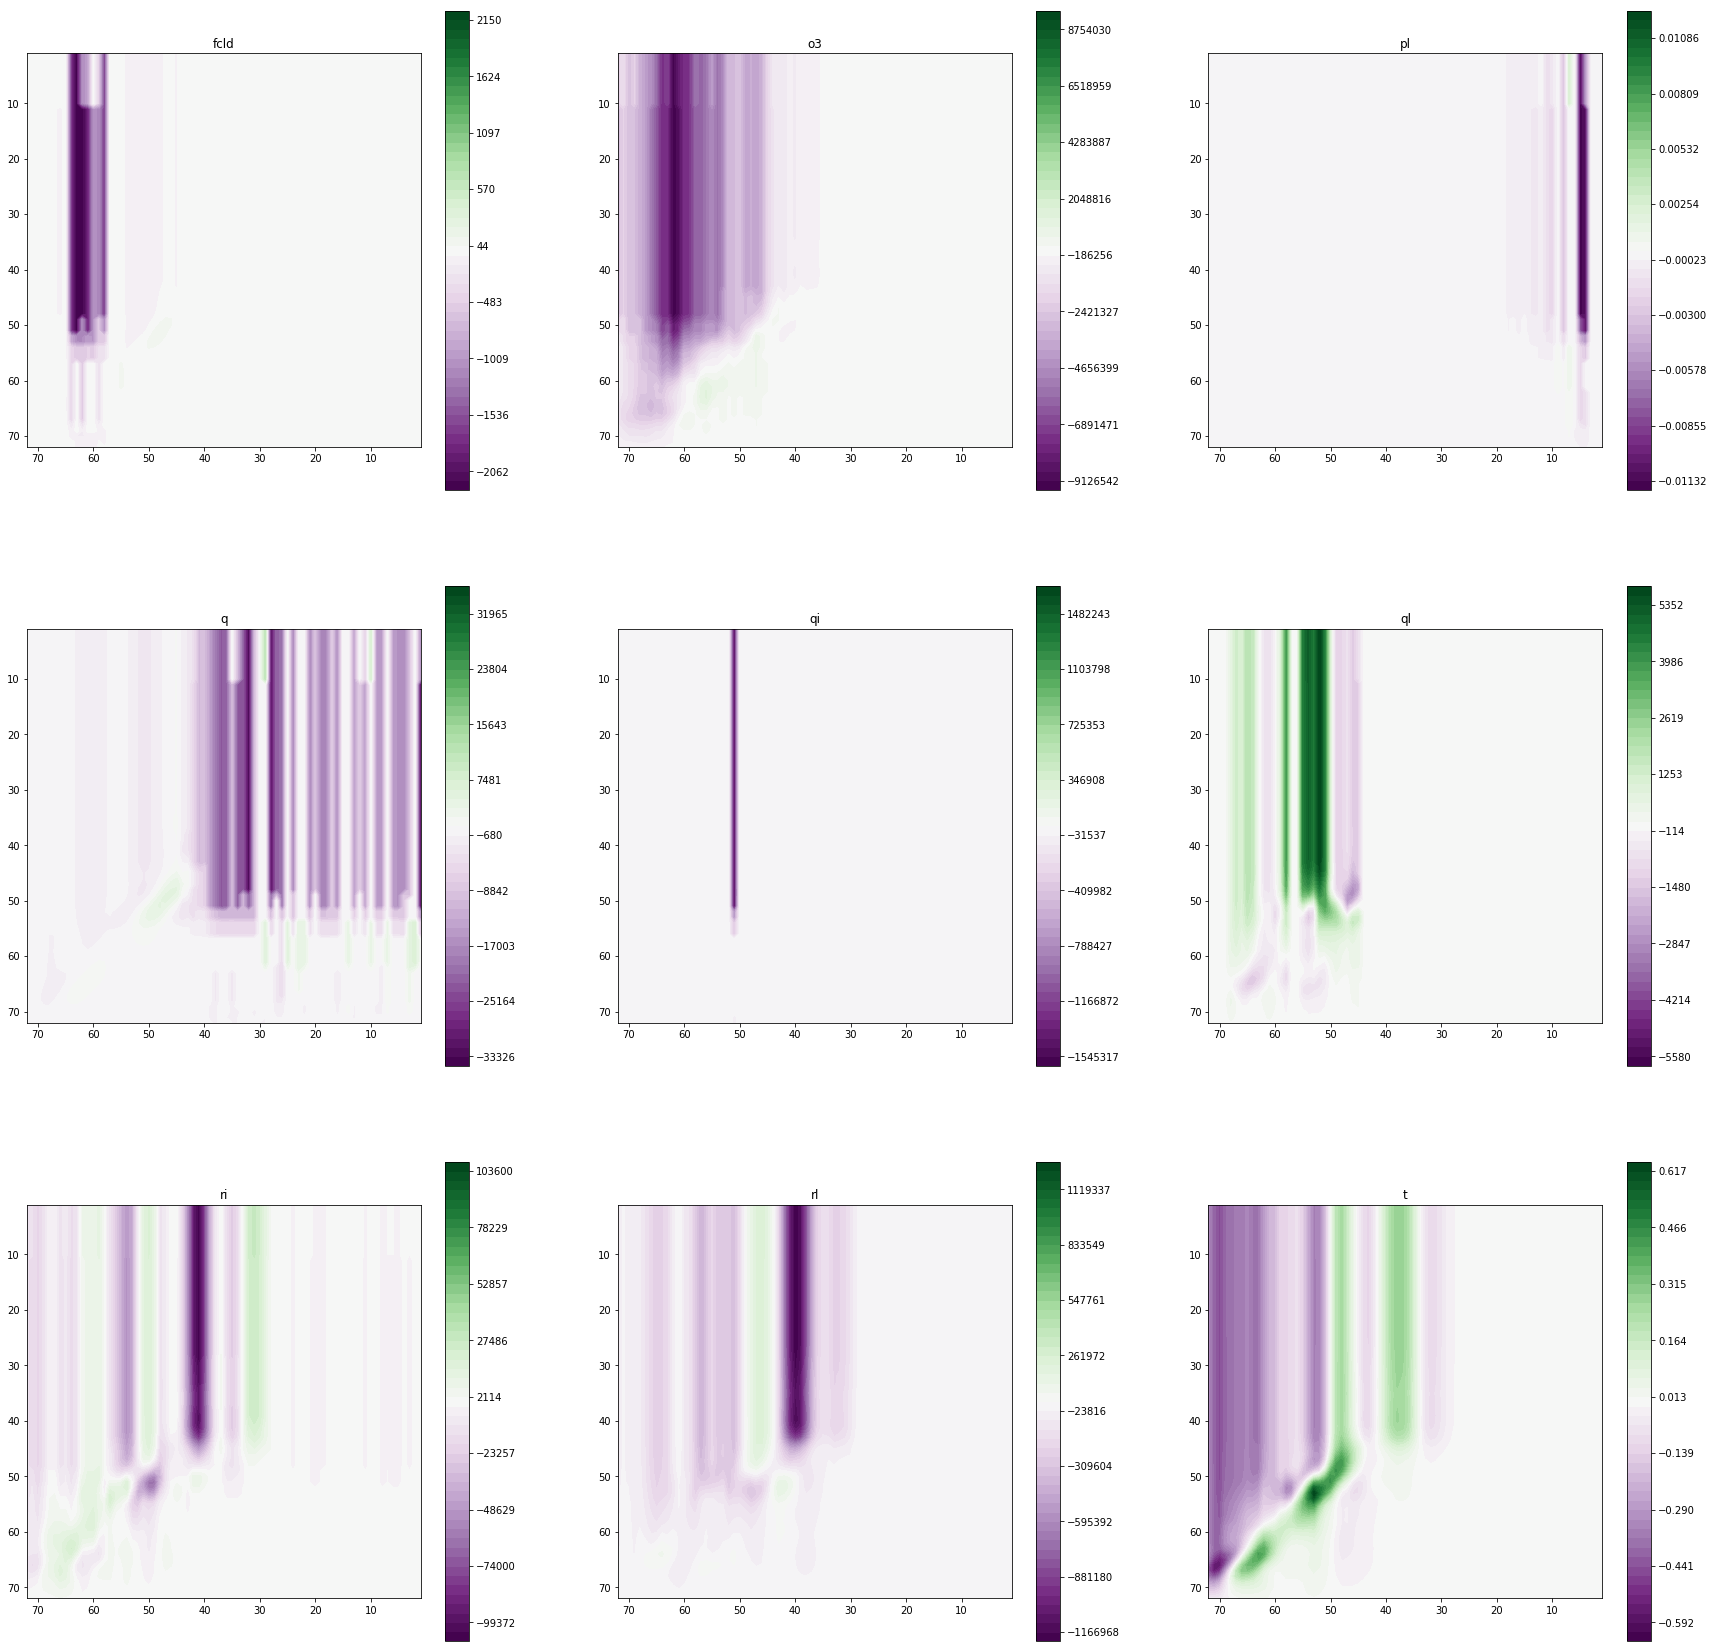

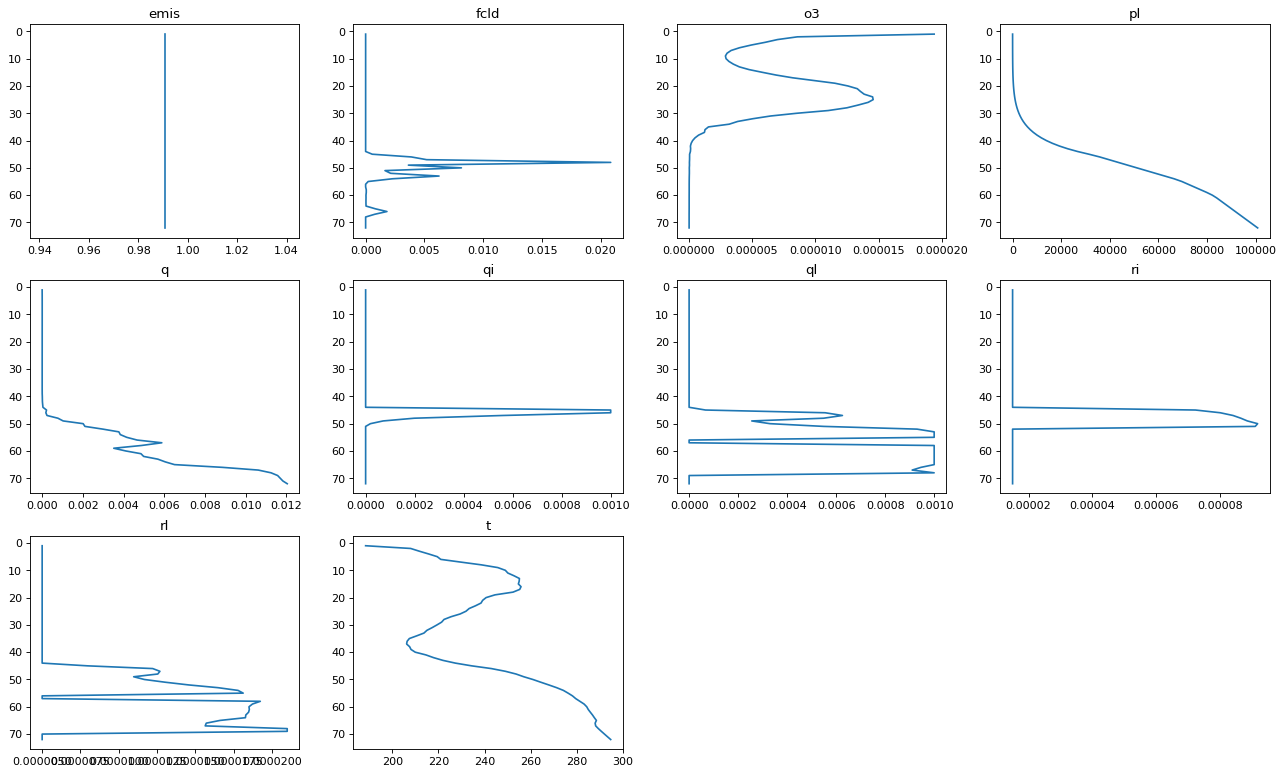

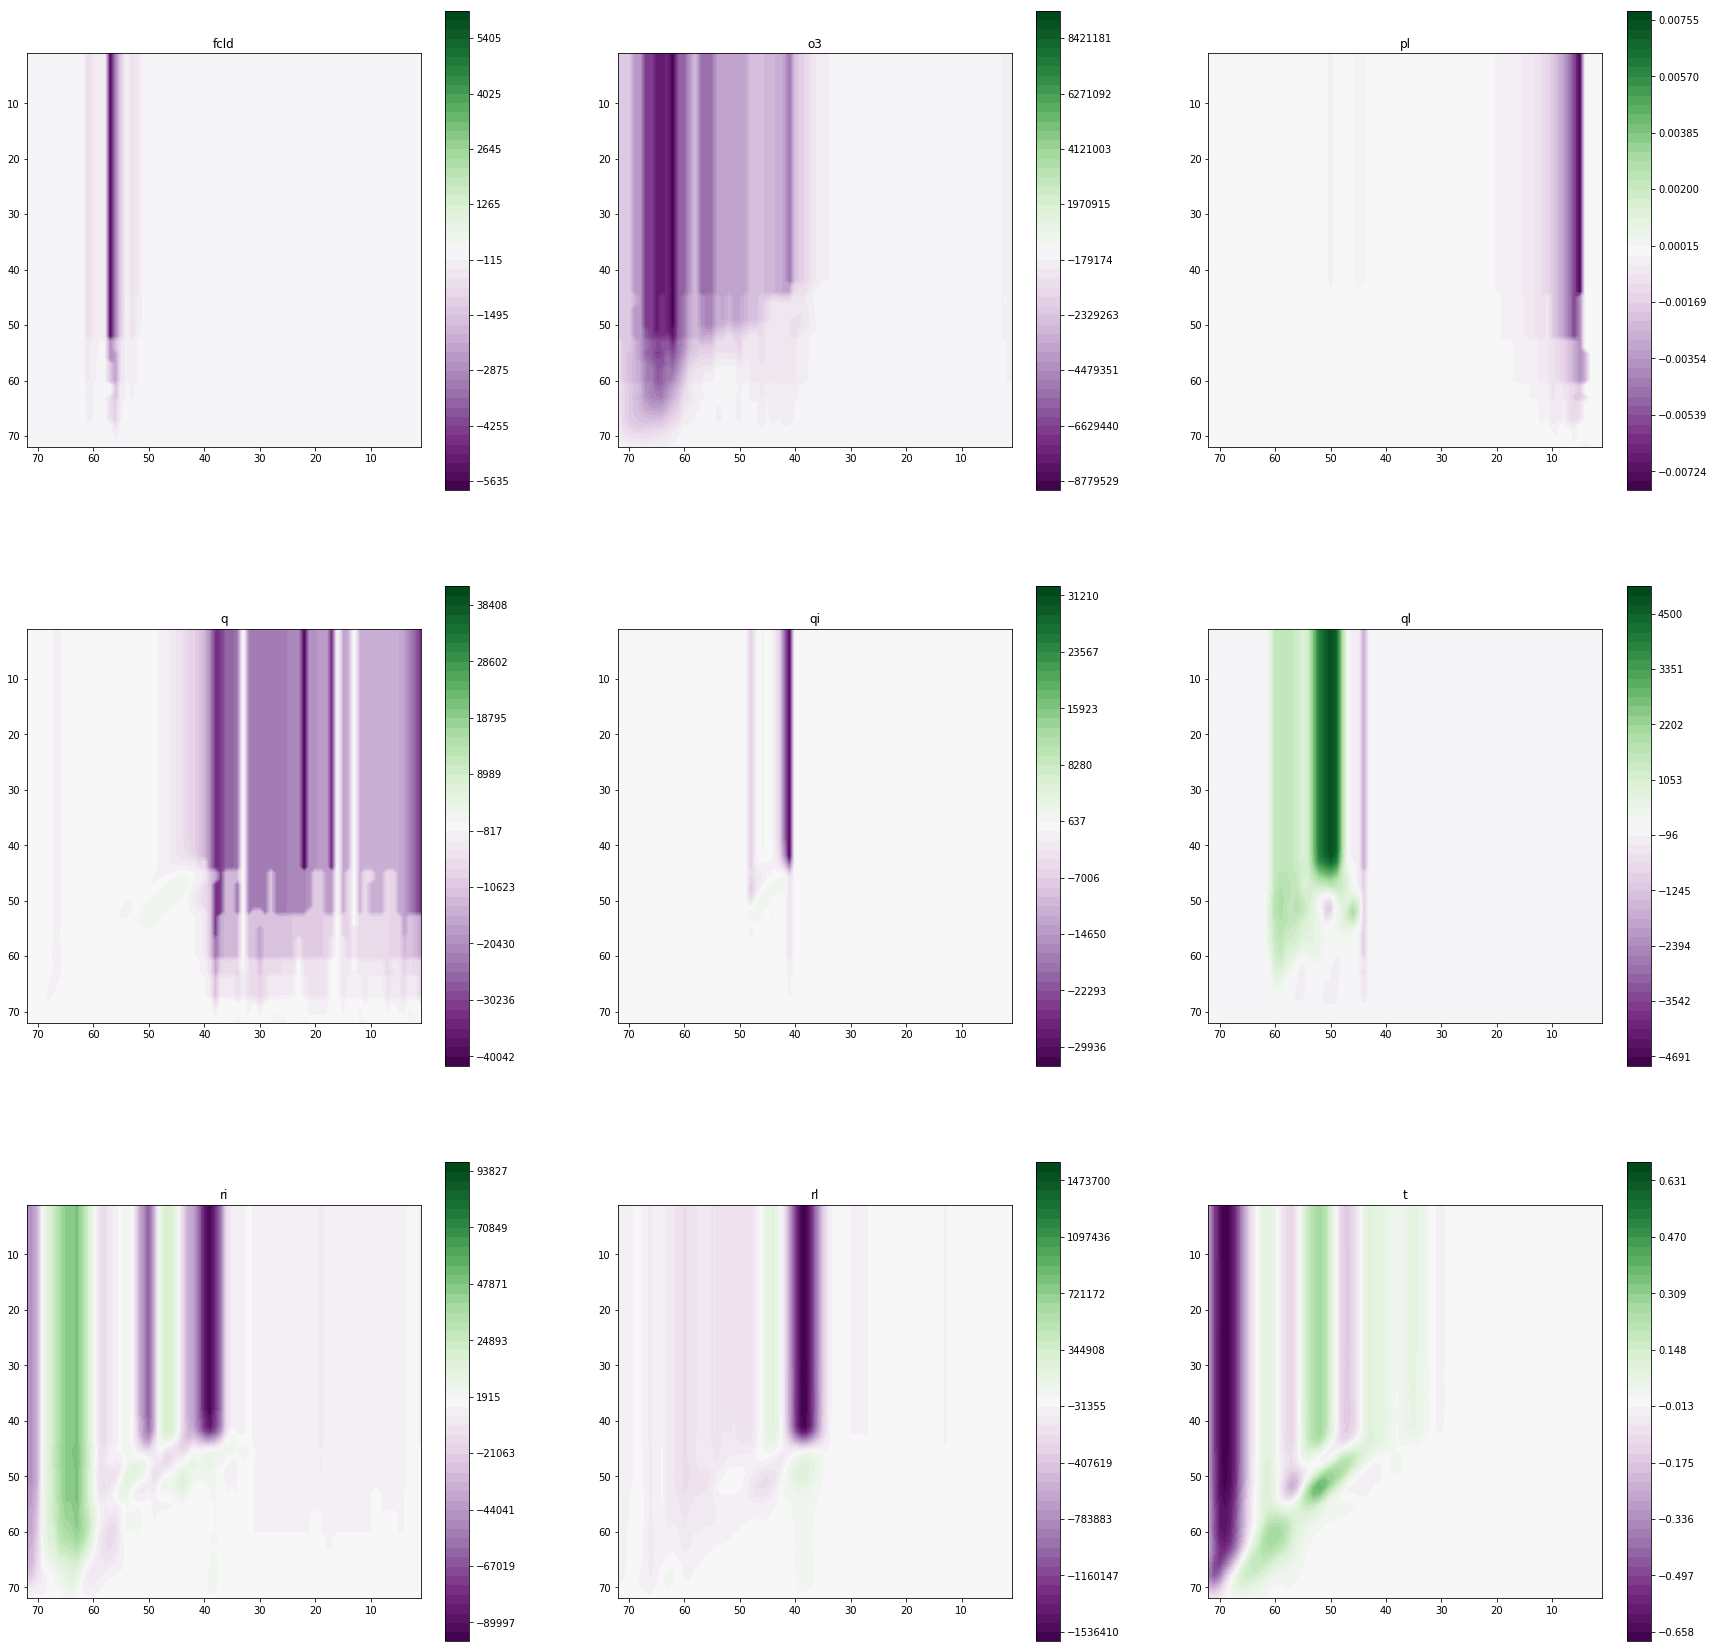

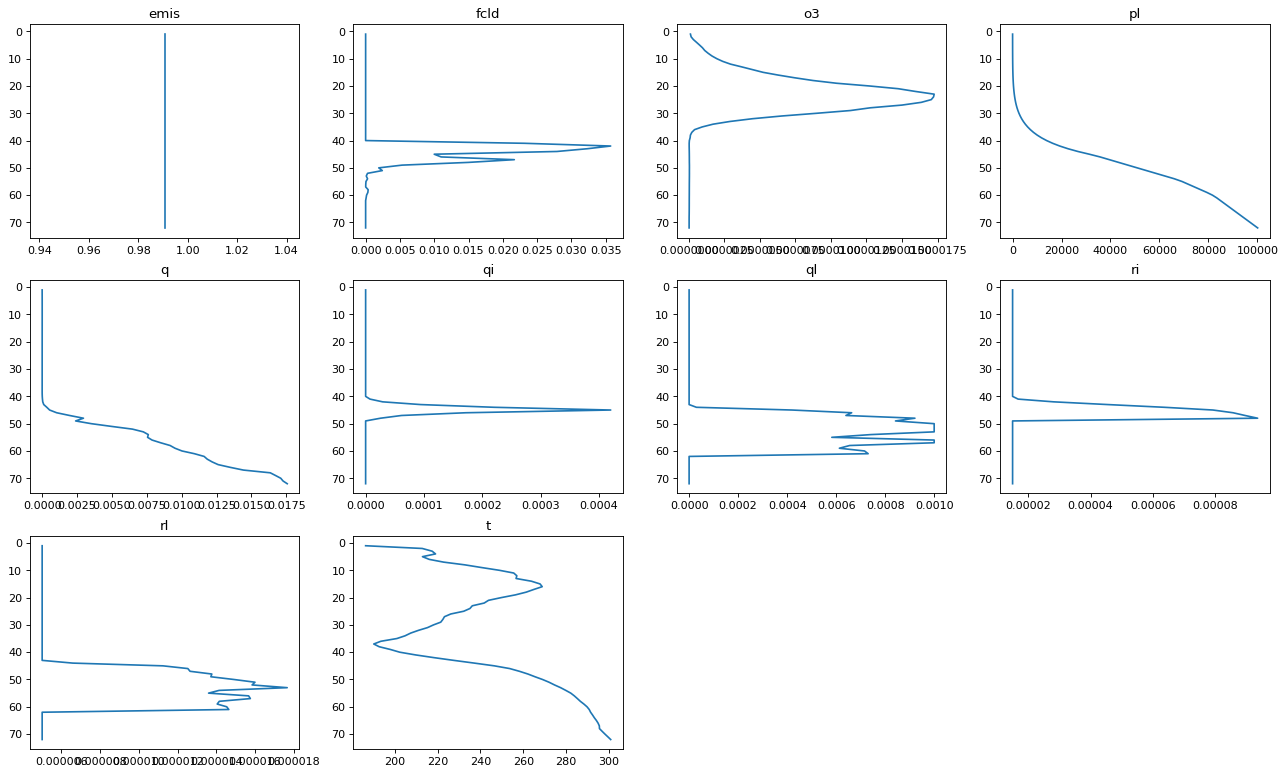

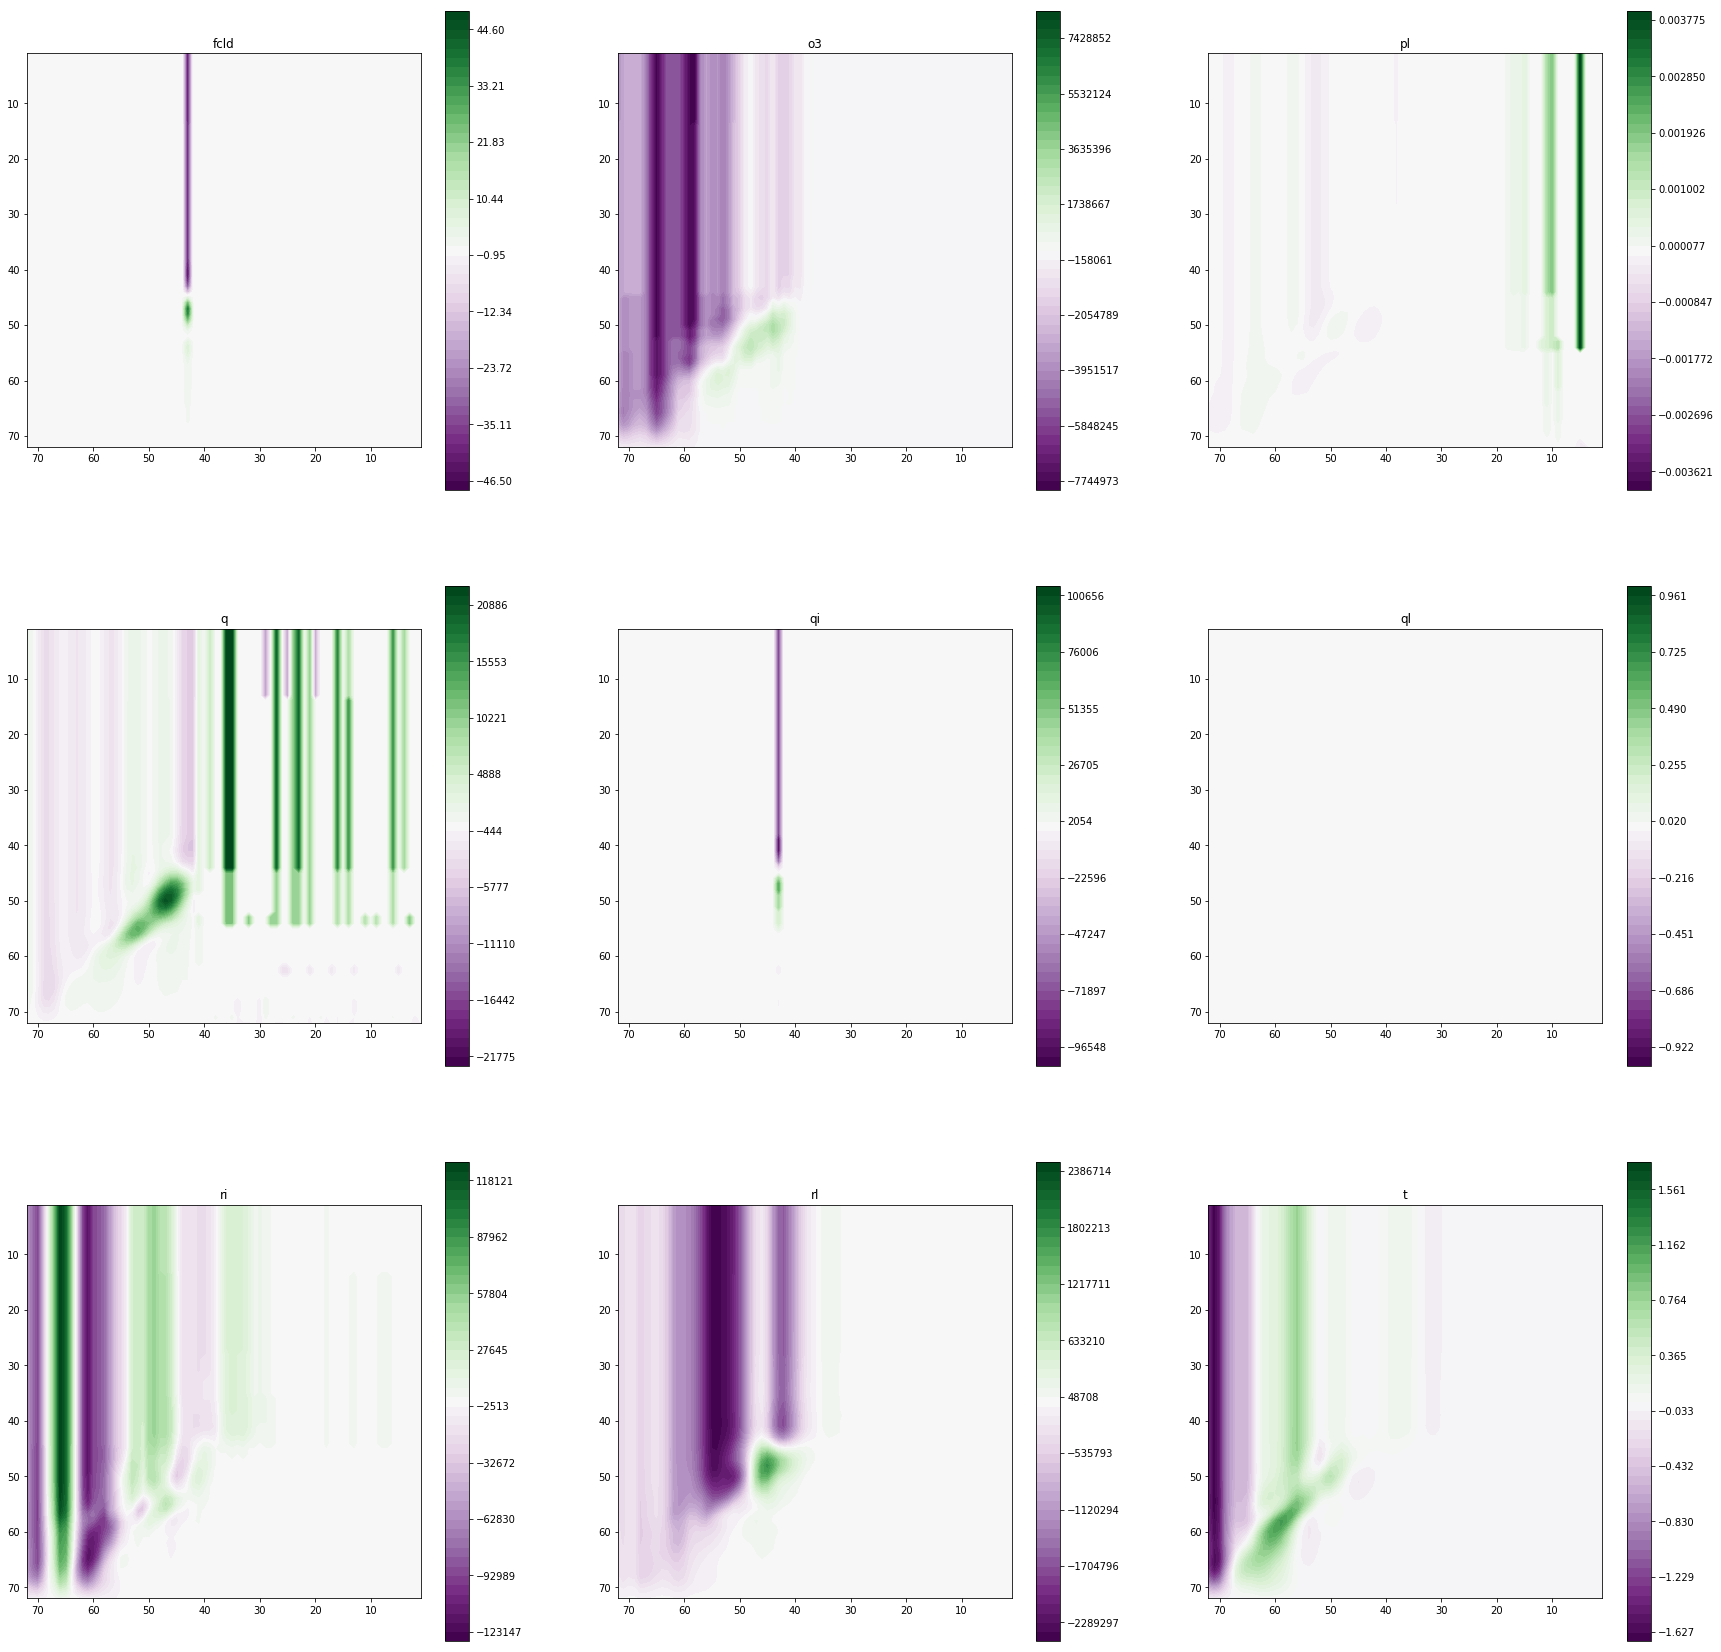

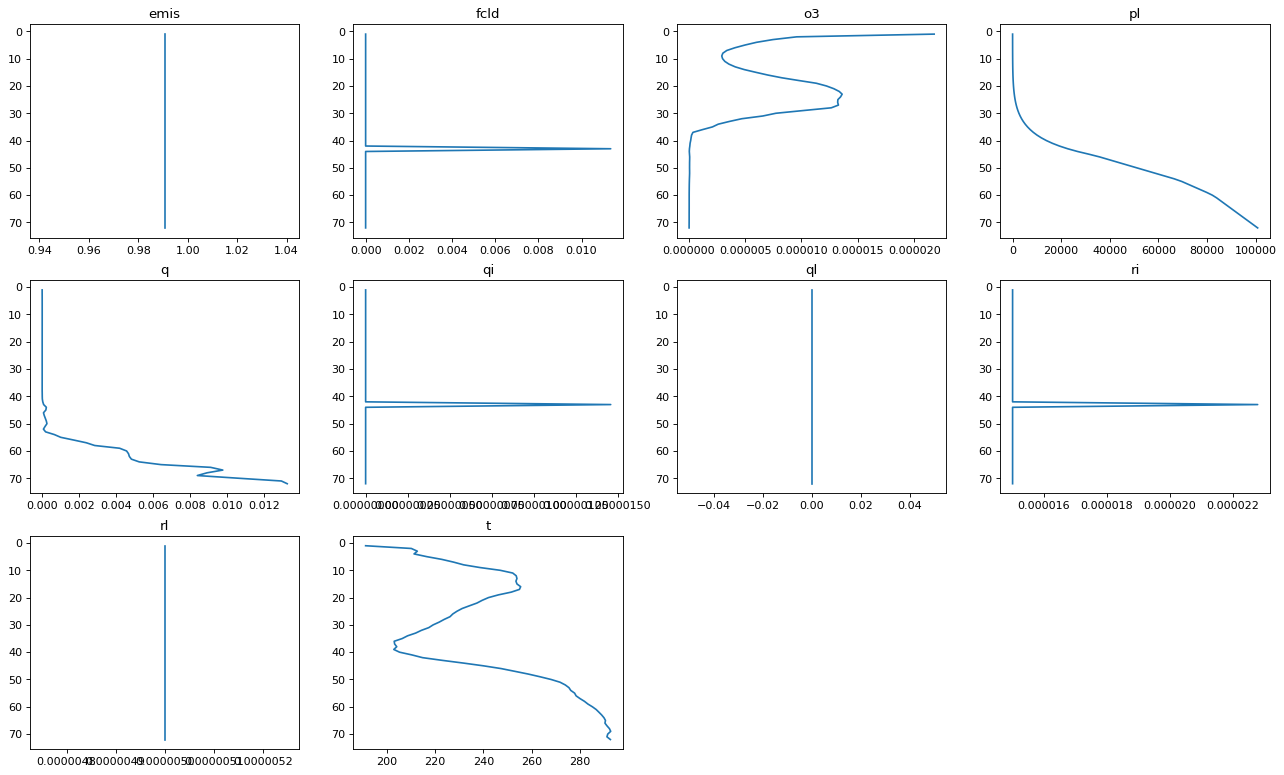

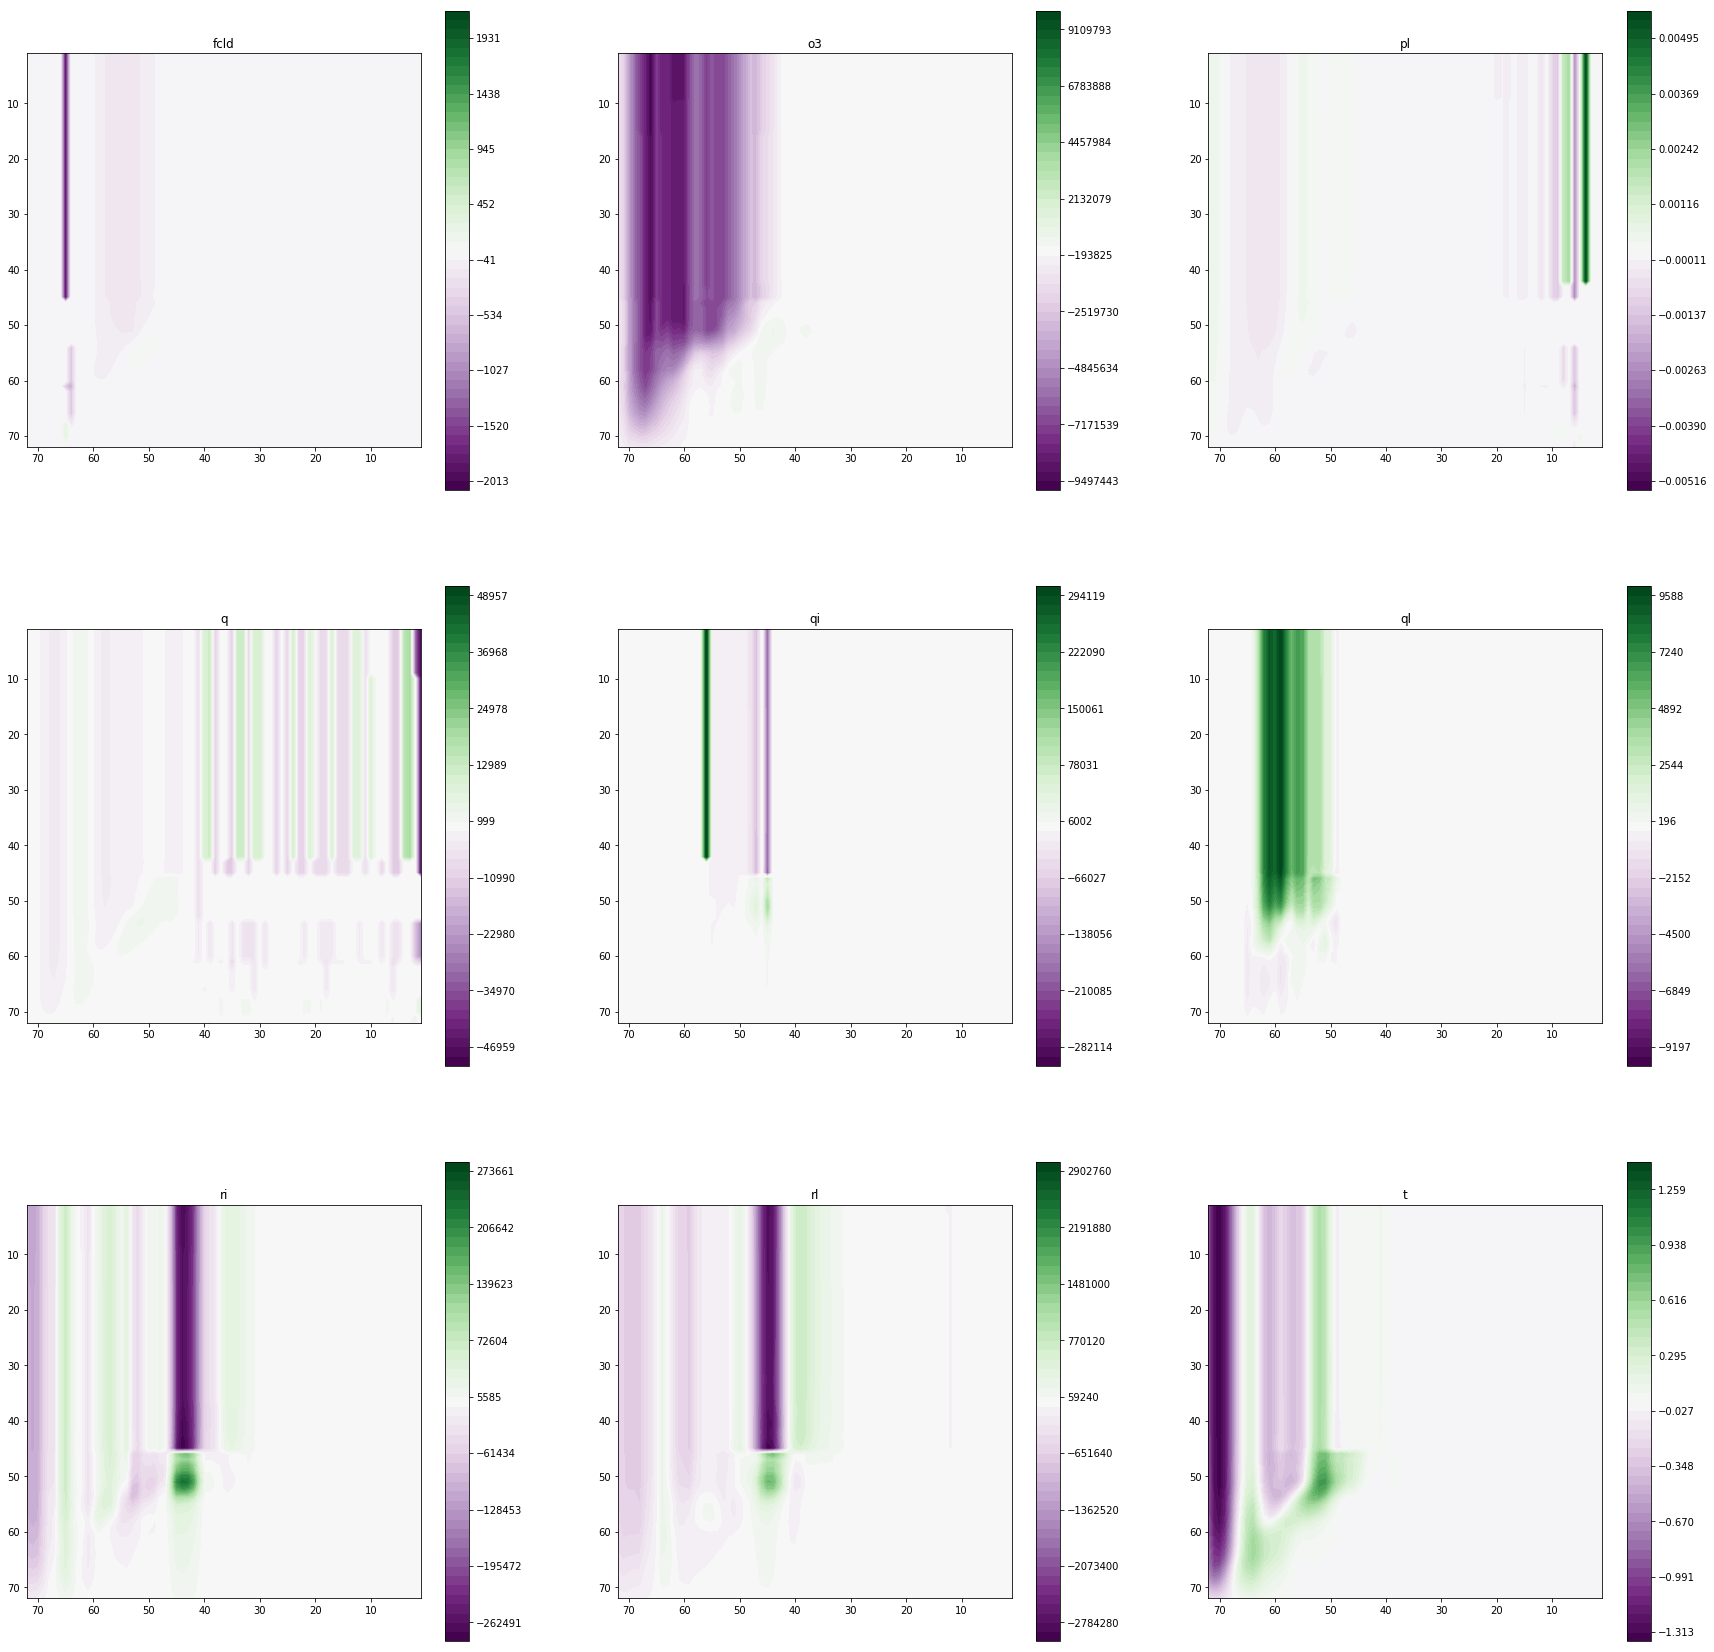

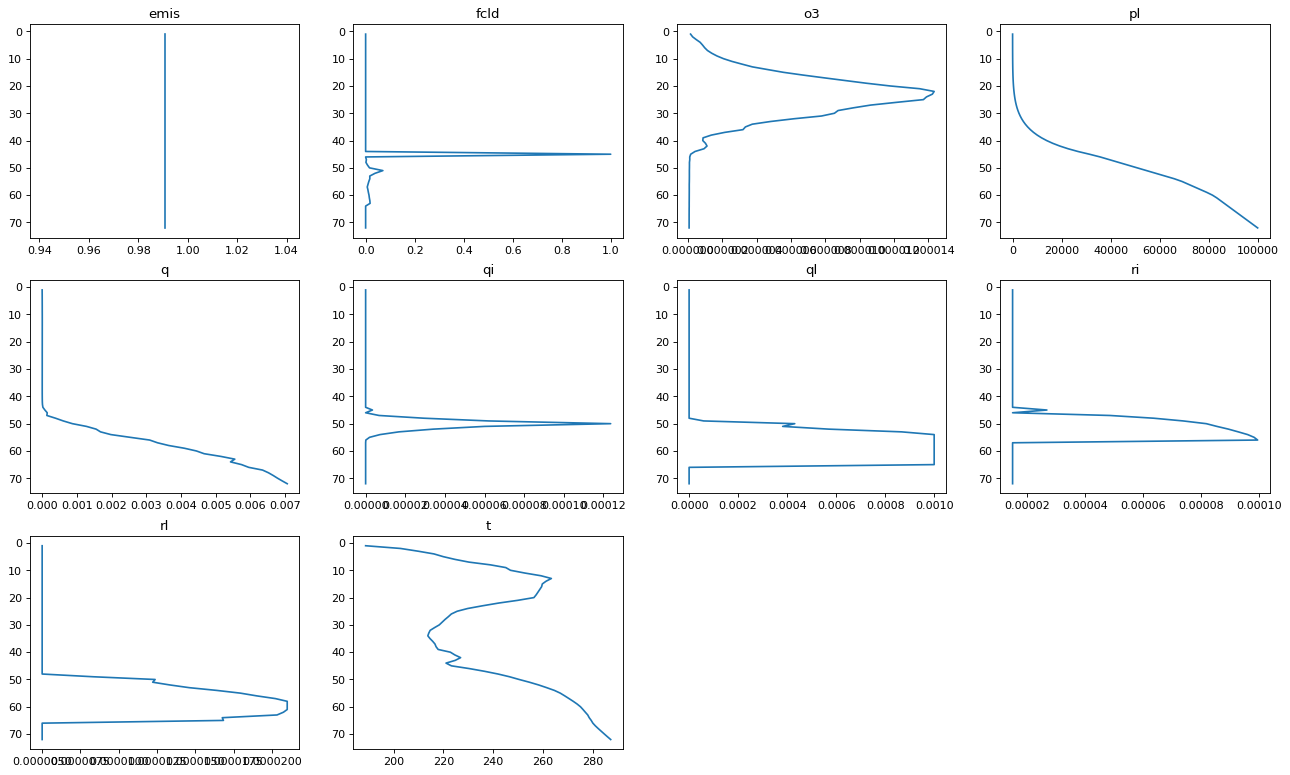

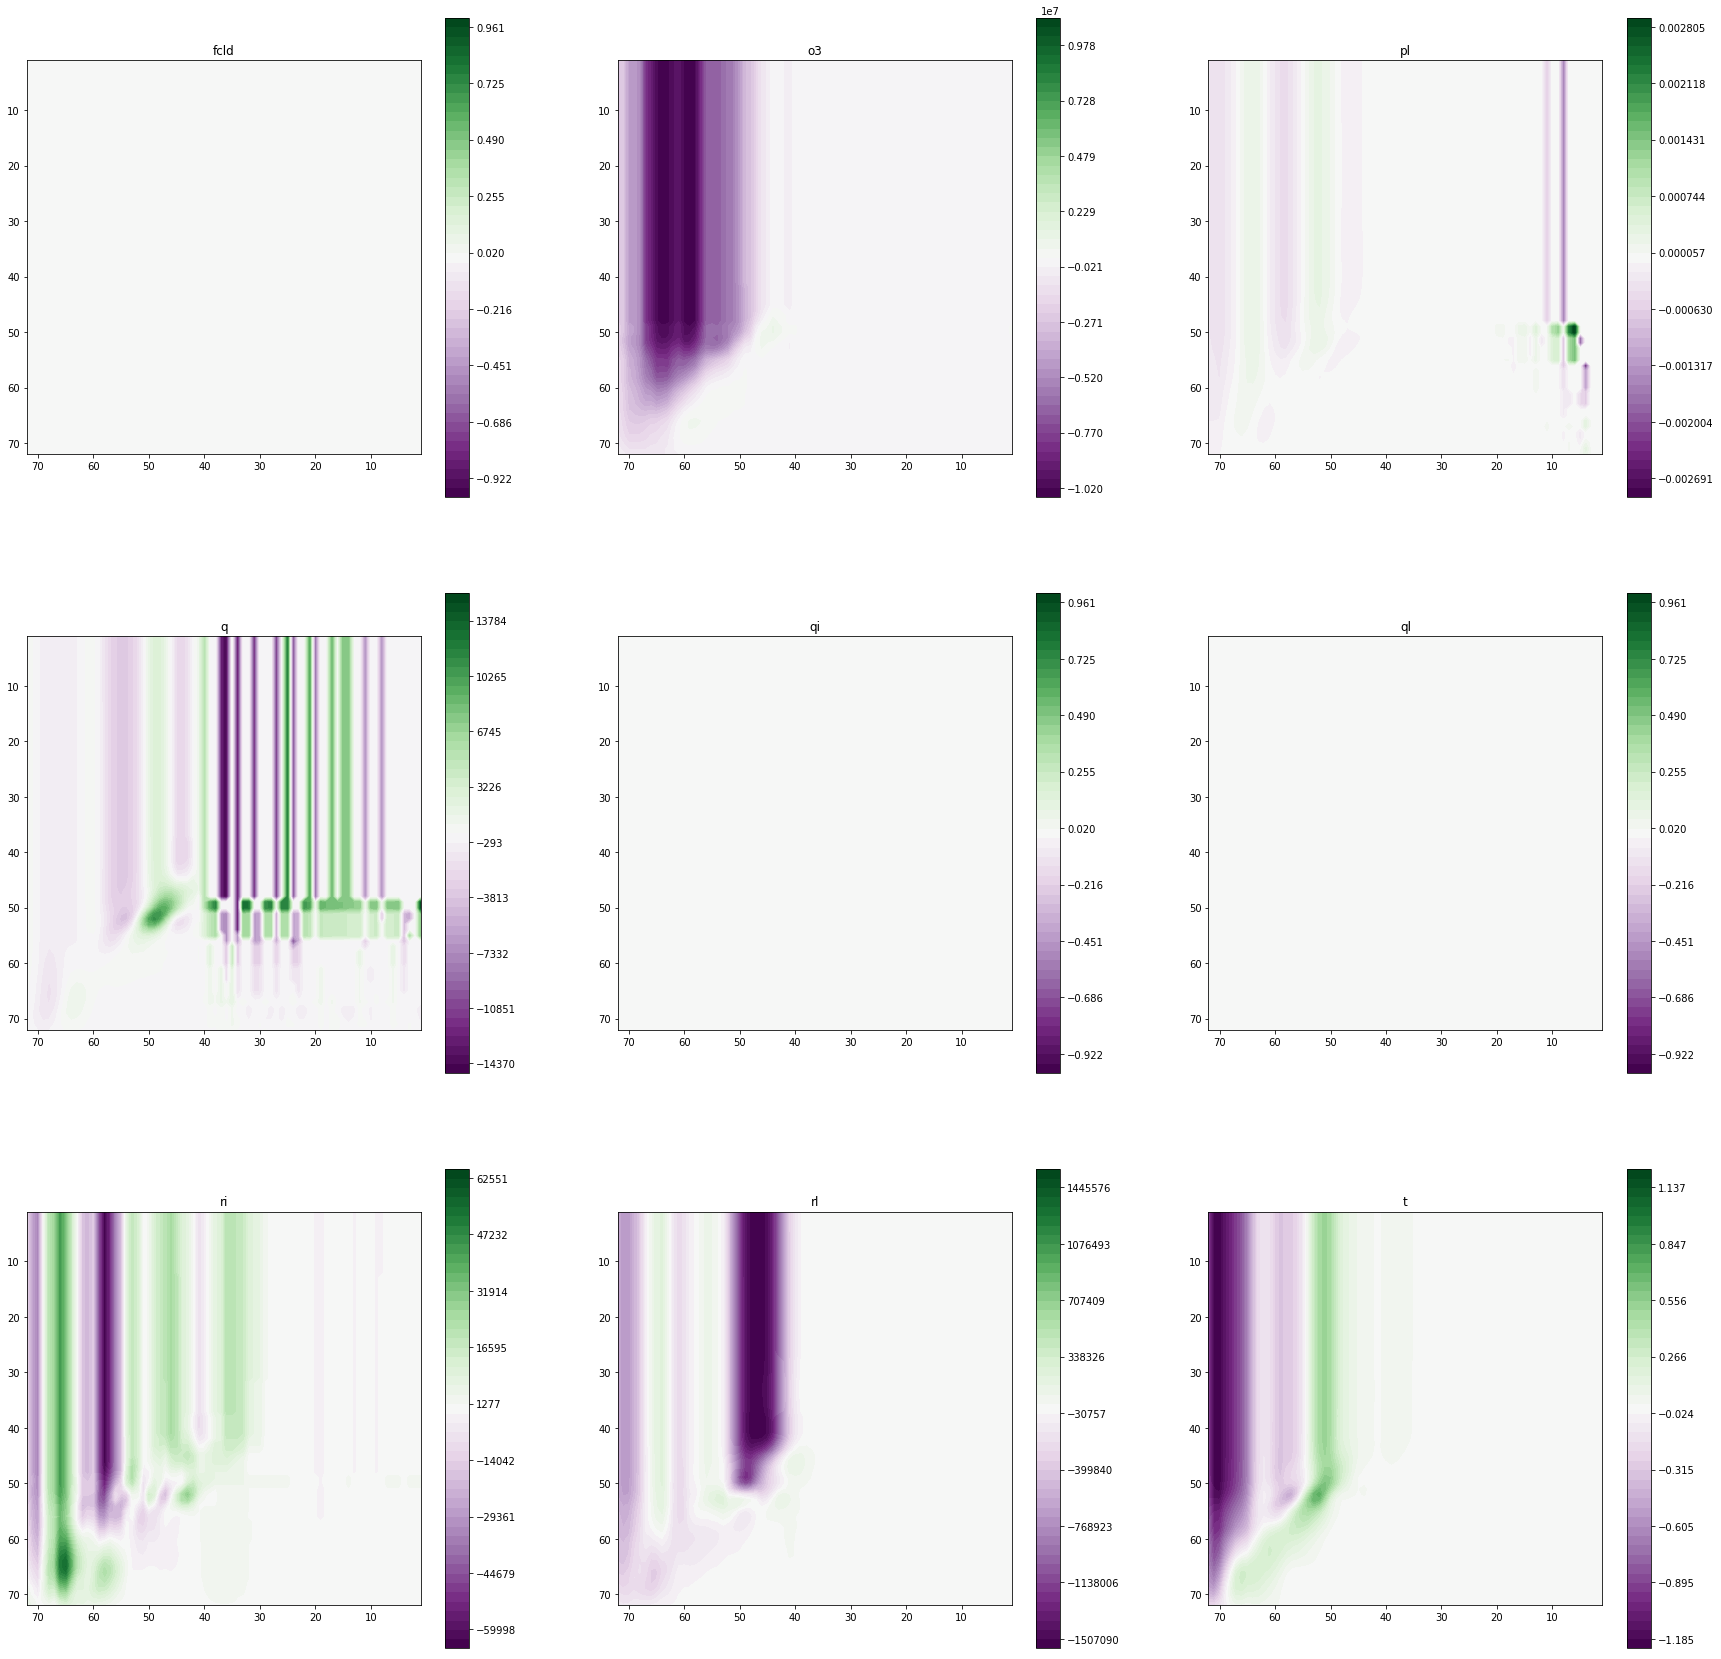

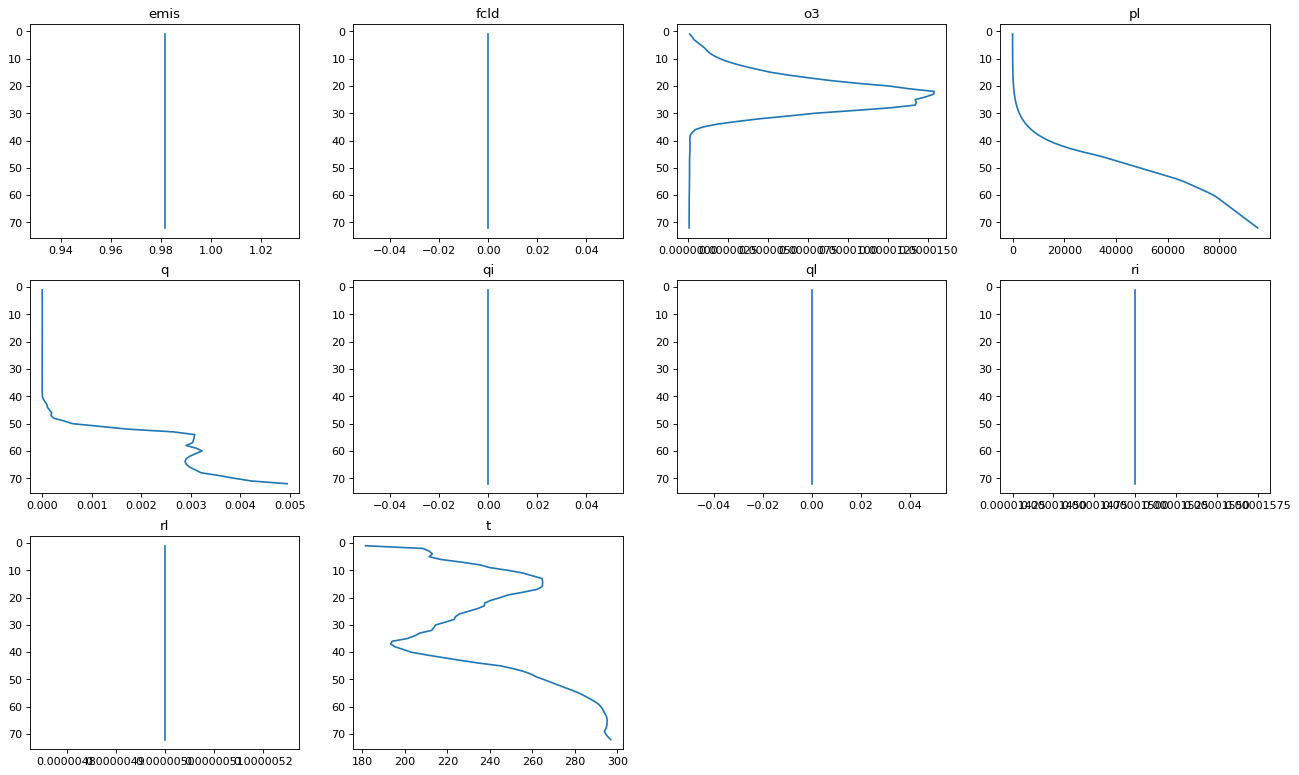

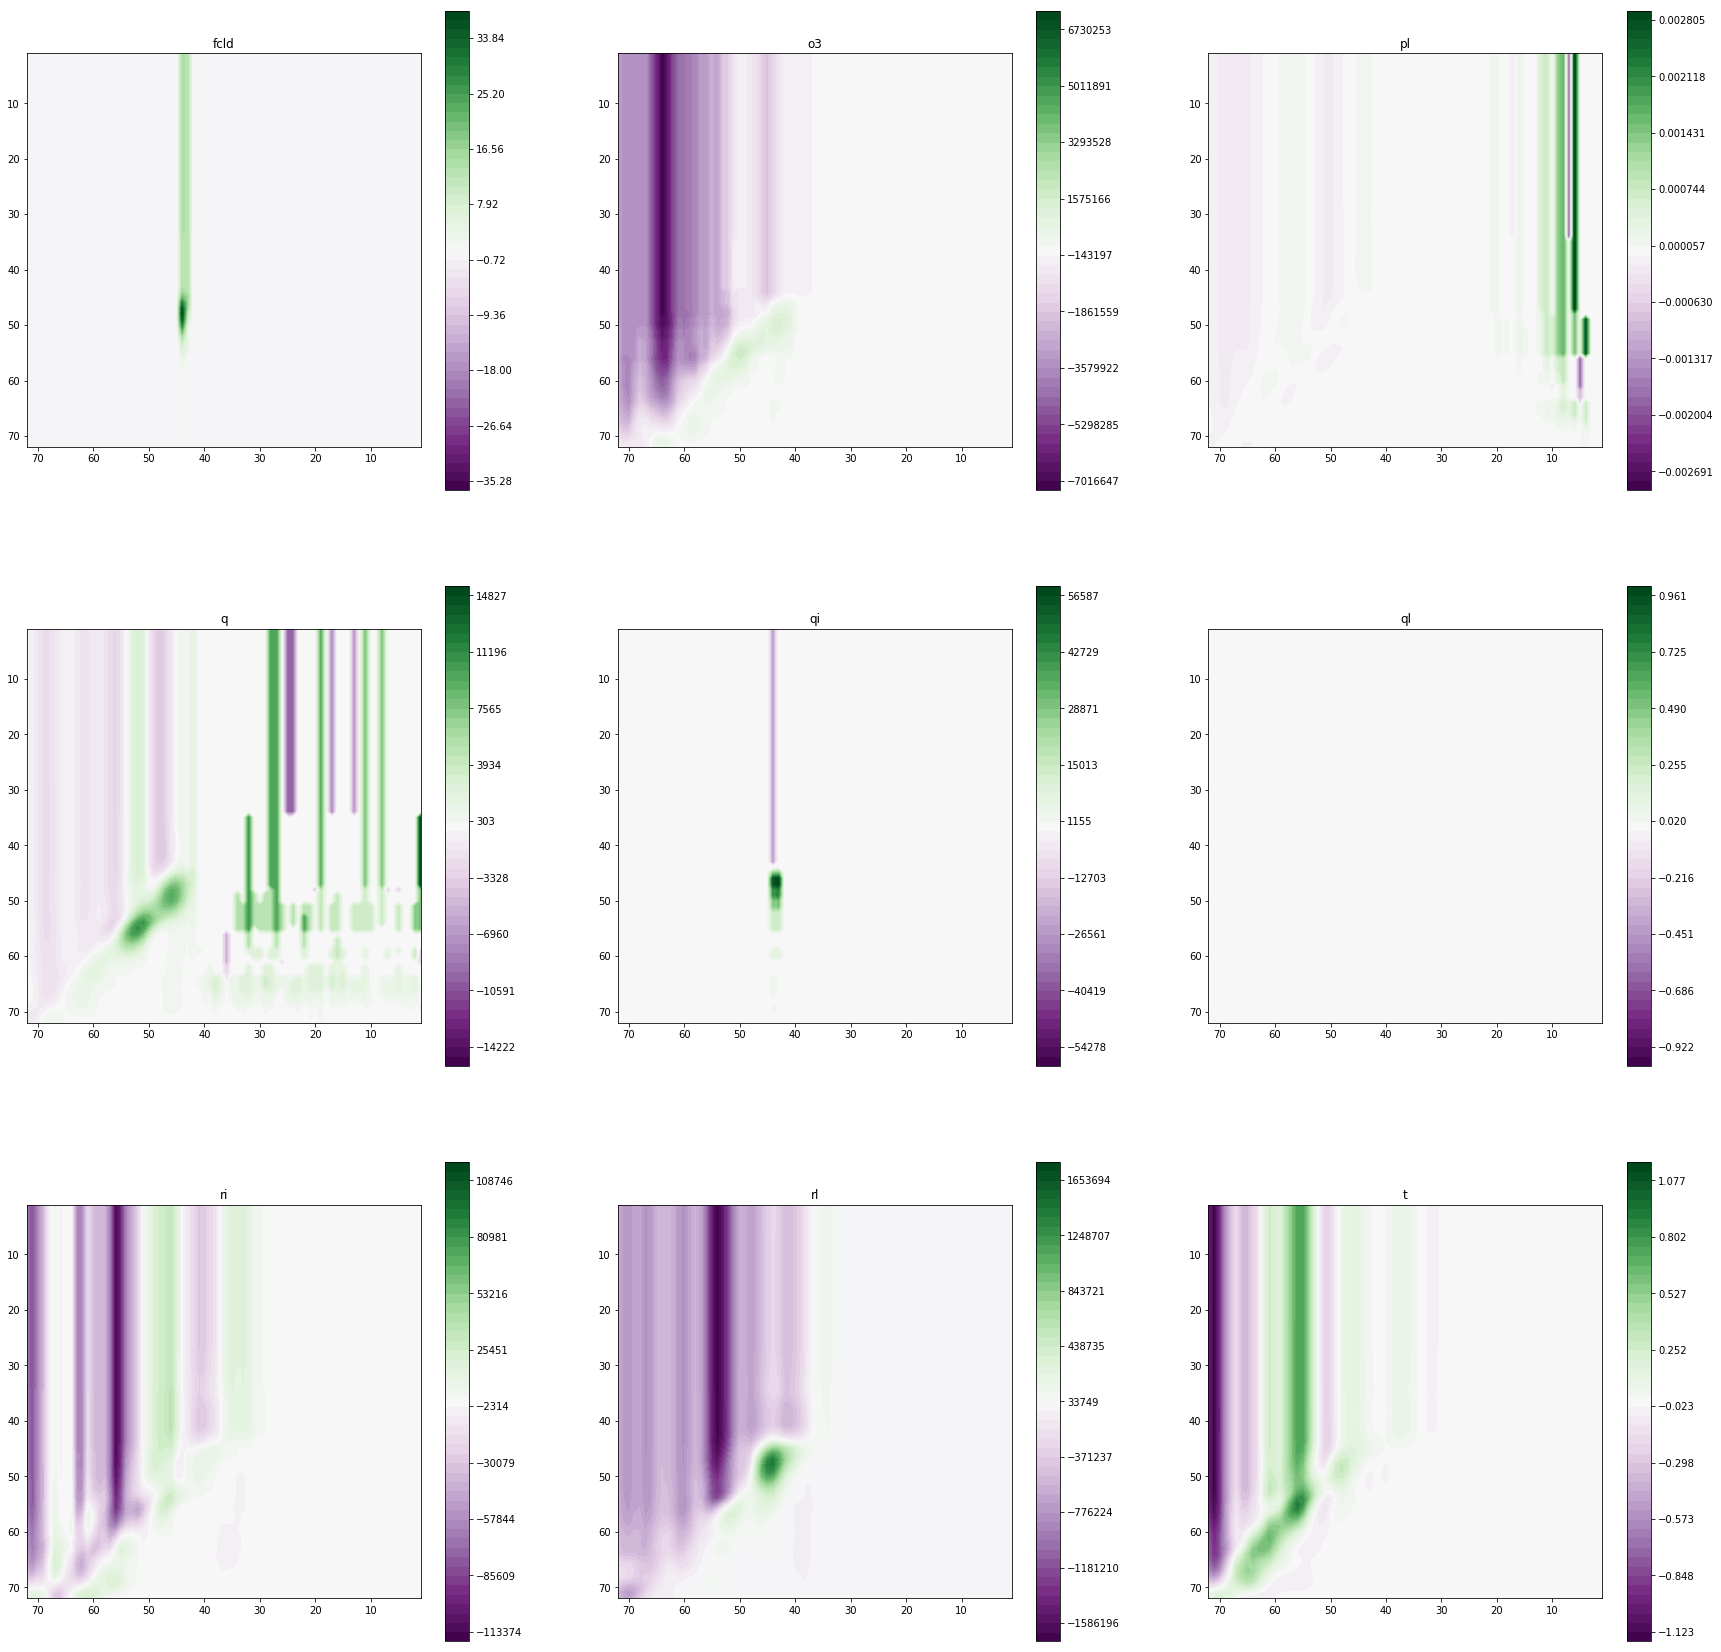

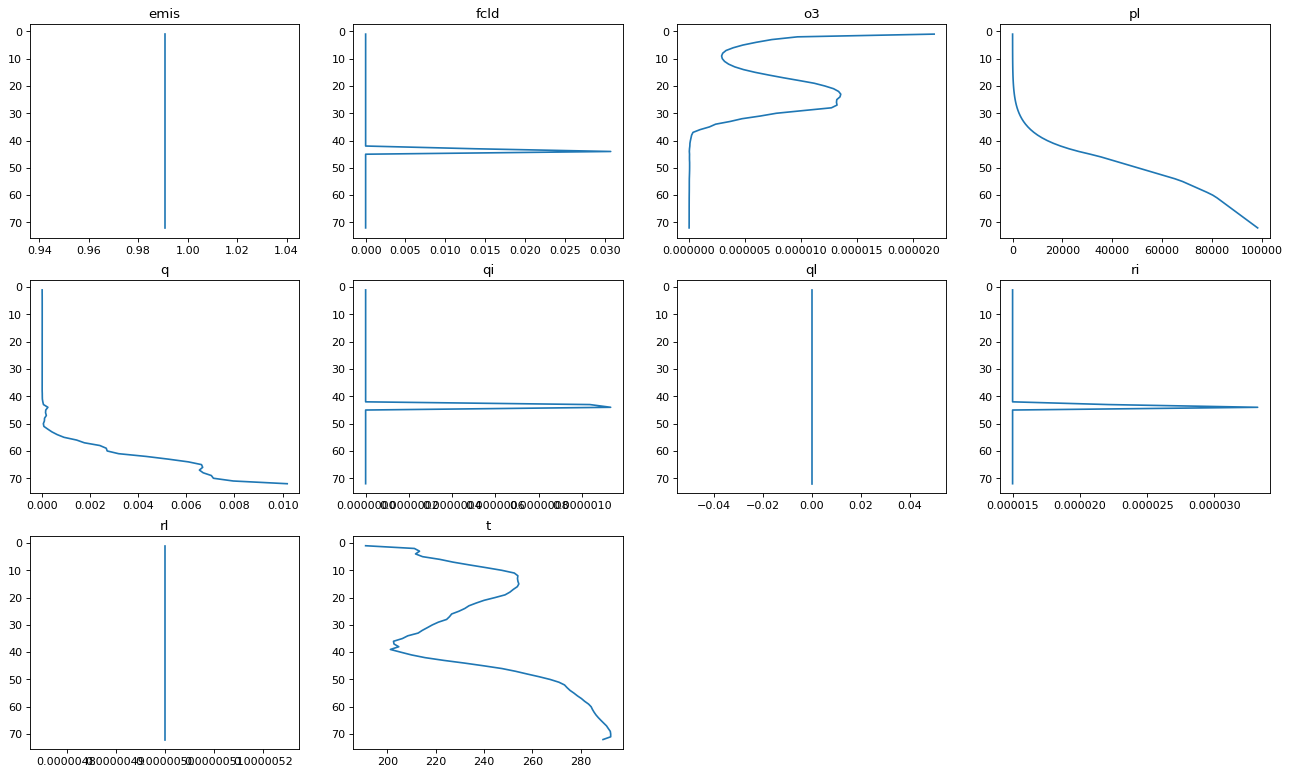

In [16]:
# Params
archi = 'arch_Unet_DP'
Models = [M5]

o_path_0 ='/home/victor/Documents/Stage/FLXmodel/Jacobians/'
o_path = os.path.join(o_path_0, archi)
if not os.path.exists(o_path):
    print('Creating', o_path)
    os.mkdir(o_path)

for i, p in enumerate(profiles):
    xi = xnc4[[i]]
    
    #F=F_and_plots(figsize=(30,30), shape=(3,3))
    #J = Jacobian_NonCM(Models,xi,1000)
    #Sep_Var_show(F, J, header_x)
    #F.f.savefig( os.path.join(o_path , p +'_' + archi + '_noncumul'+'.jpg'))

    F=F_and_plots(figsize=(30,30), shape=(3,3))
    J = Jacobian_Fortran(Models,xi,1000)
    Sep_Var_show(F, J, header_x)
    F.f.savefig(os.path.join(o_path , p + '_' + archi +'.jpg'))

    Plot_Batch(xnc4[[i]], header_x)
    plt.savefig(os.path.join(o_path , p + '_input.jpg'))

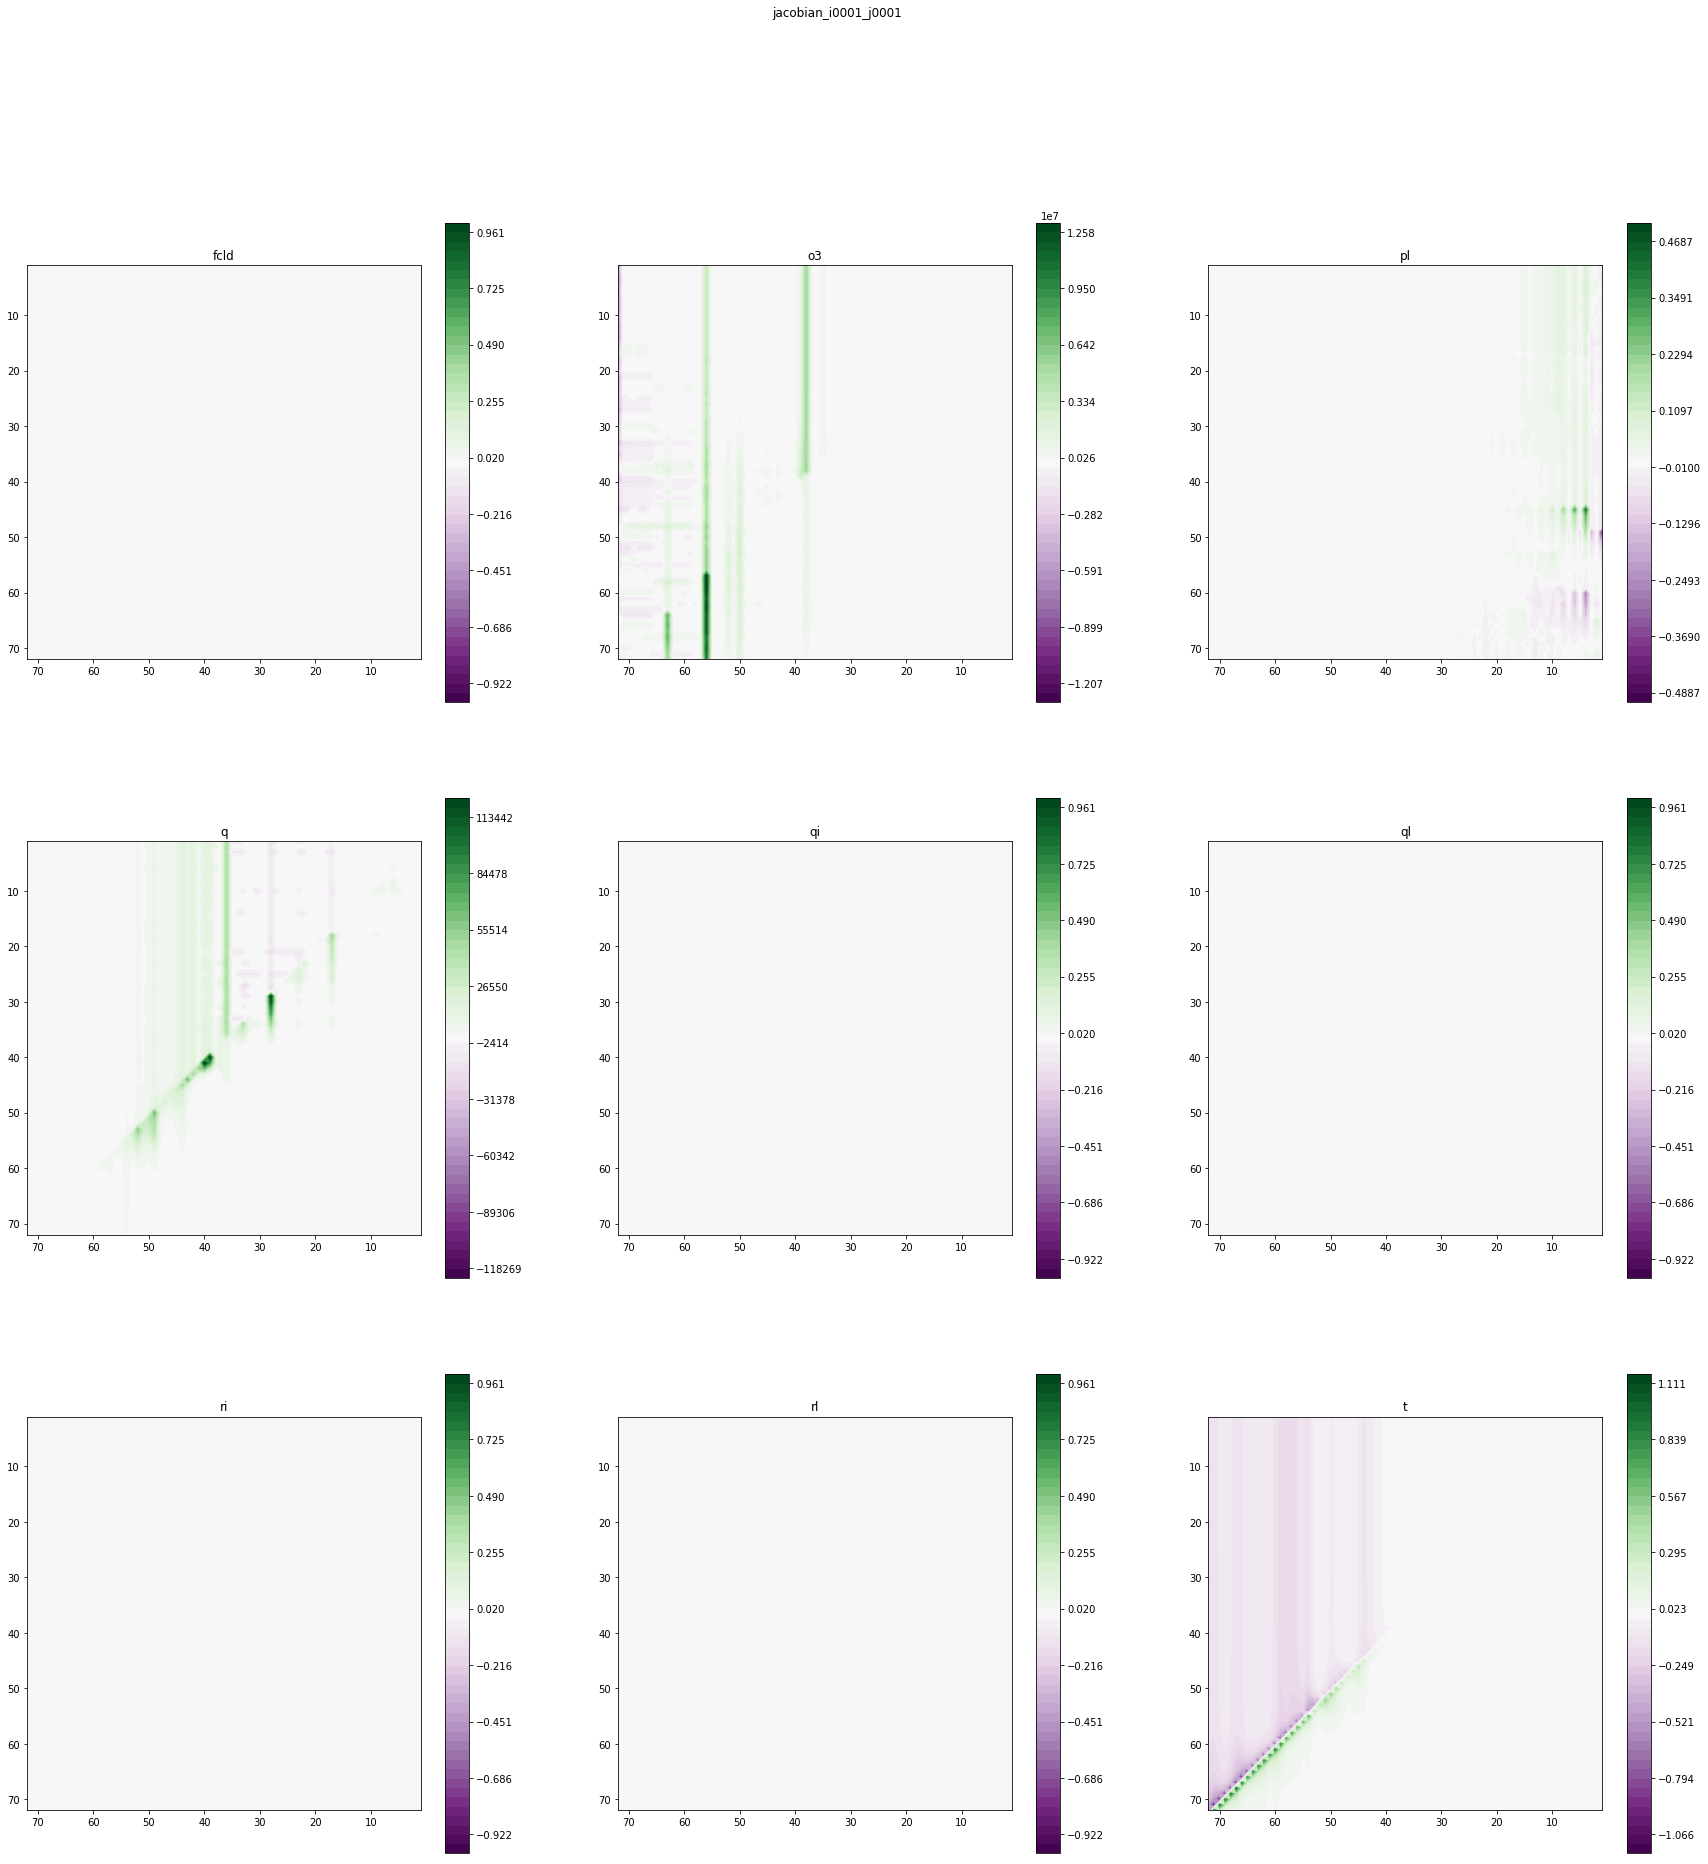

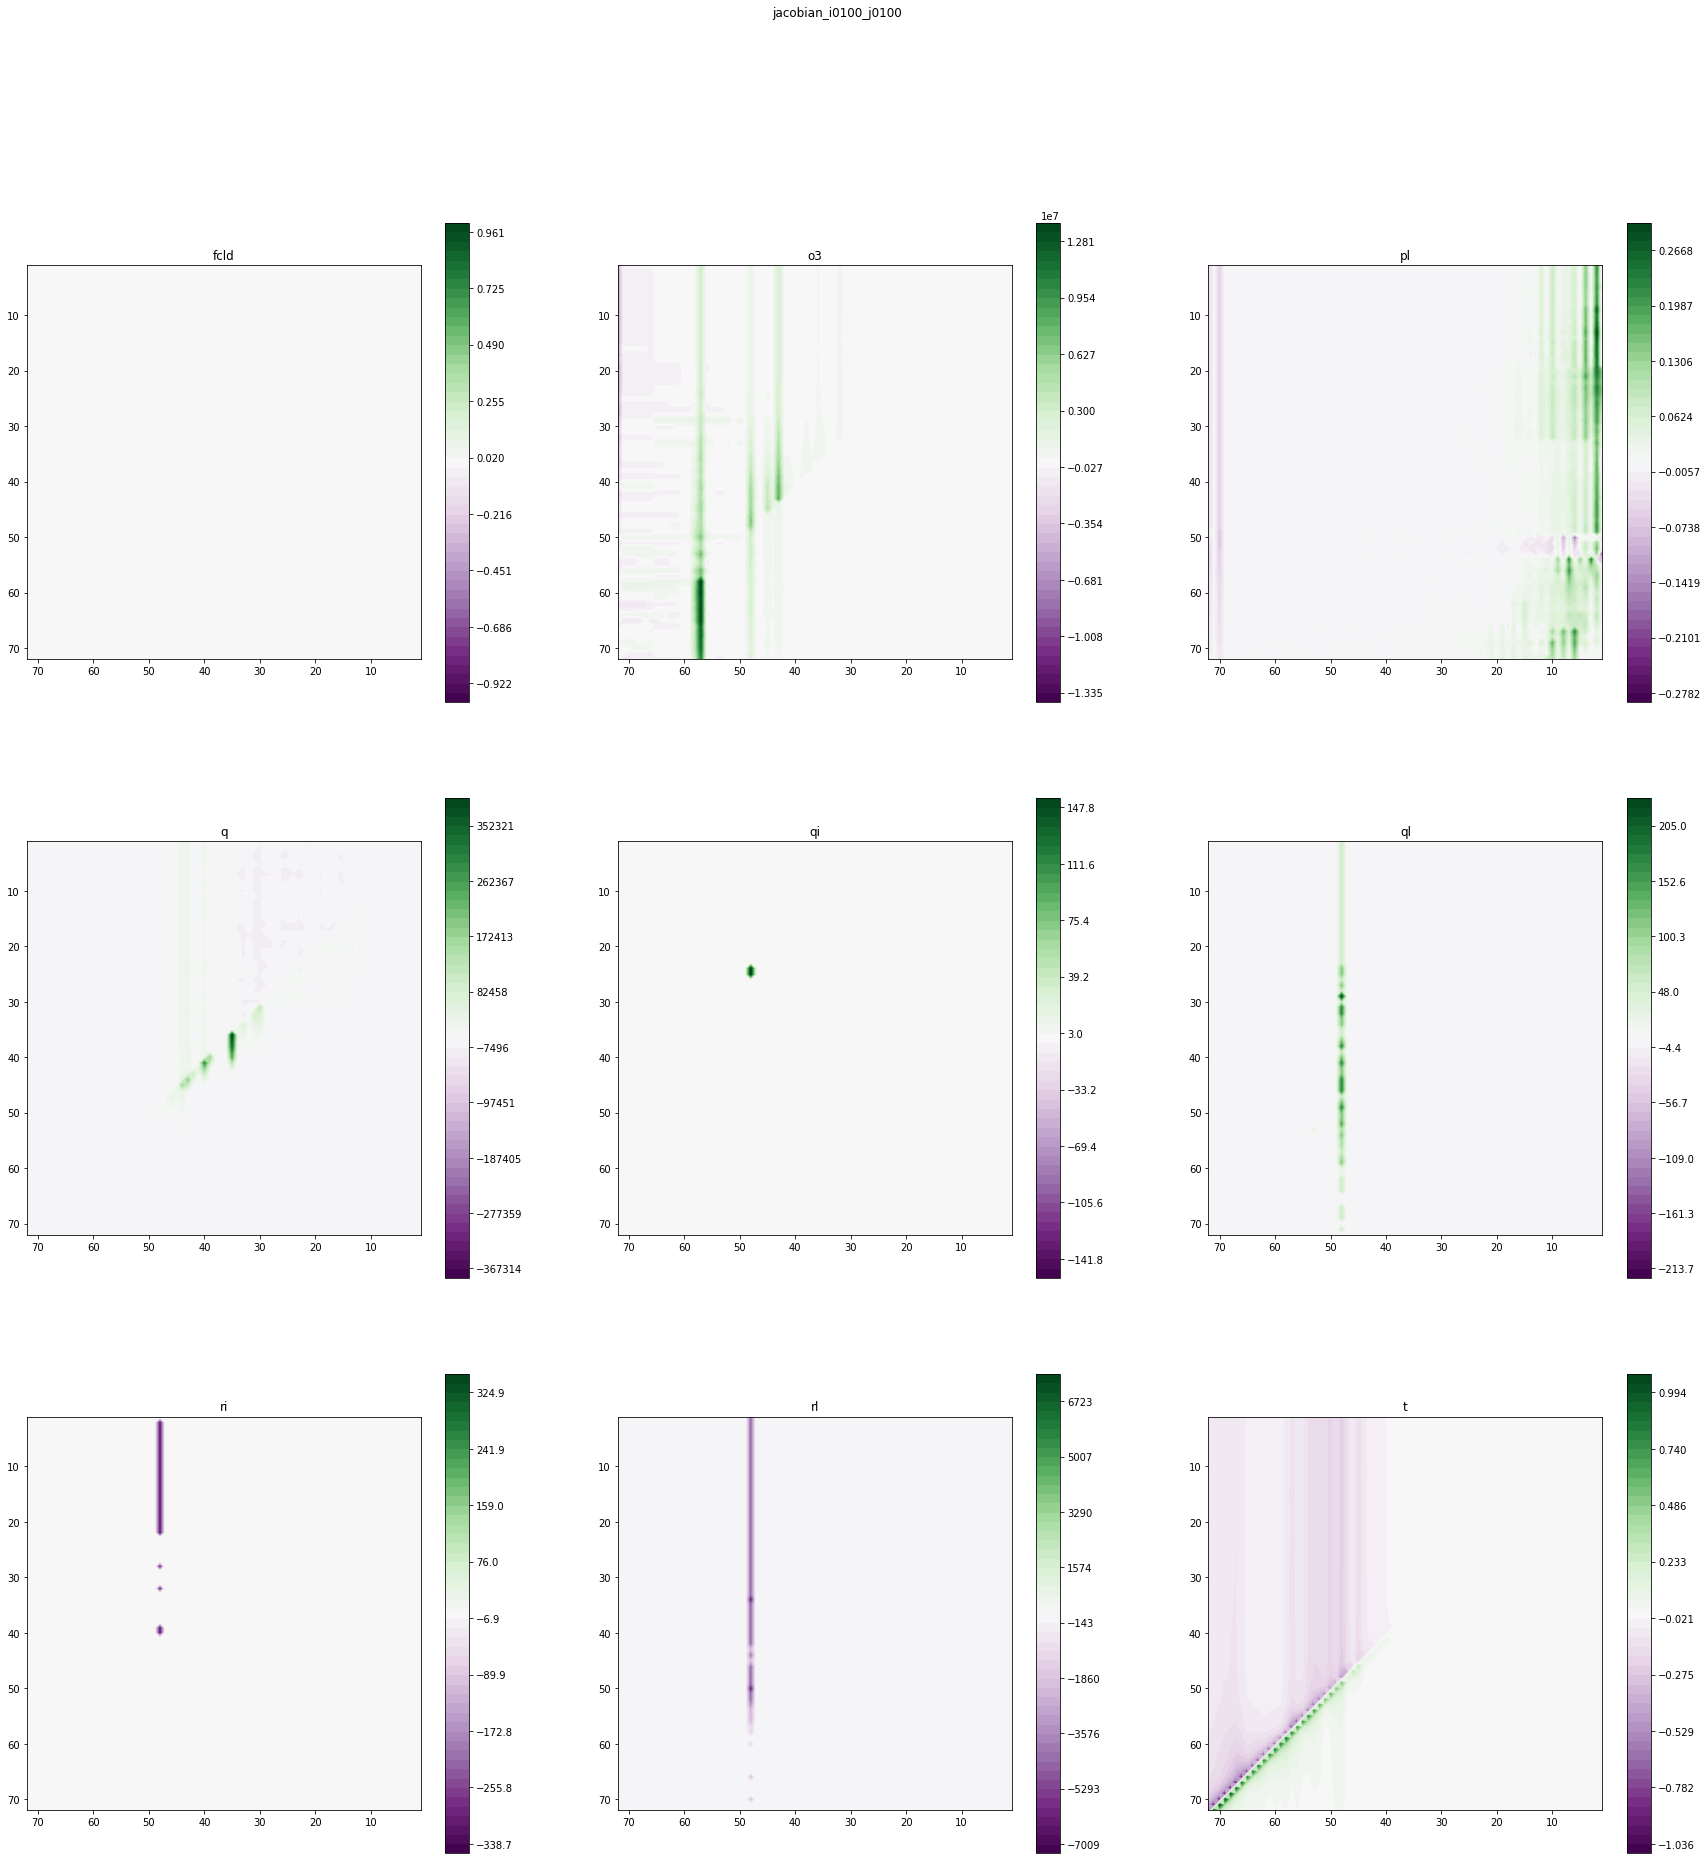

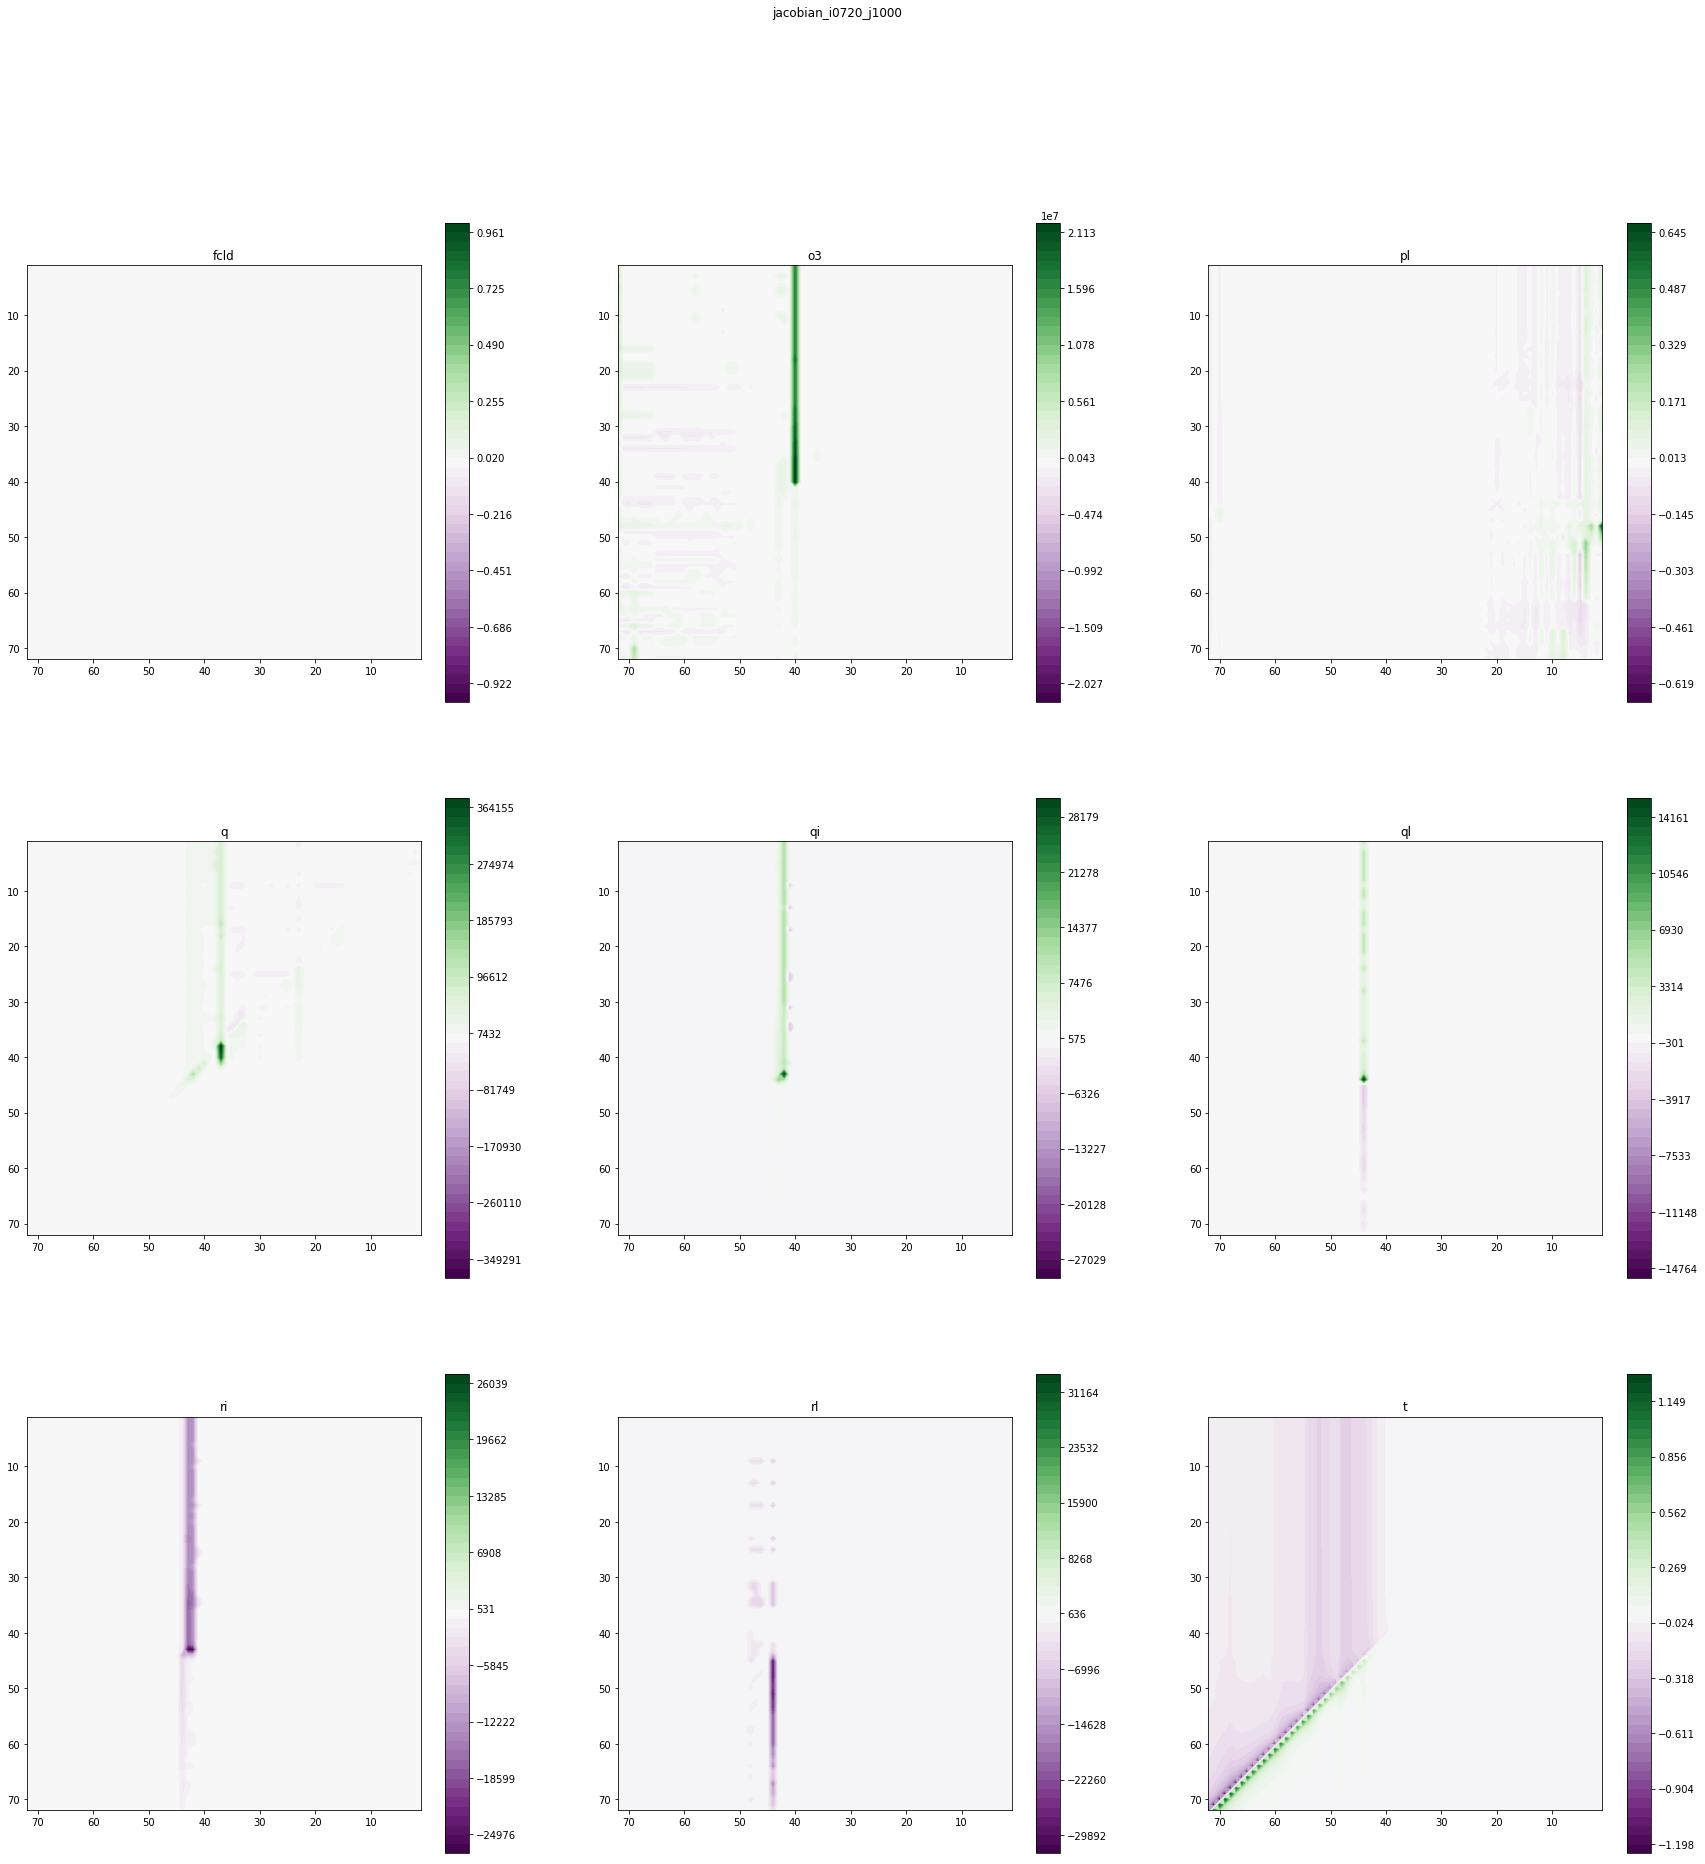

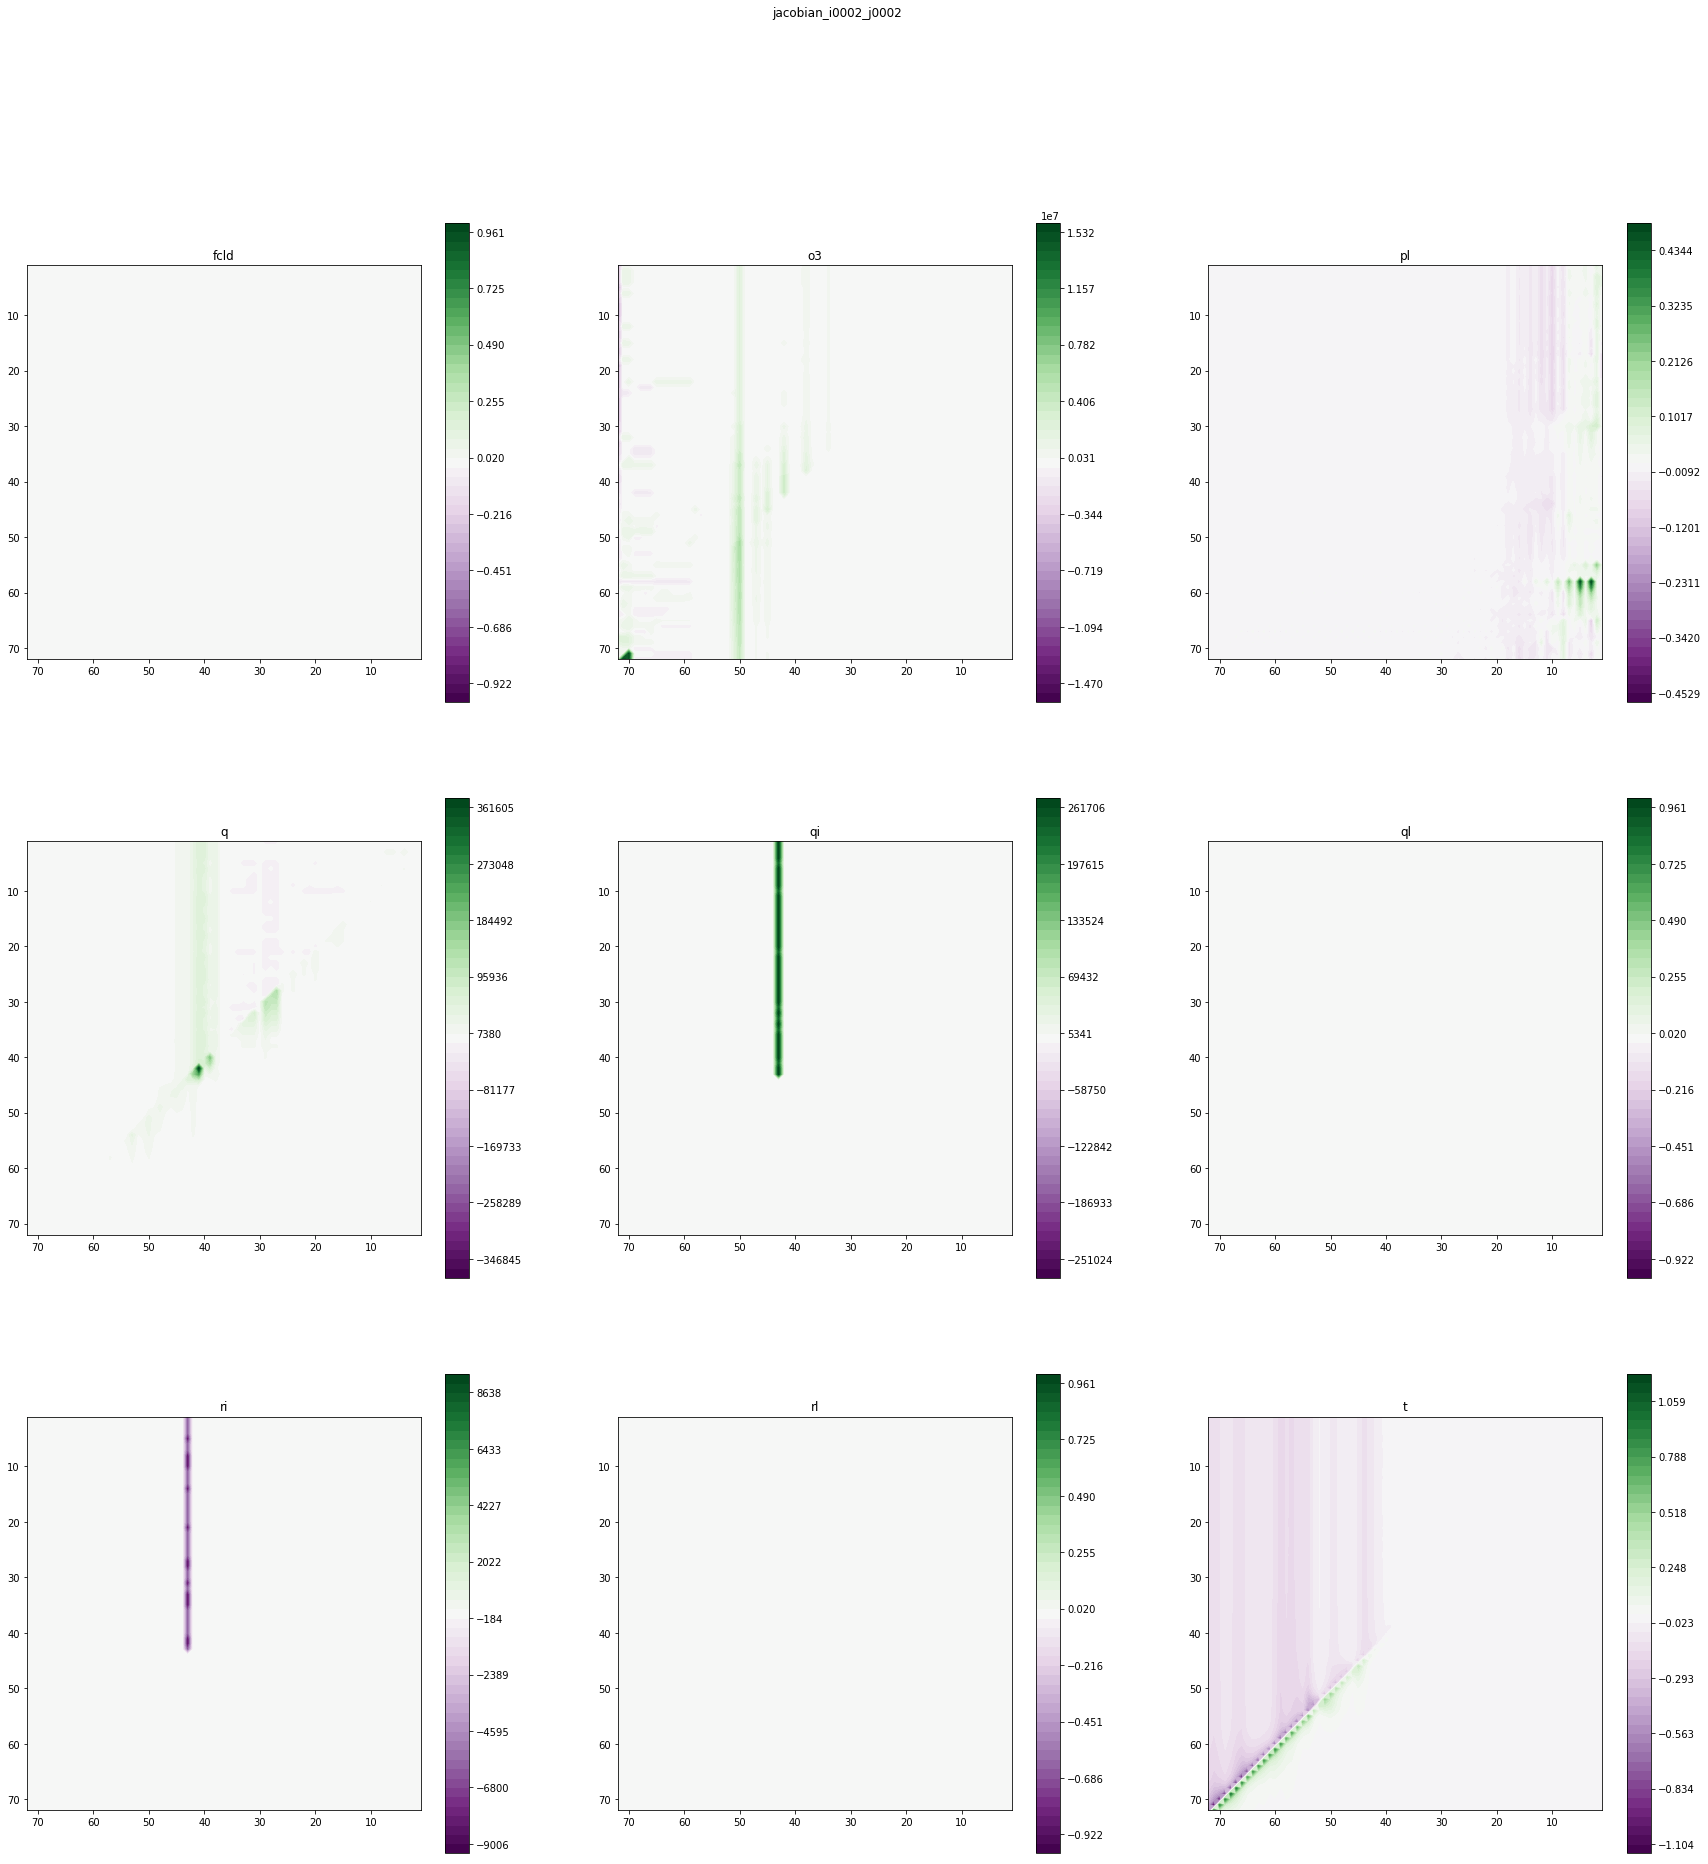

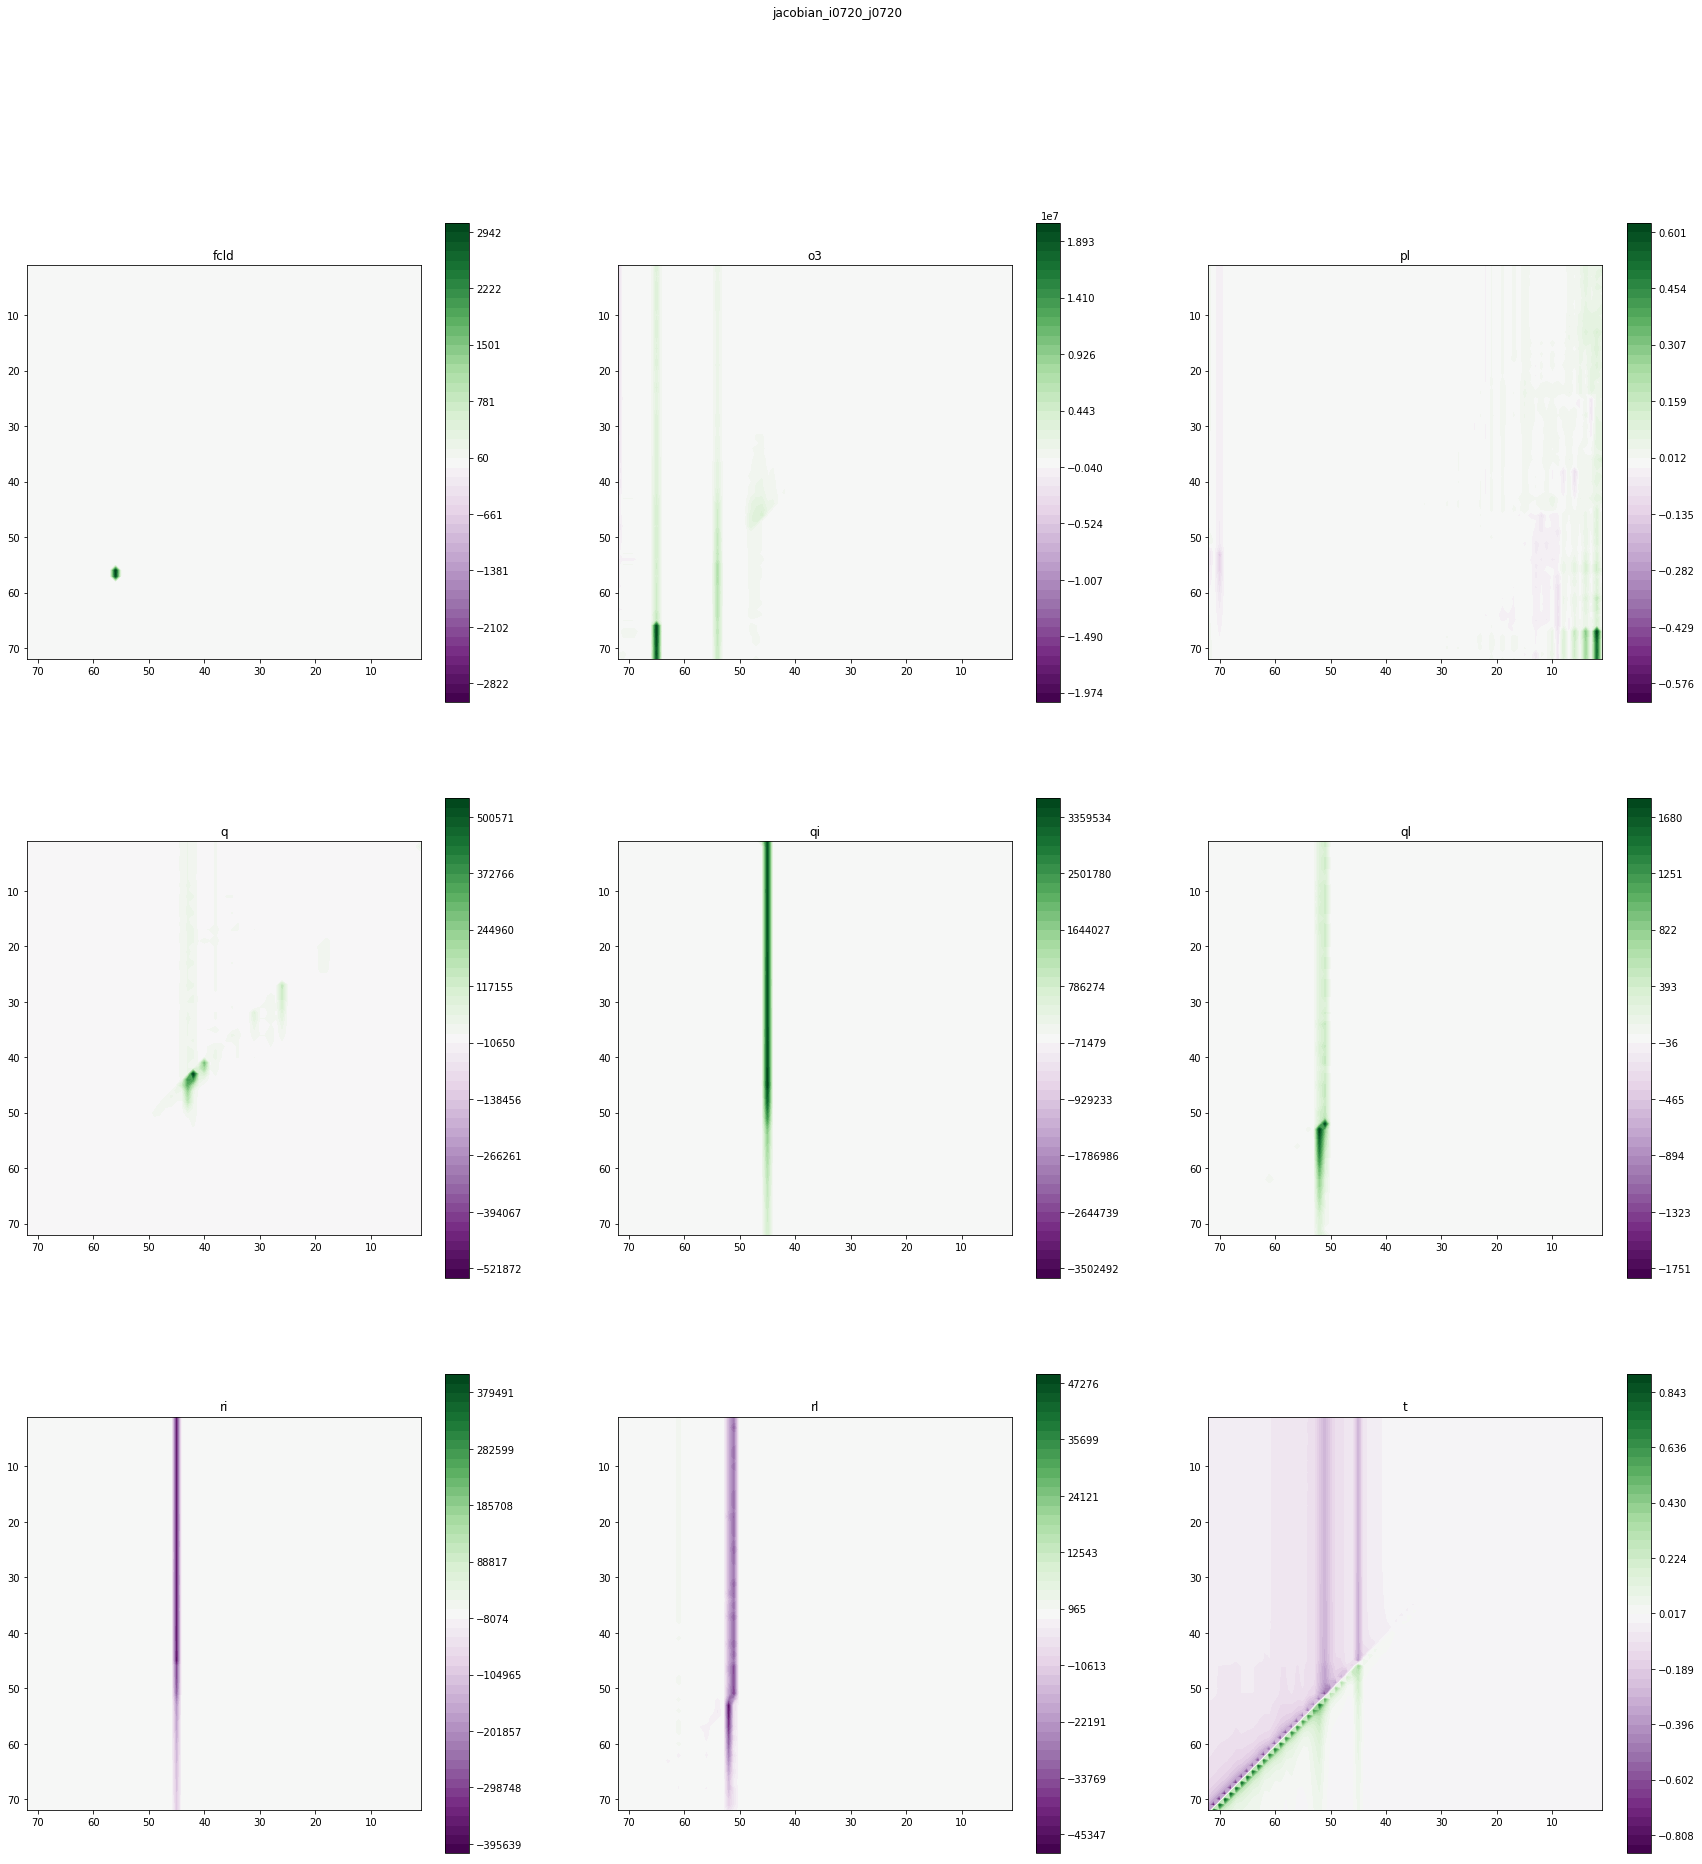

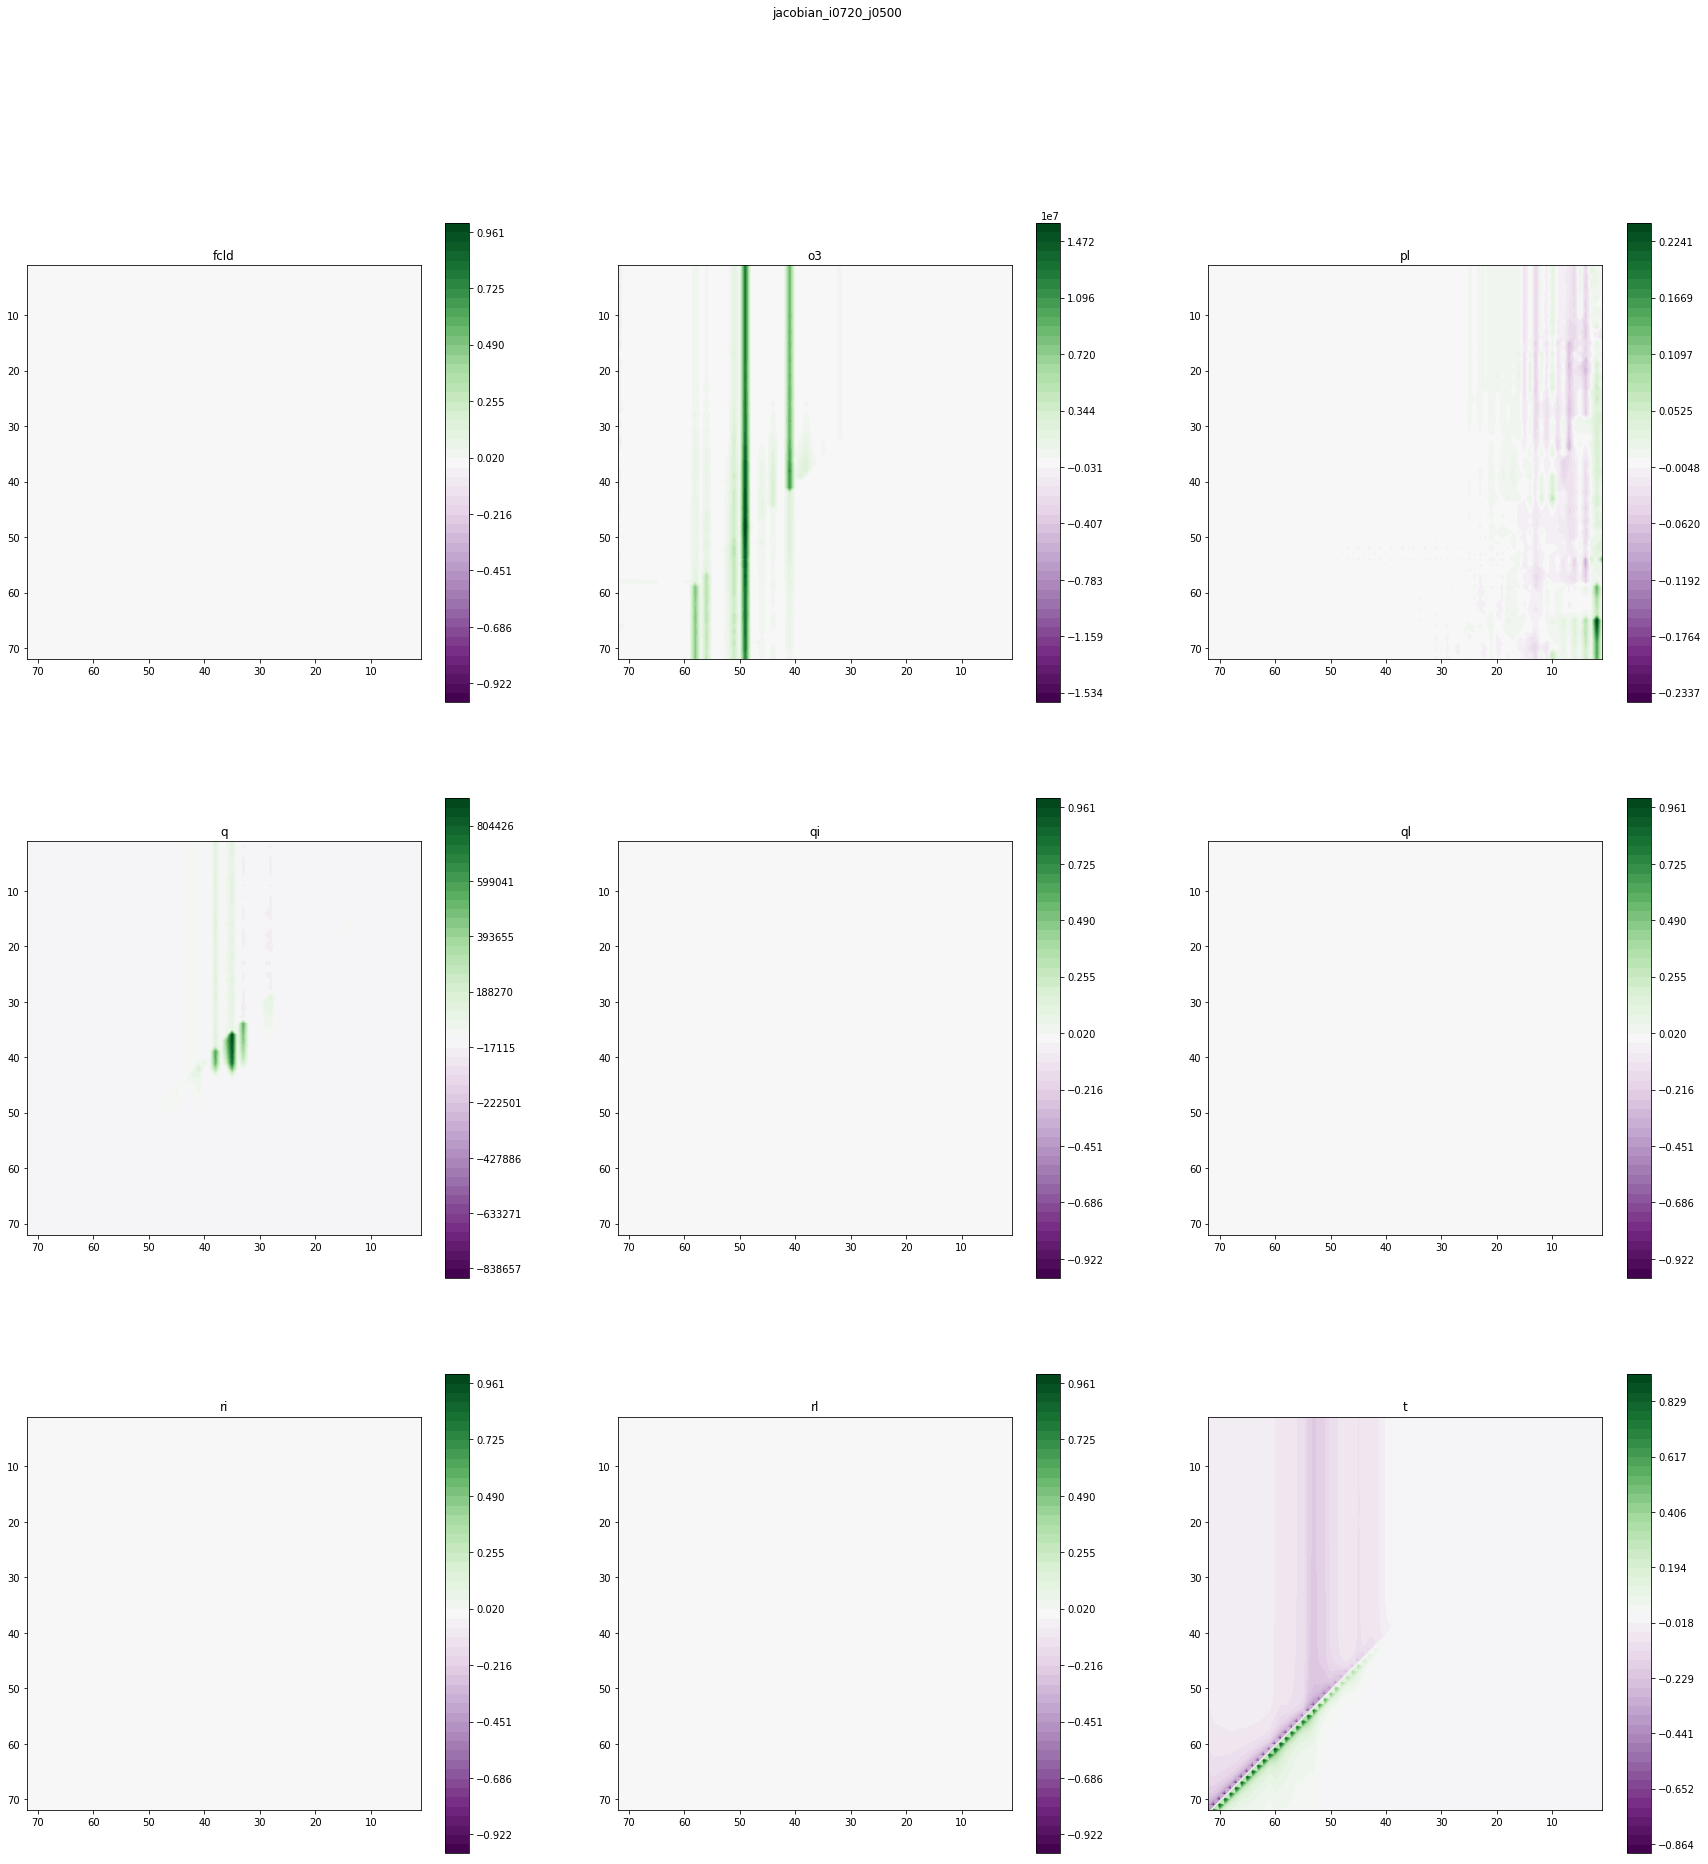

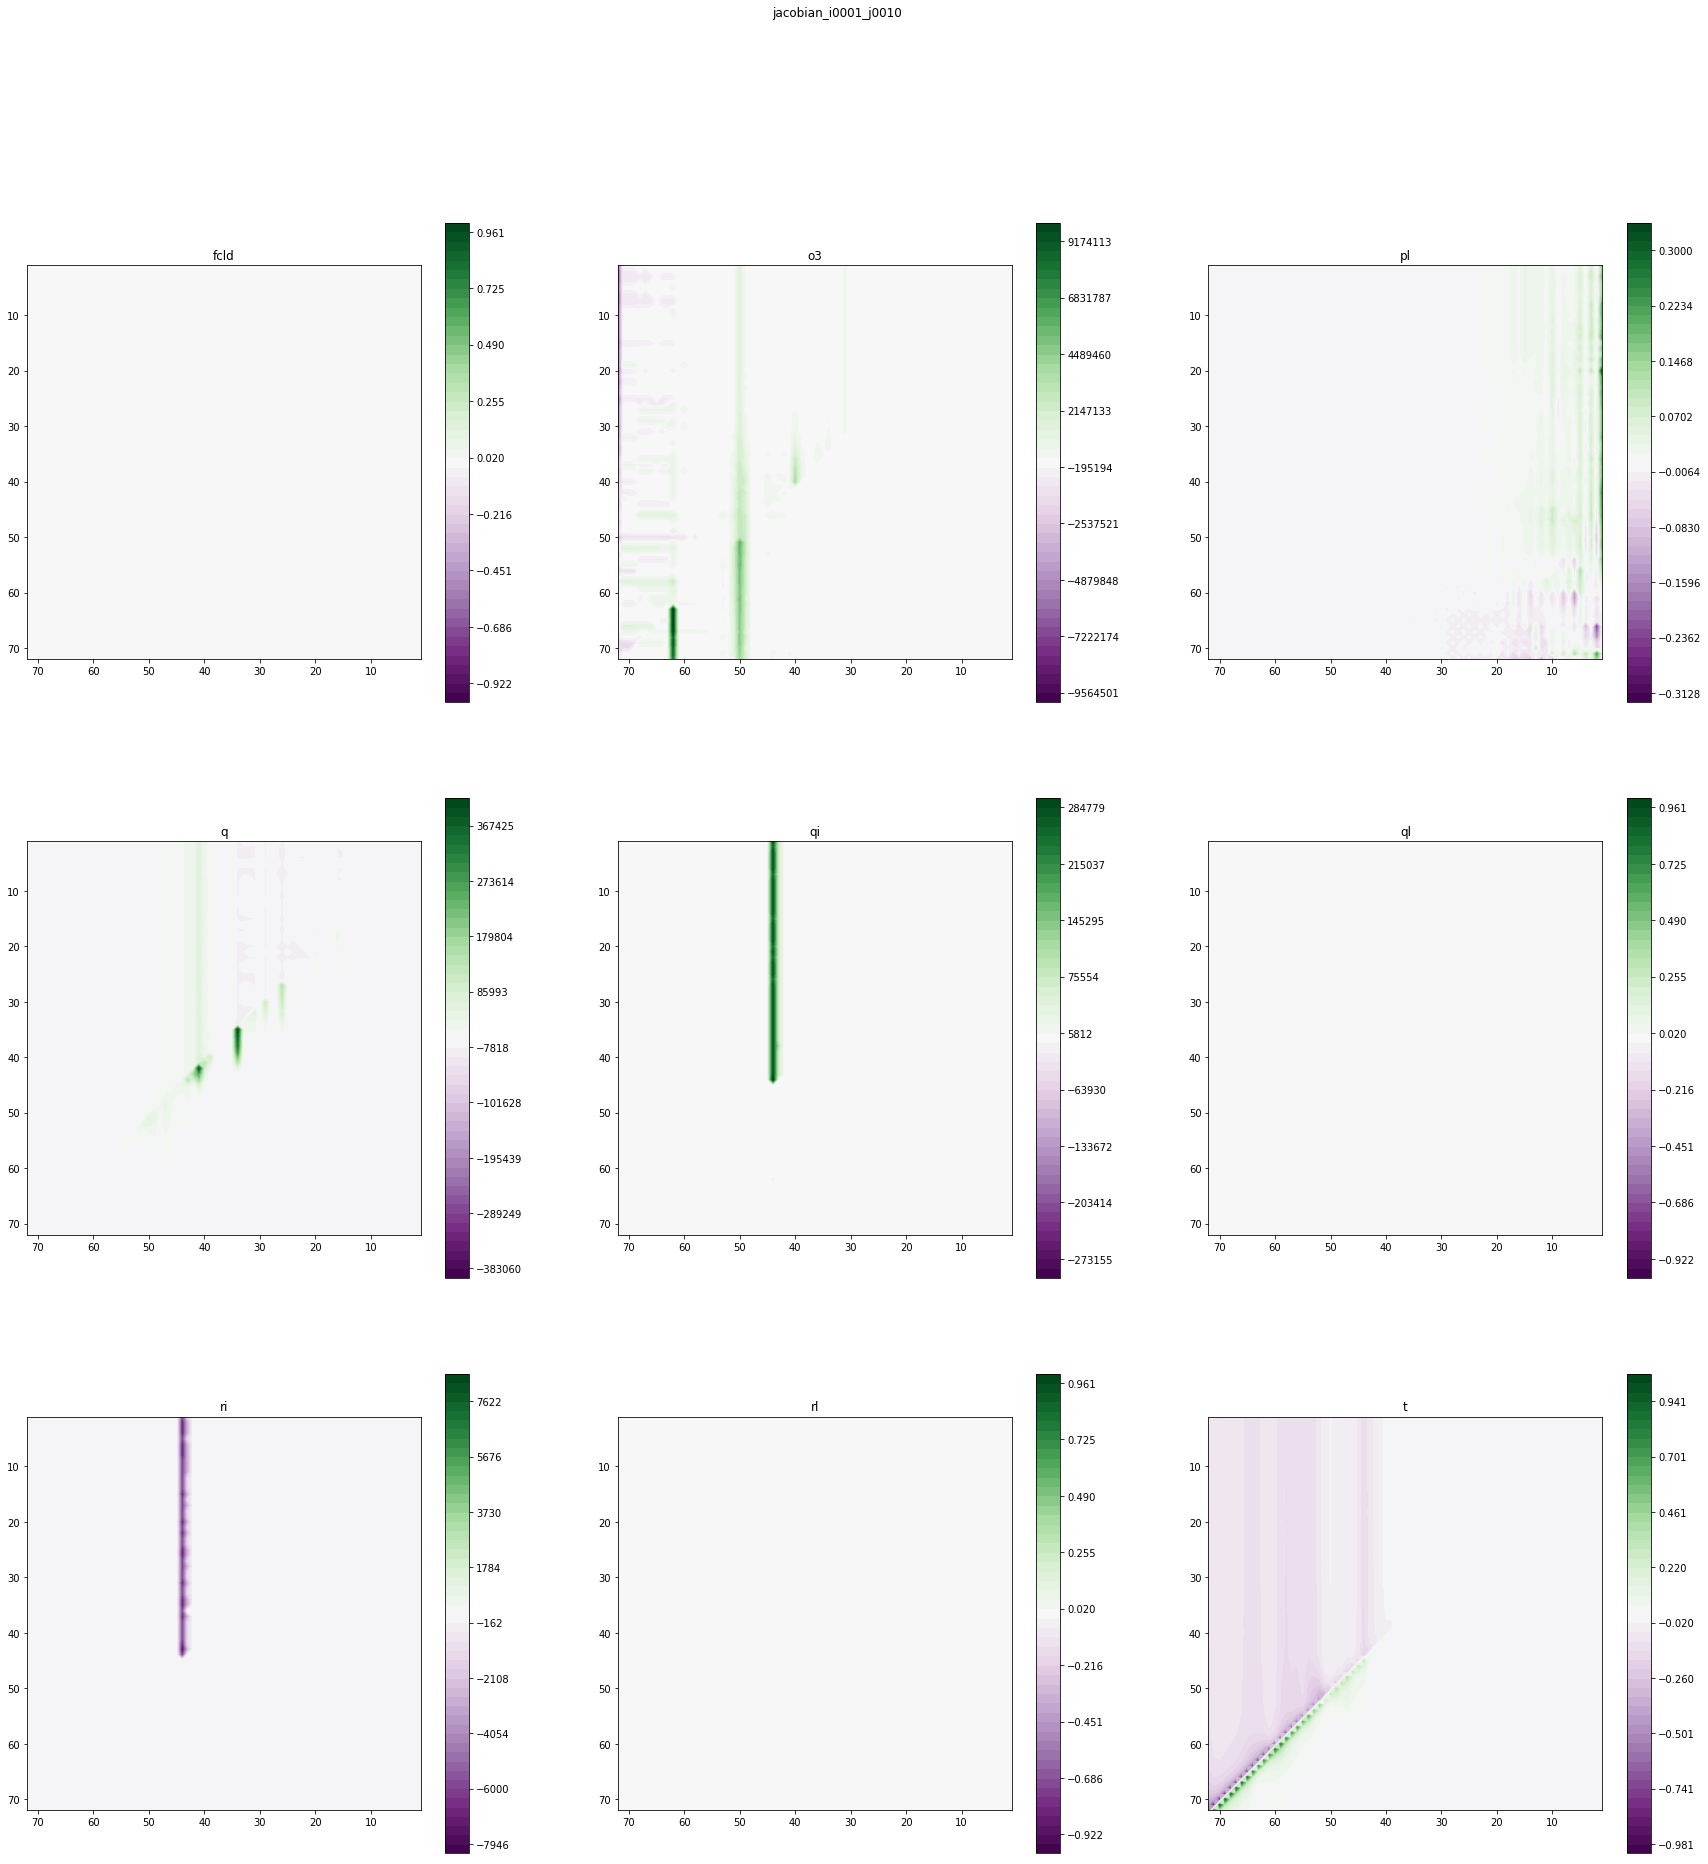

In [39]:
for i,J in enumerate(J_fortran):
#    if 'i0720_j0500' in profiles[i]:
    F=F_and_plots(figsize=(30,30), shape=(3,3))
    F.f.suptitle(profiles[i])
    Sep_Var_show(F,J, header_x)
    F.f.savefig(os.path.join(o_path , profiles[i] + '_000gt.jpg'))
    
    #Plot_Batch(xnc4[[i]], header_x)
    #plt.savefig(profiles[i]+'_input.jpg')

In [31]:
def PerturbatedOutputs(Mlist,x, dt):
    """
    Compute the Jacobian of x
    x has shape (1, lev, n_var)
    M product an output of size (1, lev)
    """
    _, lev, n_var= x.shape
    Jac = np.zeros((n_var, lev, lev))
    P0 = CumSum( -medium_pred(Mlist, x) )
    P1 = P0.copy()*0
    # could be more optimize [l steps instead of l*n_var]
    # Using one pred of size lev*n_var produce odd result, lev*header_x pred
    # which is not optimal
    for v in range(n_var):
        for l in range(lev):
            x0 = x.copy()
            pert = x[0,l,v]/dt
            x0[0, l, v] += pert
            P1 = CumSum(-medium_pred(Mlist, x0))
            Jac[v,l,:] = P1
    return Jac

xi = xnc4[[0]]
P0 = np.expand_dims(CumSum( -medium_pred([M], xi) ), axis=-1)
Pfs = PerturbatedOutputs([M], xi, 1000)
Pfs = Pfs.reshape(10*72,72)    
Pfs =np.expand_dims(Pfs, axis=-1)
data = np.arange(1,10)*72+42
Plot_Batch(Pfs[-72:] - P0,['flx'])
Plot_Batch( Pfs[[646+73]] - P0, ['flx'])

In [ ]:
F=F_and_plots(figsize=(30,30), shape=(3,3))
Sep_Var_show(F,J0, header_x)
F.f.suptitle("Unet");
F.f.savefig(profile[p_use]+'_jacob_unet'+'.jpg')

In [ ]:
F=F_and_plots(figsize=(30,30), shape=(3,3))
F.f.suptitle('FullyC')
Sep_Var_show(F,J1, header_x)
F.f.savefig(profile[p_use]+'_jacob_fullyC'+'.jpg')

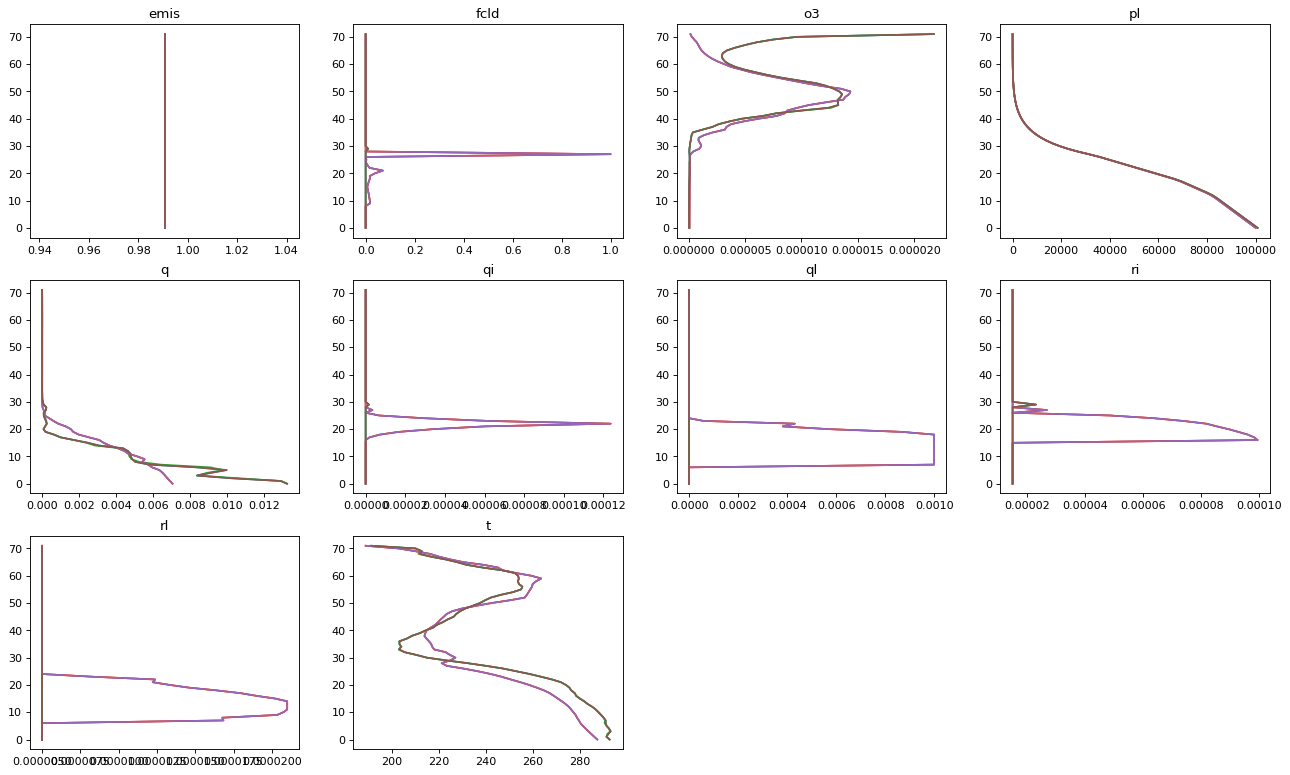

In [151]:
Plot_Batch(xnc4, header_x)

In [ ]:
for i,J in enumerate(J_fortran):
    F=F_and_plots(figsize=(30,30), shape=(3,3))
    F.f.suptitle(profiles[i])
    Sep_Var_show(F,J, header_x)
    Plot_Batch(xnc4[[i]], header_x)
    F.f.savefig(profiles[i]+'log_scaled.jpg')

/home/victor/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [54]:
B =  Basic_Generator(folder=data_folder, batch_size=batch_size, train=True, shuffle=0)

In [76]:
#########################
id_profile = 0
file1 = 'Data_net4/output_c4.txt'
plotfile = 'Data_net4/q2_cloud_'+str(id_profile)+'_.png'
plotfile_d = 'Data_net4/d_q2_cloud_'+str(id_profile)+'_.png'
#######################

def del_empty(l):
    id = 0
    while(id<len(l)):
        if(l[id]==''):
            del(l[id])
        else:
            id+=1
    return(l)
    
id=-1
Profiles = []
profile = np.zeros((3,2,73))
j0=0
for i,line in enumerate(open(file1)):
    l = line.rstrip('\n').strip(' ')
    l = l.split(' ')
    if(l[0]=='Profile'):
        j0=-3
        Profiles.append(profile.copy())
        profile = np.zeros((3,2,73))
        id=-1

    if(j0>=0):
        if(len(l)==1):
            id+=1
            j=0
        else:
            l = del_empty(l)
            if(l[0][0]=='-'):
                profile[0,id,j] = -float(l[0][1:])
            else:
                profile[0,id,j] = float(l[0])
            if(l[-1][0]=='-'):
                profile[1,id,j] = -float(l[1][1:])
            else:
                profile[1,id,j] = float(l[1])
            j+=1
    j0+=1
    
id_i = 100
id_j = 100

xnc4 = np.zeros((5,72,10))
xnc4[0] = Produce_x_nc4(F, id_i+100, id_j+100, header_x)
#xnc4[1] = Produce_x_nc4(F, id_i+200, id_j+100, header_x)
#xnc4[2] = Produce_x_nc4(F, id_i+300, id_j+100, header_x)
#xnc4[3] = Produce_x_nc4(F, id_i+400, id_j+100, header_x)
xnc4[4] = Produce_x_nc4(F, id_i+500, id_j+100, header_x)

Plot_Batch(xnc4, header_x)    

Profiles.append(profile)
Profiles = Profiles[1:]
Profiles = np.array(Profiles)
print(Profiles.shape)
#print((Profiles[:,0,[0]] - (Profiles[:,1,[0]])))
Profiles = np.swapaxes(Profiles[:, 1, [0], :], 2, 1)
DP = Profiles[:, 1:] - Profiles[:, :-1]

(48, 3, 2, 73)


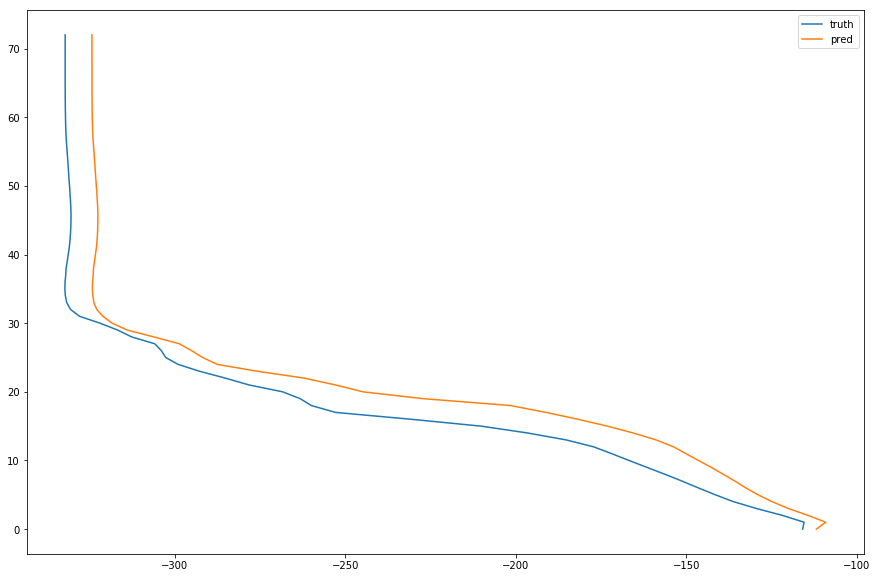

In [73]:
Plot_diff(F_and_plots(shape=(1,1)), Profiles[[0]], Profiles[[2]], header_y=['flx'], lev=73, J=[0])

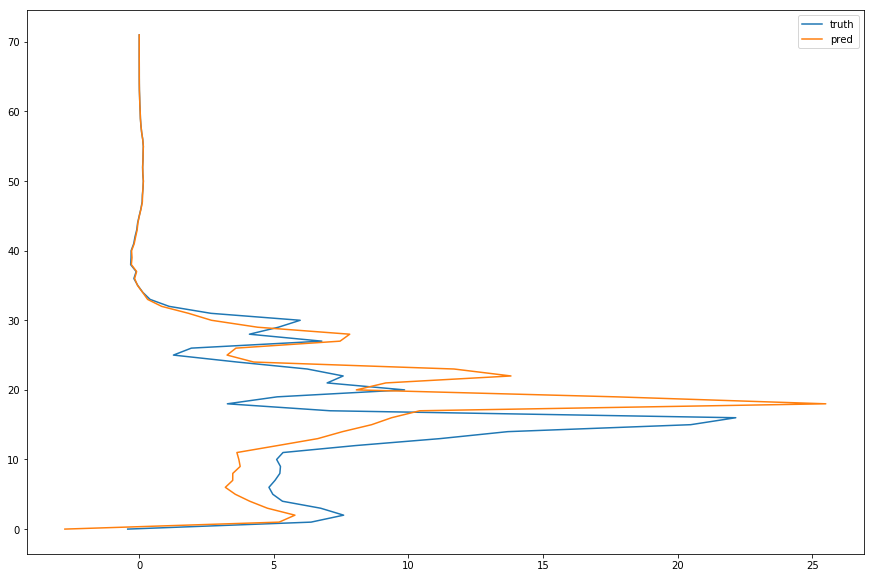

In [75]:
Plot_diff(F_and_plots(shape=(1,1)), DP[[0]], DP[[2]], header_y=['flx'], lev=72, J=[0])

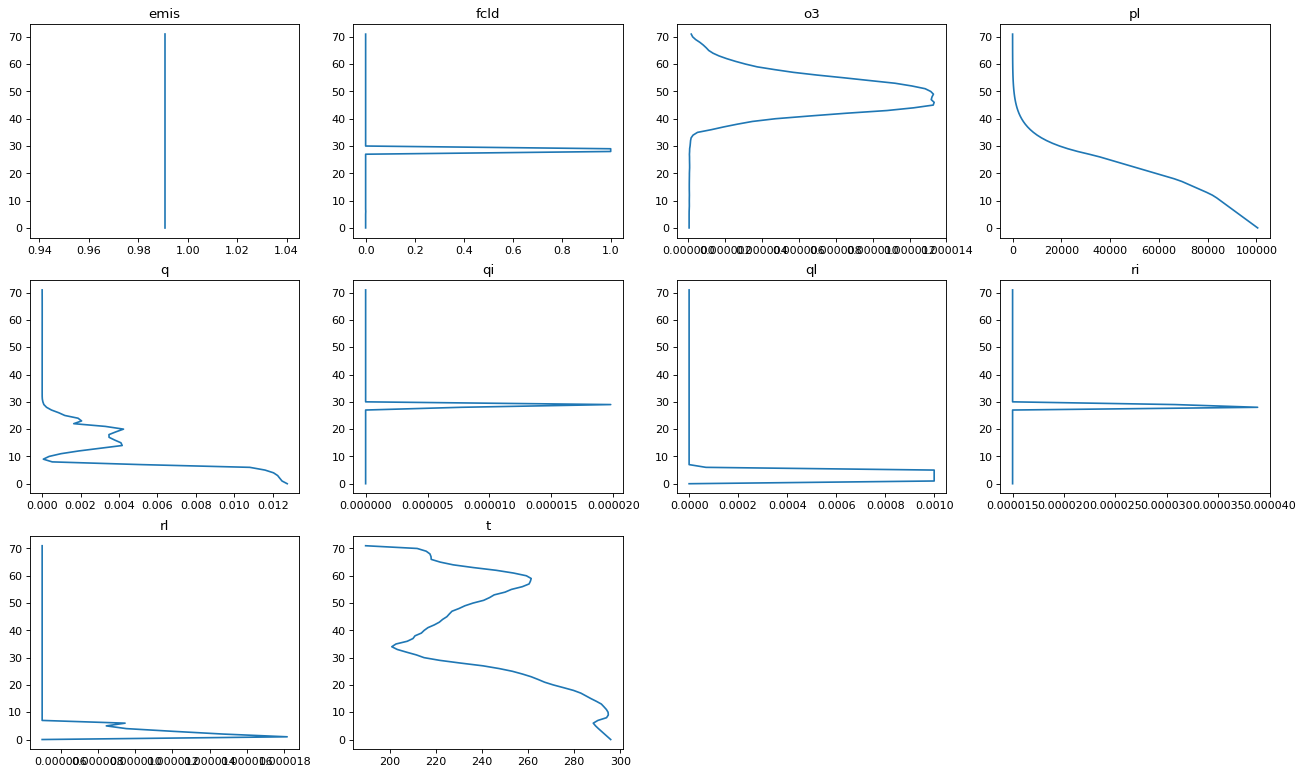

In [120]:
F = Dataset('Data_net4/401_600/f522_dh.trainingdata_in.lcv.20190401_0600z.nc4')

xnc4 = Produce_x_nc4(F, 720, 31, header_x)
Plot_Batch(np.expand_dims(xnc4,axis=0), header_x)

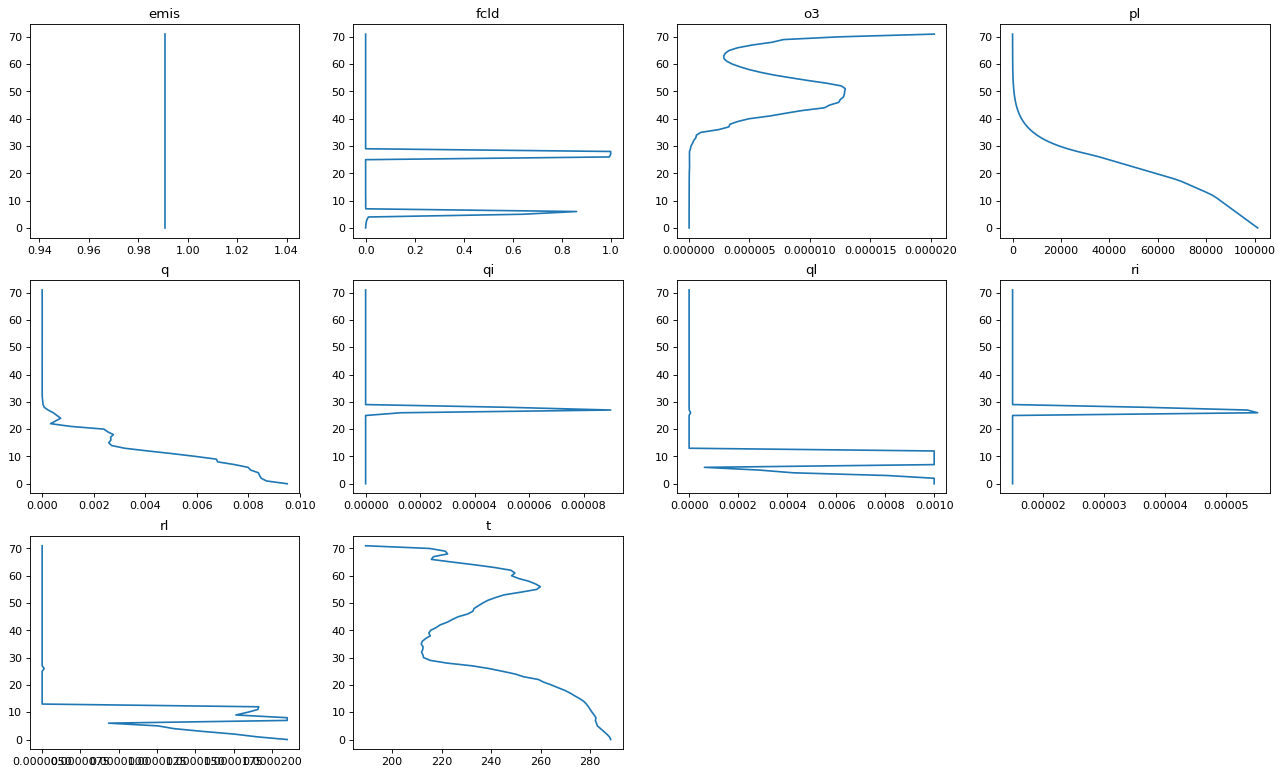

In [102]:
Plot_Batch(train_generator[19440][0][[30]], header_x)

In [96]:
import tqdm

G=[]
for i in tqdm.tqdm(range(72)):
    gradients = K.gradients(M.get_output_at(0)[:,i],M.input)
    gradients_f = K.function( [M.input] , [gradients[0]] )
    G.append(gradients_f([x[[0]]])[0])

G=np.array(G)
G = G[:,0,:,:]
G = G.swapaxes(1,2)
G = G.swapaxes(0,1)
Gorigin =G.copy()
for i in range(G.shape[0]):
    G[i] = G[i].T

100%|██████████| 72/72 [02:28<00:00,  3.14s/it]


In [112]:
np.save("NoPrepopGrad0001_0001", G)

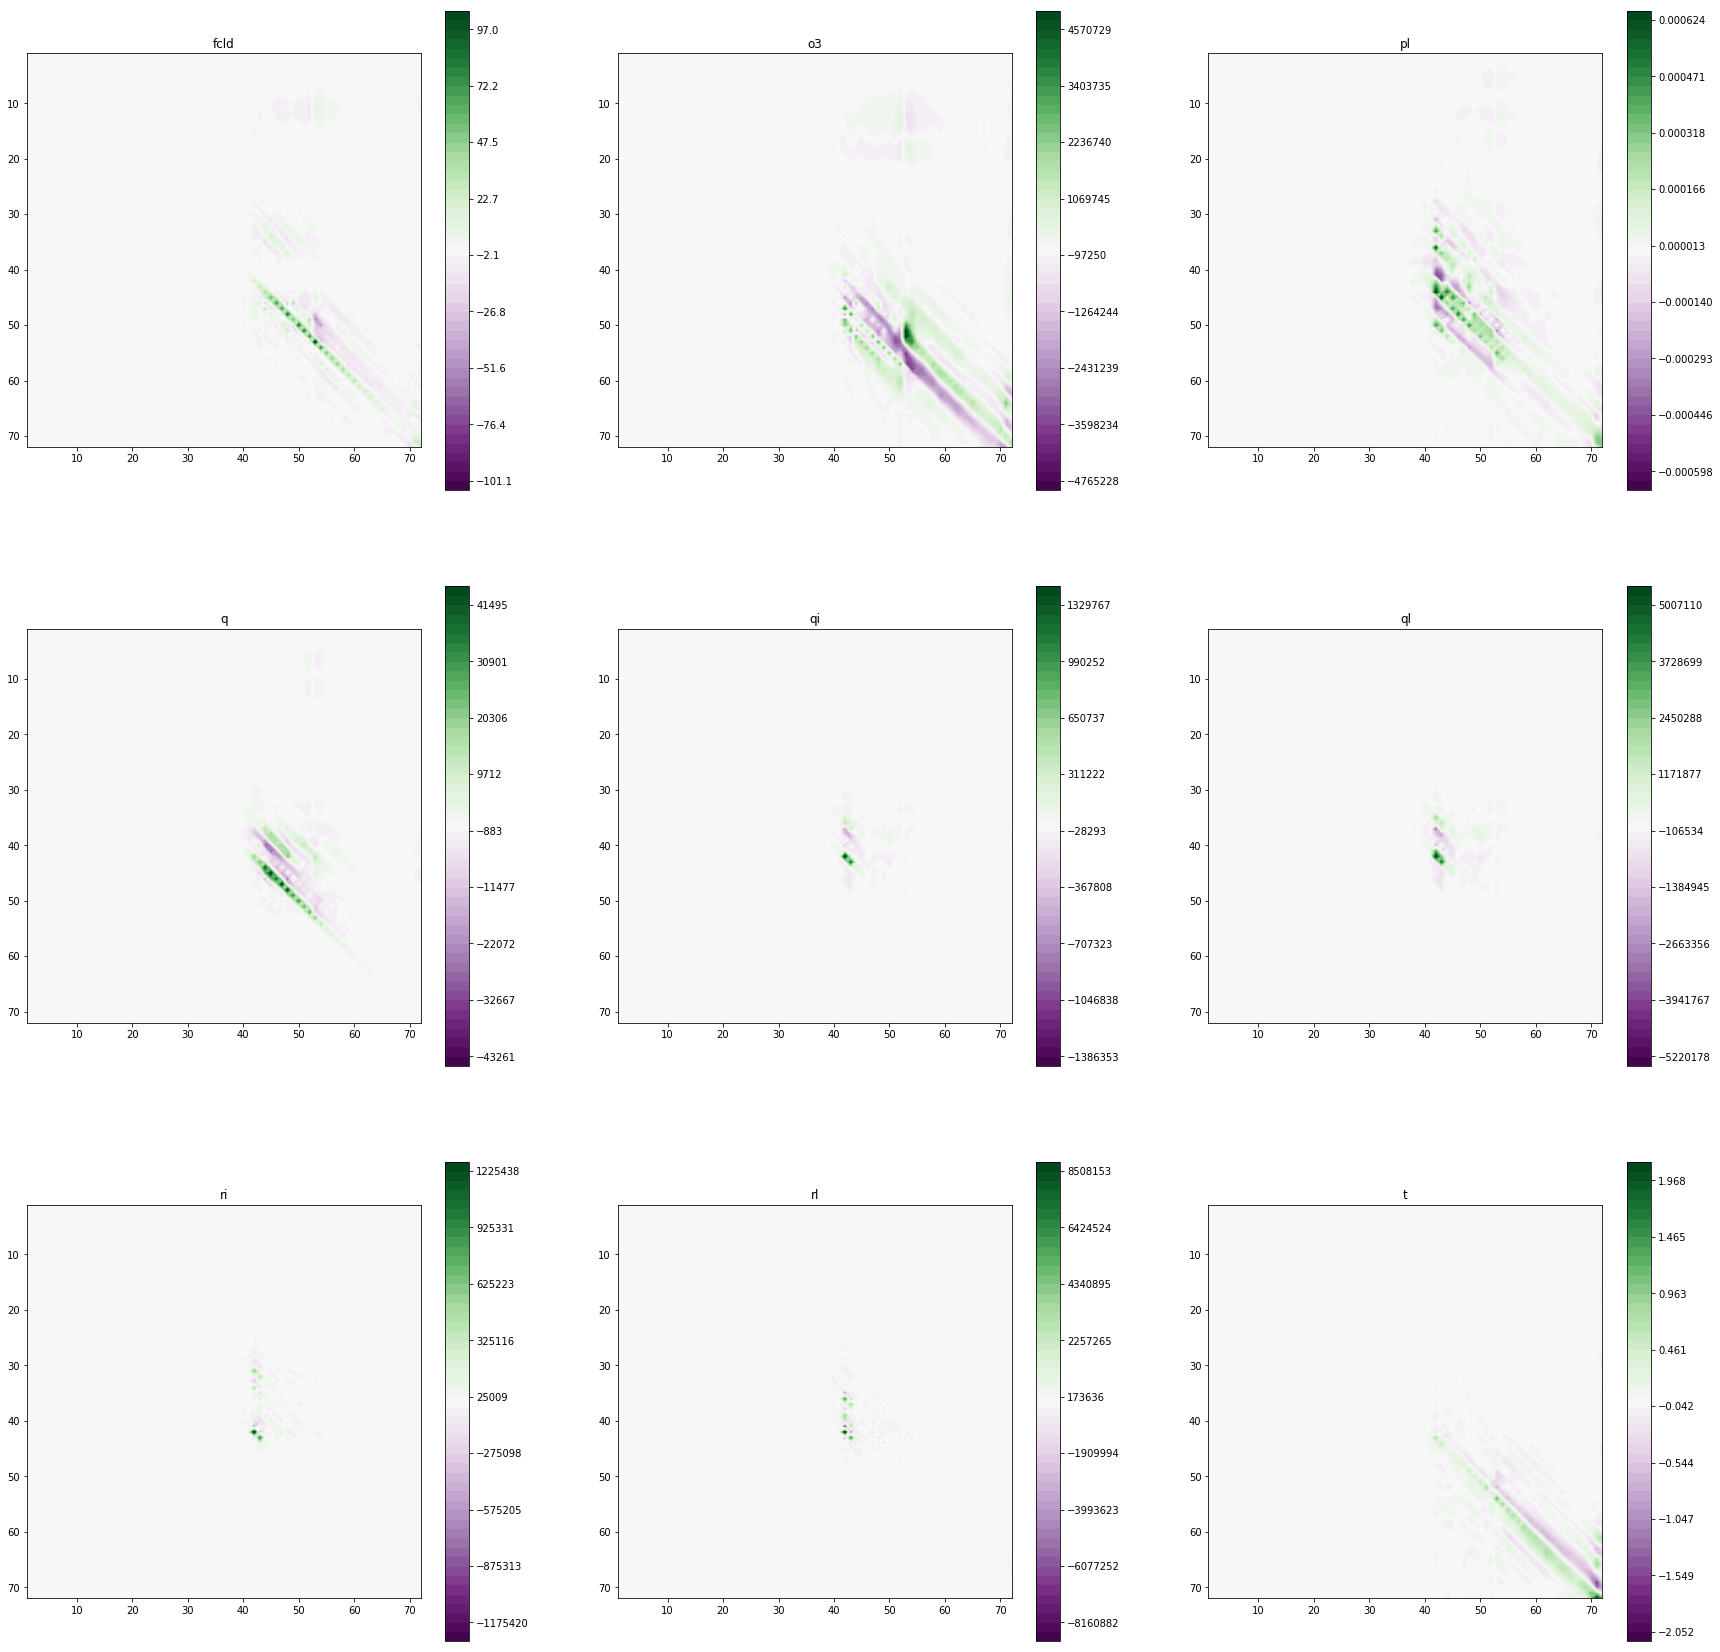

In [122]:
F=F_and_plots(figsize=(30,30), shape=(3,3))
Sep_Var_show(F,G, header_x)

In [98]:
import tqdm 
x=xmin.copy()

_, lev, n_var= x.shape
J = np.zeros((lev)) 

emis = x[0,0,0]
emis = np.array([emis]).reshape(-1,1)

x0 = x[:,:,1:]
    
repeat = lambda x : K.repeat(x, 72)
concat0 = lambda x : K.concatenate([x,x0], axis=-1)
Lcopy = keras.layers.Lambda(repeat)
Lcont = keras.layers.Lambda(concat0)
m2 = keras.Sequential()
m2.add(Lcopy)
m2.add(Lcont)
m2.add(M)
m2.predict(emis)
Gemis=[]
for i in tqdm.tqdm(range(72)):
    gradient2s = K.gradients(m2.get_output_at(0)[:,i], m2.input)
    gradient2s_f = K.function( [m2.input] , [gradient2s[0]] )
    Gemis.append(gradient2s_f([emis])[0])

100%|██████████| 72/72 [04:22<00:00,  4.87s/it]


In [99]:
Gemis = np.array(Gemis)[:,:,0].T

Text(0.5, 0.98, 'Emis Grad')

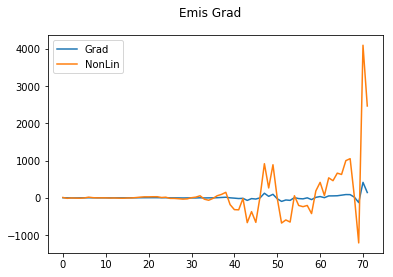

In [100]:
plt.plot(-Gemis[0]);
plt.plot(J_emis[0]*10000)
plt.legend(['Grad', 'NonLin'])
plt.suptitle('Emis Grad')

In [132]:
import tensorflow as tf
emis = tf.cast([emis], tf.float32)
#emis = tf.reshape(emis, shape=(1,1))

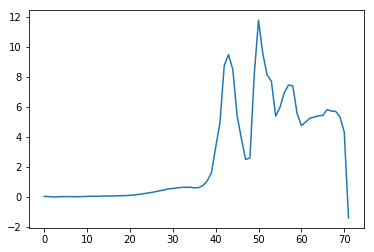

In [166]:
plt.plot(y[0]);

In [64]:
G0 = np.load('Tf_grad_best_model.npy')

In [230]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.mlab import bivariate_normal

def Sep_Var_show(F,J, header_x, T=True):
    """
    Show the Jacobian of each variable
    F : F and Plot class element of len len(header_x)
    header_x : list of variables
    J gradient of size (lev, n_var*lev)
    """
    l , c = J.shape
    n_var = len(header_x)
    lev = c//n_var
    for i in range(len(header_x)):
        img = J[:, lev*i:lev*(i+1) ]
        maxf = np.max(np.abs(img))
        if maxf == 0:
            maxf = 1.0
        incf = 2*maxf/51.
        clevs = np.arange(-maxf,maxf+incf,incf)

        F[i].imshow(img, 
                    cmap='PRGn'
                   )
        #im = ax.contourf(z, z, np.transpose(field), clevs, cmap = 'PRGn')  

        F[i].set_title(header_x[i])

def Jacobian_relative(M,x, dt):
    """
    Compute the Jacobian of x
    x has shape (1, lev, n_var)
    M product an output of size (1, lev)
    """
    _, lev, n_var= x.shape
    Jac = np.zeros((n_var, lev, lev))
    P0 = np.zeros((lev*n_var, lev))
    # could be more optimize [l steps instead of l*n_var]
    # Using one pred of size lev*n_var produce odd result, lev*header_x pred
    # which is not optimal
    
    for v in range(n_var):
        for l in range(lev):
            x0 = x.copy()
            x0[0,l , v] += x[0,l,v]/dt
            P0[v*lev+l] = M.predict(x0)
    P1 = M.predict(x)
    return (P1-P0).T


def Sep_Var_Gradient(J, header_x):
    """
    Rshape J of size(lev, header_x*lev) to size (header_x, lev, lev)
    """
    l,c = J.shape
    n_var = len(header_x)
    lev = c//n_var
    J = [J[:, lev*i:lev*(i+1) ] for i in range(len(header_x))]
    return(np.array(J))

Jr = Jacobian_relative(M,xmin, 1000)

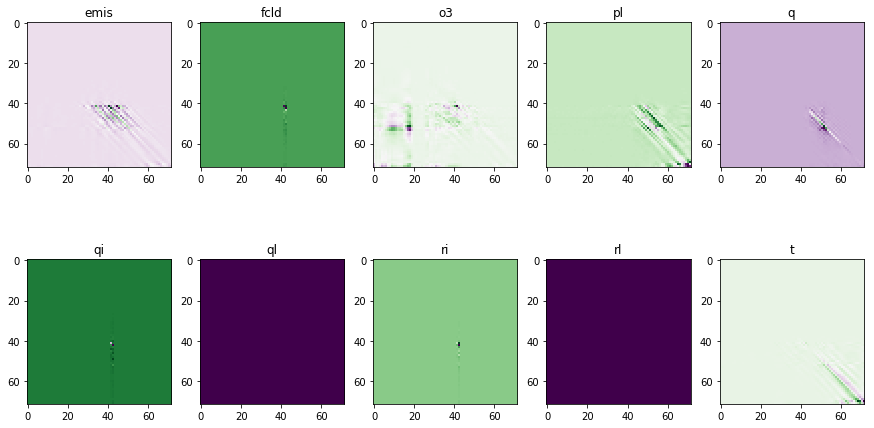

In [232]:
F=F_and_plots(figsize=(15,8), shape=(2,5))
Sep_Var_show(F,Jr, header_x)

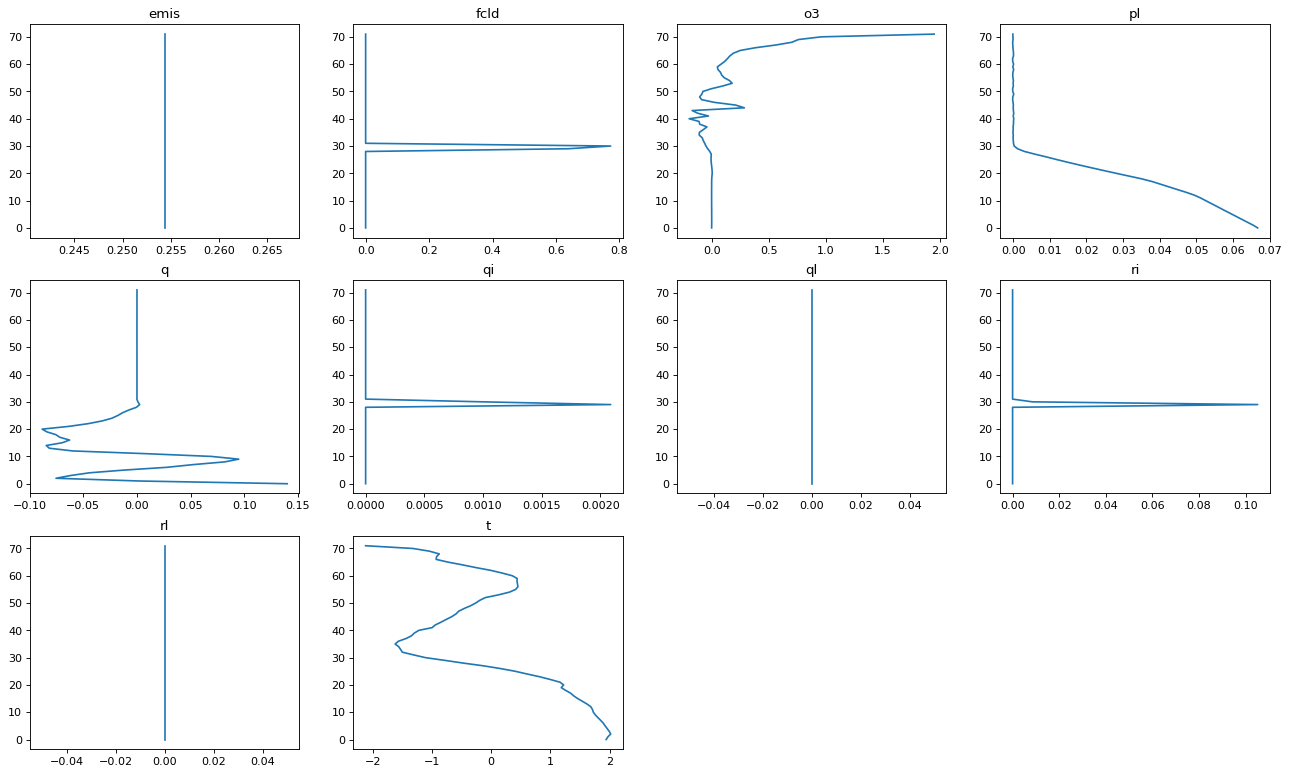

In [224]:
Plot_Batch(xmin, header_x)

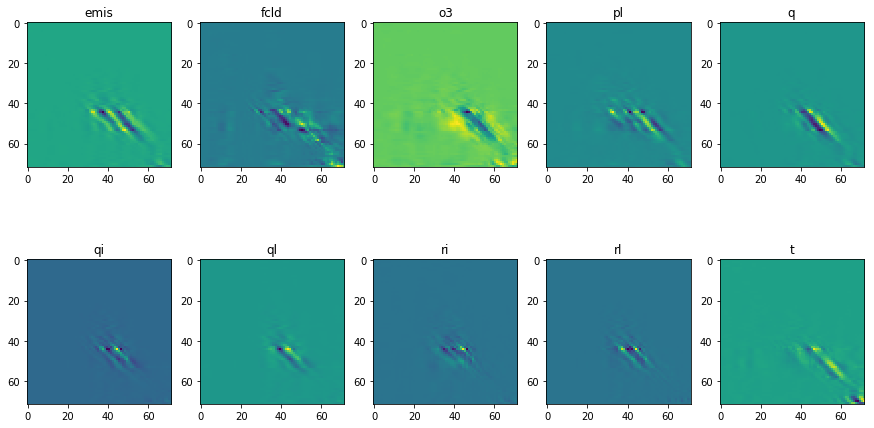

In [30]:
F=F_and_plots(figsize=(15,8), shape=(2,5))
Sep_Var_show(F,G0, header_x)

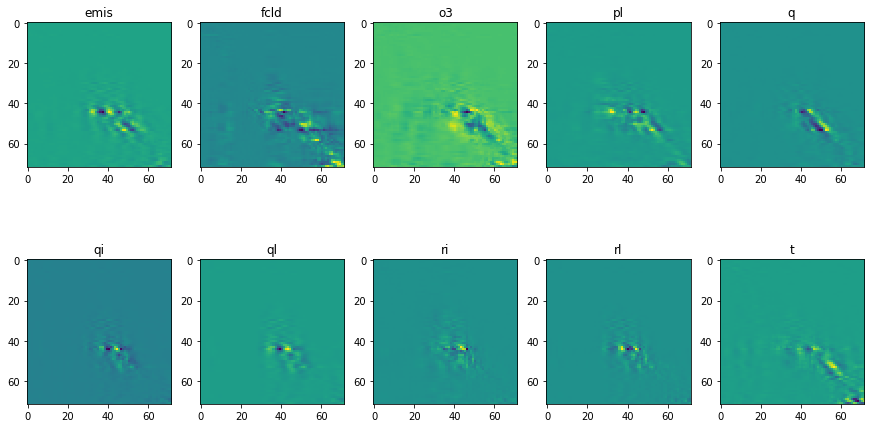

In [33]:
F=F_and_plots(figsize=(15,8), shape=(2,5))
Sep_Var_show(F,10000*J+G0, header_x)

In [52]:
for j,i in enumerate(G2-J2):
    print(header_x[j], np.max(i), np.min(i))

emis 3.4753172397613525 -5.038313627243042
fcld 4.450602293014526 -3.2322890758514404
o3 0.9157004952430725 -2.905653238296509
pl 4.1315600872039795 -3.7754268646240234
q 49.70502281188965 -54.84940028190613
qi 69.43060564994812 -36.00625824928284
ql 247.81062531471252 -280.3574583530426
ri 9.647634029388428 -5.988334655761719
rl 25.624382734298706 -15.990925073623657
t 3.0675272941589355 -4.052147626876831


In [49]:
for j,i in enumerate(G2):
    print(header_x[j], np.max(i), np.min(i))

emis 3.4751897 -5.038152
fcld 4.450342 -3.2321835
o3 0.91567427 -2.9055223
pl 4.131408 -3.7752972
q 49.702225 -54.847145
qi 69.42737 -36.005356
ql 247.80237 -280.35013
ri 9.647031 -5.988172
rl 25.623098 -15.990633
t 3.0673404 -4.051973


In [50]:
for j,i in enumerate(J2*10000):
    print(header_x[j], np.max(i), np.min(i))

emis 3.2377243041992188 -2.1457672119140625
fcld 2.32696533203125 -3.8766860961914062
o3 1.4138221740722656 -0.6794929504394531
pl 1.7452239990234375 -2.4962425231933594
q 31.156539916992188 -28.03802490234375
qi 18.143653869628906 -32.37485885620117
ql 139.923095703125 -111.38439178466797
ri 2.8443336486816406 -6.031990051269531
rl 7.419586181640625 -12.843608856201172
t 2.0444393157958984 -2.016127109527588


In [47]:
from generator import Full_Diff_Generator
test_gen = Full_Diff_Generator(folder='Data3', batch_size=batch_size, train=False, preprocess_x=FP, chosen_var=['flxd', 'flxu'], shuffle=0)
test_gen.list_files = [24]

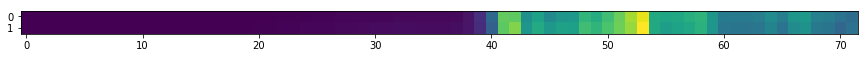

In [50]:
import tensorflow as tf
# CHECKING IMPACT OF LOWER LAYER
x,y = test_gen[100]

y0 = M.predict(x)

i = M_Up.get_input_at(0)
o = M_Up.get_output_at(0)

Up_model = K.function([i],[o])

i1 = M_unet.get_input_at(0)
o1 = M_unet.get_output_at(0)

o2 = M_unet.get_layer('Reshape').output
o3 = M_unet.get_layer('elu_301').get_output_at(0)
o4 = M_unet.get_layer('Conv3_301').get_output_at(0)
o5 = M_unet.get_layer('linear_302').get_output_at(0)

Second_model = K.function( [i1],[o1])
Dense_layer = K.function( [i1],[o2])
Antepen_layer = K.function( [i1],[o3])
#Last_layer = K.function( [i1],[o4])
Last_layer = K.function( [i1],[o5])


#img = Dense_layer(First_model([x]))[0]
img = Last_layer( Up_model([x]))[0]

#Antepen_layer(Up_model([x]))[0]
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(111)
ax.imshow((np.mean(abs(img),axis=0).T))
#F = K.function(I,O)
#F([tf.cast(x,tf.float32)])

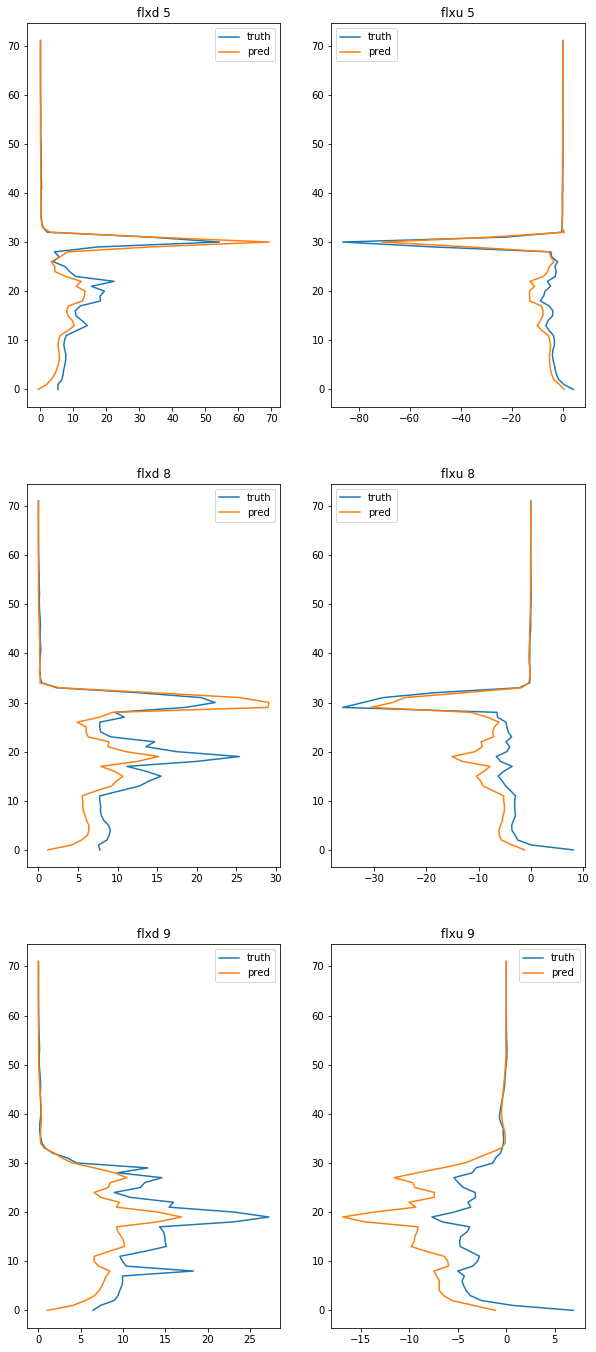

In [76]:
def Plot_diff(F, y,y0, header_y, lev=72, J = [0], titles=False):
    for l in range(len(header_y)):
        for ind,i in enumerate(J):
            F[ind*len(header_y) + l].plot(np.flip(y[i,:,l].T) , np.arange(lev))
            F[ind*len(header_y) + l].plot(np.flip(y0[i,:,l].T) , np.arange(lev))
            F[ind*len(header_y) + l].legend(["truth", "pred"])
            if titles !=False:
                F[ind*len(header_y) + l].set_title(header_y[l] + ' '+ str(titles[ind]))
                

J=[5,8,9]
F = F_and_plots(figsize=(5*2,len(J)*8), shape=(len(J), 2))
Plot_diff(F, y, img, ['flxd', 'flxu'], J=J, titles=J)

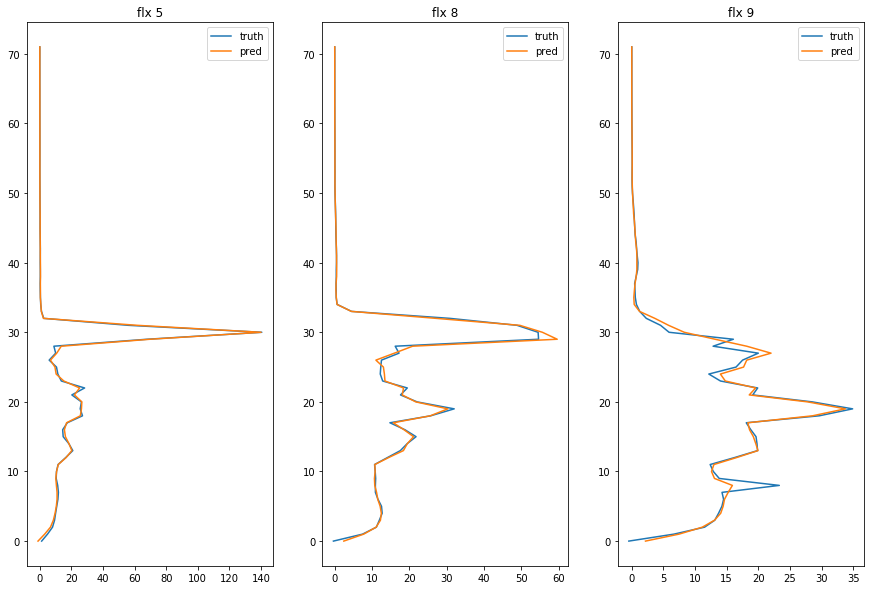

In [73]:
F = F_and_plots(figsize=(15,10), shape=(1,len(J)))
Plot_diff(F, y[:,:,[0]]-y[:,:,[1]], y0.reshape(32,72,1), ['flx'], J=J, titles=J)

In [70]:
def Profile_to_Generator(gen, i1, j1):
    # IS NOT WORKING PROPERLY use produce_xnc4
    """
    given indices i and j for fortran code, this returns two ids such that gen[id1][:][id2] is the same profile
    gen_dim : dimensions method of generator with suffle==0, len(Listdir)==1
    i, x id
    j, y id
    """
    i=i1-1
    j=j1-1
    x=gen.dimensions['x']
    y=gen.dimensions['y']
    (x_id,y_id) = (i//x, j//y)
    (in_file_x_id, in_file_y_id) = (i%x, j%y)
    File_id = x_id+y_id*5
    el_id = in_file_x_id*x + in_file_y_id
    el_batch = el_id//gen.batch_size
    print( File_id, el_batch)
    id = gen.ids_to_index([0, File_id, el_batch])
    return id, el_id%gen.batch_size


(32, 72)

# CUMULATIVE